# Script for analysis of insertion patterns of transposons


In [1]:
import pandas as pd
import hicstraw
import pyBigWig
import matplotlib
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import euclidean_distances

from collections import Counter
import pickle

# Load in repeat masker data

Detection of Transposons in genome:

repeat masker from UCSC:

https://genome.ucsc.edu/cgi-bin/hgTrackUi?g=rmsk


https://genome.ucsc.edu/cgi-bin/hgTables?hgta_doMainPage=1&hgta_group=varRep&hgta_track=rmsk&hgta_table=rmsk&hgsid=1409663405_4aL7oZASpQ7rZ6grjKWGJNHJPUAe&source=post_page-----2b32f6b67364--------------------------------


uses data from repeatmasker:
https://www.repeatmasker.org/genomicDatasets/RMGenomicDatasets.html


#Alternative names of chromosomes:
https://genome.ucsc.edu/FAQ/FAQdownloads.html#downloadAlt

"The chr_alt chromosomes, such as chr5_KI270794v1_alt, are alternative sequences that differ from the reference genome currently available..."

"The chr_fix chromosomes, such as chr1_KN538361v1_fix, are fix patches currently available for the mm10, hg19, and hg38 assemblies that represent changes to the existing sequence..."


"ChrUn contains clone contigs that cannot be confidently placed on a specific chromosome..."


"ChrN_random: ...data related to sequence that is known to be in a particular chromosome, but could not be reliably ordered within the current sequence..."

"What is chromosome M (chrM)? "Mitochondrial DNA.

etc...



Annotation of Lines https://www.repeatmasker.org/faq.html:
Since LINE copies tend to be 5' truncated, full-length models of the detailed subfamily structure apparent in the well-represented and fast-evolving 3' end are difficult to obtain. Rather than comparing the query to a large number of full-length (6-8 kb) consensus sequences that are identical except for the very 3' end, we often fragment LINE models into domains (e.g. 5' end, ORF2-region, and 3' end) which are transparently merged in the RepeatMasker annotation as if the matching was done to a full-length consensus. Our nomenclature and fragmentation thus create a many-to-one relationship with Repbase full-length entries. 


https://www.animalgenome.org/bioinfo/resources/manuals/RepeatMasker.html

In [2]:
#repeat masker files
fields_sel=["genoName","genoStart","genoEnd","repName","repClass","repFamily"]
rmd_3=pd.read_csv("Transposon_analysis_1/hg19_all_fields_repeat_masker",sep="\t",header = 0,usecols=fields_sel)



In [3]:
rmd_3 #[rmd_3["repFamily"]=="DNA"]

genoName  genoStart   genoEnd     repName repClass  \
0                         chr1   16777160  16777470       AluSp     SINE   
1                         chr1   25165800  25166089        AluY     SINE   
2                         chr1   33553606  33554646         L2b     LINE   
3                         chr1   50330063  50332153      L1PA10     LINE   
4                         chr1   58720067  58720973       L1PA2     LINE   
...                        ...        ...       ...         ...      ...   
5481336  chr21_gl000210_random      25378     25875      MER74B      LTR   
5481337  chr21_gl000210_random      26437     26596        MIRc     SINE   
5481338  chr21_gl000210_random      26881     27022        MIRc     SINE   
5481339  chr21_gl000210_random      27296     27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468     27682  HAL1-2a_MD     LINE   

        repFamily  
0             Alu  
1             Alu  
2              L2  
3              L1  
4              L1  
...           ...  
5481336      ERVL  
5481337       MIR  
5481338       MIR  
5481339        L1  
5481340        L1  

[5481341 rows x 6 columns]

In [4]:
#Names of sub-families
unique_v3 = [rmd_3[col_name].unique() for col_name in rmd_3.columns]

for i in unique_v3[3]:
    print(i)

AluSp
AluY
L2b
L1PA10
L1PA2
L1MB7
ERVL-E-int
L2a
L1ME1
L1PA7
L1PA3
AluSq2
HSMAR2
MLT1J
MIRb
THE1B
AluSx1
MER58A
LTR12C
MIR3
L1ME2
L3
AluSc
L2
AluJb
L1MEc
Charlie1b
AluSx
MIRc
MER21C
AluSx4
L4
L1MA9
AT_rich
L2c
L1MB3
THE1B-int
MER58B
AluJr
MamRep1527
MIR
THE1D
SVA_D
FRAM
AluSg
LTR47B
L1PA8A
AluJo
MER6B
LTR76
L1PA6
LTR85c
L1M2
Mam_R4
HAL1
L1PA14
AluSz
L1MA10
L1M1
(CA)n
L1ME3
L1PBa
L1PA15-16
MLT2B4
MER21A
MLT1F2
L1M4
AluSc8
Arthur1
L1MDa
MLT1M
LTR24C
MER65D
Charlie25
MLT1B
HERVH-int
MER58D
L1MC4
L1ME4a
Tigger3a
L1MB8
MER20
(CAAAA)n
MER52-int
HERVK-int
LTR7B
MLT1H
LTR37A
(TA)n
LTR38B
MER39
MLT1A0
MER11C
L1MC
LTR7C
MER5B
AluSz6
MER53
AluSx3
SVA_F
MLT1L
GA-rich
L1M3
MER41B
Tigger1
(GAA)n
L1MC1
MLT1I
L1PA5
L1PA4
LTR33
MER33
L1MC3
FLAM_C
AluJr4
L1M5
Harlequin-int
L1PA15
LTR16A
L1MA1
MER41-int
L1PA17
L1PB4
L1M4b
L1PB1
L1PA13
L1MB1
HERVI-int
MLT1E1A
MLT1C
MER82
MamGypLTR1b
L1MA7
LTR85a
L1MB2
L1PA8
MLT2A1
MLT1J1-int
L1P1
LTR16A1
MER31-int
LTR1B
(TG)n
THE1A-int
MLT1D
HERVL32-int
L1MA3
ERVL-B4-int


# Load subset of repeat masker data, sub- positions, on each chromosome

In [5]:

##########
#rmd_3:
#no chrY to compare to HeLa cells
chr_list_3=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22","chrX"
         ]

element_sel_3="L1ME1" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"



In [6]:
#function to select repetitive elements
def sel_rep_element_on_chr(rmd_1,chr_list,elements_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[0]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx.iloc[:,3].str.startswith(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list

def sel_rep_element_on_chr_2(rmd_1,chr_list,elements_name,chr_col_name,element_col_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[chr_col_name]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx[element_col_name].str.fullmatch(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list

In [7]:
rmd_list_3= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_3,elements_name=element_sel_3,chr_col_name="genoName",element_col_name="repName")

In [8]:
rmd_list_3

[       genoName  genoStart    genoEnd repName repClass repFamily
 8          chr1  117440426  117440514   L1ME1     LINE        L1
 9          chr1  117440494  117441457   L1ME1     LINE        L1
 62         chr1  114294558  114295009   L1ME1     LINE        L1
 63         chr1  116391804  116391994   L1ME1     LINE        L1
 103        chr1  216004377  216007947   L1ME1     LINE        L1
 ...         ...        ...        ...     ...      ...       ...
 431113     chr1  247939643  247940146   L1ME1     LINE        L1
 431117     chr1  247941299  247941531   L1ME1     LINE        L1
 431120     chr1  247943689  247943971   L1ME1     LINE        L1
 431122     chr1  247944179  247944276   L1ME1     LINE        L1
 432651     chr1  249126262  249126531   L1ME1     LINE        L1
 
 [2527 rows x 6 columns],
        genoName  genoStart    genoEnd repName repClass repFamily
 432872     chr2    4194280    4195111   L1ME1     LINE        L1
 432949     chr2  191889374  191889503   L1ME1  

In [9]:
len_rmd_list_3=0
for i in range(len(rmd_list_3)):
    len_rmd_list_3=len_rmd_list_3+len(rmd_list_3[i])
print(len_rmd_list_3)

31377


# Pairwise distances elements and random positions

In [10]:
def positions_elements(rmd_input):
    #rmd_input: repeat masker file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    for i in range(len(rmd_input)):
        pos_1=rmd_input[i:i+1][1].to_numpy()[0] + 0.5*(rmd_input[i:i+1][2].to_numpy()[0]-rmd_input[i:i+1][1].to_numpy()[0])
        
        pos.append(pos_1)
    return np.asarray(pos)

def positions_elements_2(rmd_input):
    #rmd_input: repeat masker file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    for i in range(len(rmd_input)):
        pos_1=rmd_input[i:i+1]["genoStart"].to_numpy()[0] + 0.5*(rmd_input[i:i+1]["genoEnd"].to_numpy()[0]-rmd_input[i:i+1]["genoStart"].to_numpy()[0])
        
        pos.append(pos_1)
    return np.asarray(pos)

#get positions and length of elements
def positions_elements_2_b(rmd_input):
    #rmd_input: repeat masker file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    len_element=[]
    for i in range(len(rmd_input)):
        len_1=rmd_input[i:i+1]["genoEnd"].to_numpy()[0]-rmd_input[i:i+1]["genoStart"].to_numpy()[0]
        pos_1=rmd_input[i:i+1]["genoStart"].to_numpy()[0] + 0.5*len_1
        
        pos.append(pos_1)
        len_element.append(len_1)
    return np.asarray(pos), np.asarray(len_element)

In [11]:
#get positions of elements and pariwise distances for each entry in chr_list, and same for random positions
def get_pos_dist(chr_list,rmd_list):
    #list of positions
    pos_x_list=[]
    #list of homogeneously distributed positions
    pos_rd_x_list=[]

    #list of pairwise distances in each chromosome
    dist_x_list=[]
    #list of pairwise distances from homogebeously distributed elements
    dist_rd_x_list=[]
    for i in range(len(chr_list)):
        #print(chr_list[i])
        positions_elements_x=positions_elements_2(rmd_list[i])
        pos_x_list.append(positions_elements_x)
        
        '''dist_x = np.empty((len(positions_elements_x),len(positions_elements_x)))
        for i in range(len(positions_elements_x)):
            dist_x[i, :] = ((positions_elements_x.reshape(-1,1)-positions_elements_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_x=dist_x[np.triu_indices(len(positions_elements_x),k=1)]'''
        #return D
        dist_x=scipy.spatial.distance.pdist(positions_elements_x.reshape(-1,1),metric='euclidean')
        #dist_x=euclidean_distances(positions_elements_x.reshape(-1,1),positions_elements_x.reshape(-1,1))[np.triu_indices(len(positions_elements_x),k=1)]
        dist_x_list.append(np.asarray(dist_x) )

        #homogeneously distributed positions in intervall [min_pos, max_pos], number =  number of elements on chr. from rep. masker subset
        positions_random_x=np.random.choice(np.arange(np.min(positions_elements_x),np.max(positions_elements_x),step=0.5),size=len(positions_elements_x))
        '''dist_rd_x = np.empty((len(positions_random_x),len(positions_random_x)))
        for i in range(len(positions_random_x)):
            dist_rd_x[i, :] = ((positions_random_x.reshape(-1,1)-positions_random_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_rd_x=dist_rd_x[np.triu_indices(len(positions_random_x),k=1)]'''
        pos_rd_x_list.append(positions_random_x)
        dist_rd_x=scipy.spatial.distance.pdist(positions_random_x.reshape(-1,1),metric='euclidean')
        #dist_rd_x=euclidean_distances(positions_random_x.reshape(-1,1),positions_random_x.reshape(-1,1))[np.triu_indices(len(positions_random_x),k=1)]

        dist_rd_x_list.append(np.asarray(dist_rd_x))
    return pos_x_list, pos_rd_x_list, dist_x_list, dist_rd_x_list

#get positions and lengths of elements and pariwise distances for each entry in chr_list, and same for random positions
def get_pos_dist_2(chr_list,rmd_list):
    #list of positions
    pos_x_list=[]
    #list of lengths
    len_x_list=[]
    #list of homogeneously distributed positions
    pos_rd_x_list=[]

    #list of pairwise distances in each chromosome
    dist_x_list=[]
    #list of pairwise distances from homogebeously distributed elements
    dist_rd_x_list=[]
    for i in range(len(chr_list)):
        #print(chr_list[i])
        positions_elements_x,lenghts_elements_x=positions_elements_2_b(rmd_list[i])
        pos_x_list.append(positions_elements_x)
        len_x_list.append(lenghts_elements_x)
        
        '''dist_x = np.empty((len(positions_elements_x),len(positions_elements_x)))
        for i in range(len(positions_elements_x)):
            dist_x[i, :] = ((positions_elements_x.reshape(-1,1)-positions_elements_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_x=dist_x[np.triu_indices(len(positions_elements_x),k=1)]'''
        #return D
        dist_x=scipy.spatial.distance.pdist(positions_elements_x.reshape(-1,1),metric='euclidean')
        #dist_x=euclidean_distances(positions_elements_x.reshape(-1,1),positions_elements_x.reshape(-1,1))[np.triu_indices(len(positions_elements_x),k=1)]
        dist_x_list.append(np.asarray(dist_x) )

        #homogeneously distributed positions in intervall [min_pos, max_pos], number =  number of elements on chr. from rep. masker subset
        positions_random_x=np.random.choice(np.arange(np.min(positions_elements_x),np.max(positions_elements_x),step=0.5),size=len(positions_elements_x))
        '''dist_rd_x = np.empty((len(positions_random_x),len(positions_random_x)))
        for i in range(len(positions_random_x)):
            dist_rd_x[i, :] = ((positions_random_x.reshape(-1,1)-positions_random_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_rd_x=dist_rd_x[np.triu_indices(len(positions_random_x),k=1)]'''
        pos_rd_x_list.append(positions_random_x)
        dist_rd_x=scipy.spatial.distance.pdist(positions_random_x.reshape(-1,1),metric='euclidean')
        #dist_rd_x=euclidean_distances(positions_random_x.reshape(-1,1),positions_random_x.reshape(-1,1))[np.triu_indices(len(positions_random_x),k=1)]

        dist_rd_x_list.append(np.asarray(dist_rd_x))
    return pos_x_list,len_x_list, pos_rd_x_list, dist_x_list, dist_rd_x_list


In [12]:
#pos_x_list_3, pos_rd_x_list_3, dist_x_list_3, dist_rd_x_list_3 = get_pos_dist(chr_list=chr_list_3,rmd_list=rmd_list_3)

pos_x_list_3,len_x_list_3, pos_rd_x_list_3, dist_x_list_3, dist_rd_x_list_3 = get_pos_dist_2(chr_list=chr_list_3,rmd_list=rmd_list_3)

# Probability density of pairwise distances from uniformly distributed positions

Pairwise distance of x from 2 points on a 1D domain of lenth L:

First point has to be within L-x from boundary, as distance x would not fit in 1D domain with length L otherwise.
prob first point ~ (L-x)/L

Probability to find second point such that pairwise distance is x, is ~1/L, as each point is equally likely.
prob second point ~1/L

Multiply and add normalization 1/N:

p= (L-x)/L^2 * 1/N

Integration has to give one-> N=2

p= 2*(L-x)/L^2

In [13]:
def distr_1(L,x):
    return 2/L**2 * (L-x) 

Integration of pdf= 1.0


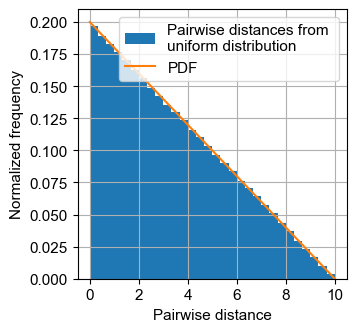

In [14]:
#test distribution
#uniformly distributed points on 1D line
interval_test=np.arange(0,10,step=0.001) #np.arange(0,1000,step=0.1)
random_pos_test=np.random.choice(interval_test,size=5000)

#resulting pairwise distances
dist_random_pos_test=scipy.spatial.distance.pdist(random_pos_test.reshape(-1,1),metric='euclidean')


#integration
int2=scipy.integrate.trapezoid(distr_1(np.max(interval_test),interval_test),interval_test)

print("Integration of pdf=",int2)

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)
hist_dist_1=ax1.hist(dist_random_pos_test,bins=30,label="Pairwise distances from \nuniform distribution",density=True)
ax1.errorbar(interval_test,distr_1(np.max(interval_test),interval_test),label="PDF")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Pairwise distance",fontname = "Arial",fontsize=11)
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#plt.yscale("log")
#plt.xscale("log")
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/pairwise_distances_uniform_points_log_1.png",format="png",bbox_inches="tight",dpi=300)

# Mean and Std of distribution

Mean: L/3

Std: L/sqrt(18)

In [15]:
print("Mean samples:",np.mean(dist_random_pos_test), "Mean Pdf: ",np.max(interval_test)/3)
print("Std samples:",np.std(dist_random_pos_test), "Std Pdf: ",np.max(interval_test)/np.sqrt(18))

Mean samples: 3.341935893578713 Mean Pdf:  3.333
Std samples: 2.3627339729295467 Std Pdf:  2.3567869016947633


# Pairwise distances on each chromosome

In [16]:
def pairwise_dist_hist_1(chr_list,dist_x_list,dist_rd_x_list):
    
    for i in range(len(chr_list[:])):
        print(chr_list[i])
        dist_x=dist_x_list[i]


        dist_rd_x=dist_rd_x_list[i]



        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)


        hist_dist_b_3=ax1.hist([dist_x,dist_rd_x],bins=40,label=["Rep. elements","Uniform insertions"],density=True,color=["tab:orange","tab:blue"],cumulative=False,histtype="bar")

        #distribution
        L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF uniform insertions",color="black")


        print("Mean dist: ", np.mean(dist_x))
        print("Std dist: ", np.std(dist_x))
        print("Median dist: ", np.median(dist_x))
        print("Min dist: ", np.min(dist_x),"Max dist: ",np.max(dist_x))

        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
        #plt.xscale("log")
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())

        #plt.savefig("Transposon_analysis_1/figures/hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()

In [17]:
def pairwise_dist_hist_2(chr_list,dist_x_list,dist_rd_x_list):
    #logarithmic visualization as clustering on much smaller distances then max pairwise distance

    for i in range(len(chr_list[:])):
        print(chr_list[i])
        #logarithmic spacing of bins
        den_input=np.geomspace(1,np.max(dist_x_list[i]),num=50)

        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)

        dist_x=dist_x_list[i]
        ax1.hist(dist_x,bins=den_input,label="Rep. elements",density=True,color="tab:orange")

        L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF uniform insertions",color="black")


        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
        plt.xscale("log")
        plt.yscale("log")
        #plt.xlim(1,np.max(dist_x_list[i]))
        #plt.xlim(1,1000)
        #print(np.max(dist_x_list[i]))
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())
        #plt.savefig("Transposon_analysis_1/figures/log_hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()

In [18]:
def pairwise_dist_hist_3(chr_list,dist_x_list,dist_rd_x_list):
    #logarithmic visualization as clustering on much smaller distances then max pairwise distance

    for i in range(len(chr_list[:])):
        print(chr_list[i])
        #logarithmic spacing of bins
        den_input=np.geomspace(1,np.max(dist_x_list[i]),num=50)

        fig=plt.figure(figsize=(3.5,3.5))
        ax1 = fig.add_subplot(111)

        dist_x=dist_x_list[i]
        ax1.hist(dist_x,bins=den_input,label="Rep. elements",density=True,color="tab:orange",cumulative=True,histtype="step")

        #L_sel=np.max(dist_x) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
        #ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF hom. positions",color="black")


        plt.yticks(fontname = "Arial",fontsize=11) 
        plt.xticks(fontname = "Arial",fontsize=11) 
        plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
        plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
        plt.xscale("log")
        #plt.yscale("log")
        #plt.xlim(1,np.max(dist_x_list[i]))
        #plt.xlim(1,1000)
        #print(np.max(dist_x_list[i]))
        plt.legend(prop={'family': 'Arial','size': 11})
        plt.grid()
        ax1.set_aspect(1./ax1.get_data_ratio())
        #plt.savefig("Transposon_analysis_1/figures/log_hist_L1_chr1_1.pdf",format="pdf",bbox_inches="tight")
        plt.show()

# Averaged, normalized pairwise distance

In [19]:
def all_normalized_dist(chr_list,dist_x_list,norm=True):    
    dist_x_list_all_norm_1=[]
    dist_x_list_all_norm=[]



    #append all pairwise distances normalized with max distace        
    for i in range(len(chr_list[:])):
        #print(chr_list[i])

        if norm==True:
            dist_x_list_all_norm_1.append(dist_x_list[i]/np.max(dist_x_list[i]))
        if norm==False:
            dist_x_list_all_norm_1.append(dist_x_list[i])
 
    #flatten list    
    for i in dist_x_list_all_norm_1:
        for j in i:
            dist_x_list_all_norm.append(j)

    dist_x_list_all_norm=np.asarray(dist_x_list_all_norm)

    return dist_x_list_all_norm

#get list of pdfs from hom distribution for dist_x_list entries
#need to use same x range for all distibutions to compare, need to set negative values of distr_1 to zero
def list_of_pdfs_hom_distr(chr_list,dist_x_list):
    pdf=[]
    L_max=max(max(sublist) for sublist in dist_x_list)# L_max to set same x range for all distributions
    pdf_x_e= np.linspace(0,L_max,100)#x range to use for all distributions
    for i in range(len(chr_list)):
        L_max_e=np.max(dist_x_list[i]) #L_max for normalization of distr
        pdf_e=distr_1(L_max_e,pdf_x_e)
        pdf_e[pdf_e < 0] = 0 #distribution goes to zero for negative values
        pdf.append(pdf_e)
    return np.asarray(pdf) ,  pdf_x_e


        
    

In [20]:
#logarithmic visualization as clustering on much smaller distances then max pairwise distance
def pairwise_dist_hist_all_1(dist_x_list_all_norm,norm=True):
    dist_x_list_all_norm_rs=dist_x_list_all_norm #*10**8
    if norm==True:
        den_input=np.geomspace(1,10**8,num=50)/10**8
    if norm==False:
        den_input=np.geomspace(1,10**8,num=50)
        
    fig=plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)


    ax1.hist(dist_x_list_all_norm_rs,bins=den_input,label="Rep. element",density=True,color="tab:orange")

    L_sel=np.max(dist_x_list_all_norm_rs) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
    ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="PDF uniform insertions",color="black")


    plt.yticks(fontname = "Arial",fontsize=11) 
    plt.xticks(fontname = "Arial",fontsize=11) 
    plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
    plt.xlabel("Pairwise rescaled distance",fontname = "Arial",fontsize=11)
    plt.xscale("log")
    plt.yscale("log")
    #plt.xlim(1,np.max(dist_x_list[i]))
    #plt.xlim(1,1000)
    #print(np.max(dist_x_list[i]))
    plt.legend(prop={'family': 'Arial','size': 11})
    plt.grid()
    ax1.set_aspect(1./ax1.get_data_ratio())
    plt.show()
    
  
#logarithmic visualization as clustering on much smaller distances then max pairwise distance
def pairwise_dist_hist_all_2(dist_x_list_all_norm):
    dist_x_list_all_norm_rs=dist_x_list_all_norm*10**8
    den_input=np.geomspace(1,10**8,num=50)

    fig=plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)


    ax1.hist(dist_x_list_all_norm_rs,bins=den_input,label="Rep. element",density=True,color="tab:orange",cumulative=True,histtype="step")

    #L_sel=np.max(dist_x_list_all_norm_rs) #distances in [0, max_possible_distance], L=max_possible_distance=max_pos-min_pos =max(distances)
    #ax1.errorbar(np.linspace(0,L_sel),distr_1(L_sel,np.linspace(0,L_sel)),label="Pdf hom. positions",color="black")


    plt.yticks(fontname = "Arial",fontsize=11) 
    plt.xticks(fontname = "Arial",fontsize=11) 
    plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
    plt.xlabel("Pairwise rescaled distance",fontname = "Arial",fontsize=11)
    plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(1,np.max(dist_x_list[i]))
    #plt.xlim(1,1000)
    #print(np.max(dist_x_list[i]))
    plt.legend(prop={'family': 'Arial','size': 11})
    plt.grid()
    ax1.set_aspect(1./ax1.get_data_ratio())
    plt.show()

#logarithmic visualization as clustering on much smaller distances then max pairwise distance
#visualize mean pdf
#normalization??
def pairwise_dist_hist_all_3(dist_x_list,dist_x_list_all_norm,pdfs_1_x,pdfs_1,norm=True,label_rep="Rep. element",label_hom="PDF uniform insertions",save=None):
    dist_x_list_all_norm_rs=dist_x_list_all_norm #*10**8
    if norm==True:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)/10**8
    if norm==False:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)
        
    fig=plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)


    ax1.hist(dist_x_list_all_norm_rs,bins=den_input,label=label_rep,density=True,color="tab:orange")
    
    #pdfs_1_mean=np.mean(pdfs_1,axis=0)
    
    weights_pdf = [len(sub_list) for sub_list in dist_x_list] #for weighted average, some chromosomes contribute more
    pdfs_1_mean=np.average(pdfs_1,weights=weights_pdf,axis=0)
    
    #pdfs_1_std=np.std(pdfs_1,axis=0)
    int_pdfs_mean=scipy.integrate.trapezoid(pdfs_1_mean,pdfs_1_x)
    print(int_pdfs_mean)
    #rs_factor=1/int_pdfs_mean
    ax1.errorbar(pdfs_1_x,pdfs_1_mean,label=label_hom,color="black")
    #ax1.fill_between(pdfs_1_x, pdfs_1_mean + pdfs_1_std, pdfs_1_mean - pdfs_1_std, alpha = 0.3,color="black")
    
    plt.yticks(fontname = "Arial",fontsize=11) 
    plt.xticks(fontname = "Arial",fontsize=11) 
    plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
    plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
    plt.xscale("log")
    plt.yscale("log")
    #plt.xlim(1,np.max(dist_x_list[i]))
    #plt.xlim(1,1000)
    #print(np.max(dist_x_list[i]))
    plt.legend(prop={'family': 'Arial','size': 11},loc="lower center")
    plt.grid()
    ax1.set_aspect(1./ax1.get_data_ratio())
    if save==None:
        plt.show()
        
    if save!=None:
        plt.savefig(save,format="pdf",bbox_inches="tight")
        
#logarithmic visualization as clustering on much smaller distances then max pairwise distance
#visualize mean pdf
#normalization??
#smaller figure

#set ticks  in log scale
def set_ticks(value, pos):
    return f"$10^{{{int(np.log10(value))}}}$"



def pairwise_dist_hist_all_3b(dist_x_list,dist_x_list_all_norm,pdfs_1_x,pdfs_1,norm=True,label_rep="Rep. element",label_hom="Pdf hom. positions",save=None,size=3.5):
    dist_x_list_all_norm_rs=dist_x_list_all_norm #*10**8
    if norm==True:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)/10**8
    if norm==False:
        den_input=np.geomspace(1,np.max(dist_x_list_all_norm_rs),num=50)
        
    fig=plt.figure(figsize=(size,size))
    ax1 = fig.add_subplot(111)


    ax1.hist(dist_x_list_all_norm_rs,bins=den_input,label=label_rep,density=True,color="tab:grey")
    
    #pdfs_1_mean=np.mean(pdfs_1,axis=0)
    
    weights_pdf = [len(sub_list) for sub_list in dist_x_list] #for weighted average, some chromosomes contribute more
    pdfs_1_mean=np.average(pdfs_1,weights=weights_pdf,axis=0)
    
    #pdfs_1_std=np.std(pdfs_1,axis=0)
    int_pdfs_mean=scipy.integrate.trapezoid(pdfs_1_mean,pdfs_1_x)
    print(int_pdfs_mean)
    #rs_factor=1/int_pdfs_mean
    ax1.errorbar(pdfs_1_x,pdfs_1_mean,label=label_hom,color="black")
    #ax1.fill_between(pdfs_1_x, pdfs_1_mean + pdfs_1_std, pdfs_1_mean - pdfs_1_std, alpha = 0.3,color="black")
    
    plt.yticks(fontname = "Arial",fontsize=11) 
     
    plt.ylabel("Normalized frequency",fontname = "Arial",fontsize=11)
    plt.xlabel("Pairwise distance [Nt]",fontname = "Arial",fontsize=11)
    plt.xscale("log")
    plt.yscale("log")
    plt.xticks([1e1,1e4,1e7],[1e1,1e4,1e7],fontname = "Arial",fontsize=11)
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(set_ticks))
    plt.xticks(fontname = "Arial",fontsize=11)

    #plt.xlim(1,np.max(dist_x_list[i]))
    #plt.xlim(1,1000)
    #print(np.max(dist_x_list[i]))
    plt.legend(prop={'family': 'Arial','size': 11},loc="lower center")
    plt.grid()
    ax1.set_aspect(1./ax1.get_data_ratio())
    if save==None:
        plt.show()
        
    if save!=None:
        plt.savefig(save,format="pdf",bbox_inches="tight")

# Human

chr1
Mean dist:  84746696.10581304
Std dist:  60374461.499493
Median dist:  73897620.0
Min dist:  92.0 Max dist:  248684521.5


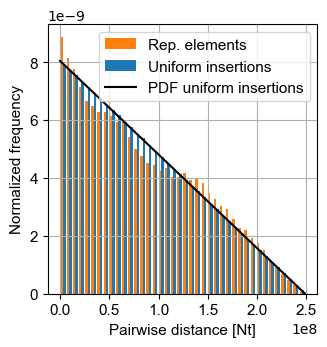

chr2
Mean dist:  81517425.88349704
Std dist:  57797223.850317836
Median dist:  71643817.0
Min dist:  61.0 Max dist:  242832144.5


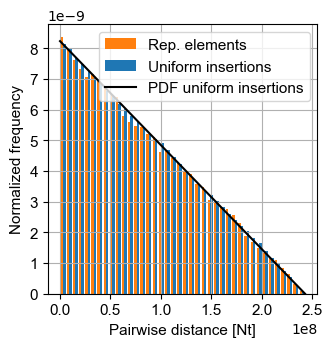

chr3
Mean dist:  66273347.855609275
Std dist:  47046317.7151757
Median dist:  58251699.5
Min dist:  71.0 Max dist:  197441565.5


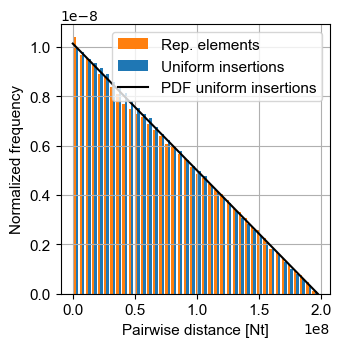

chr4
Mean dist:  65148164.2259174
Std dist:  46114634.452991754
Median dist:  57599107.5
Min dist:  45.0 Max dist:  190442011.5


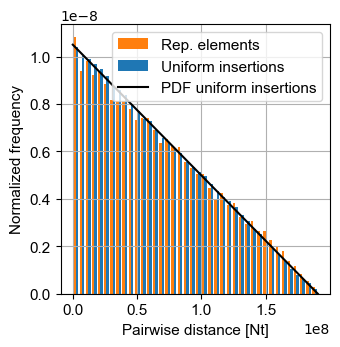

chr5
Mean dist:  60907009.57992001
Std dist:  43260961.076613516
Median dist:  53469723.75
Min dist:  81.0 Max dist:  180834458.0


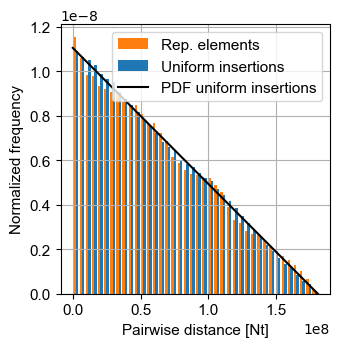

chr6
Mean dist:  58797738.29372217
Std dist:  41818930.011315614
Median dist:  51773868.0
Min dist:  48.0 Max dist:  170593769.5


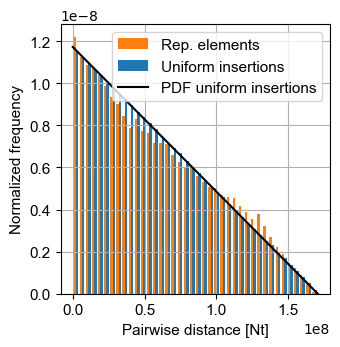

chr7
Mean dist:  53213606.09422209
Std dist:  37696005.551004514
Median dist:  46371230.25
Min dist:  31.5 Max dist:  158927709.5


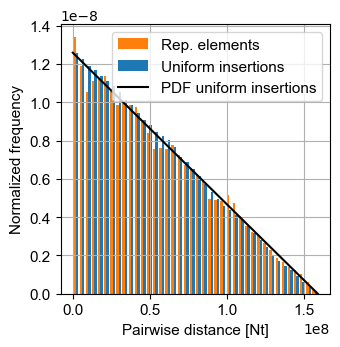

chr8
Mean dist:  47878436.94832093
Std dist:  33883704.76974756
Median dist:  42157053.5
Min dist:  65.5 Max dist:  146094127.5


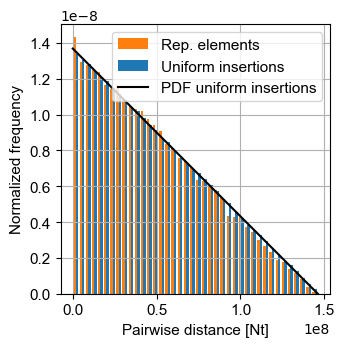

chr9
Mean dist:  48895742.76212948
Std dist:  35878063.55172956
Median dist:  42264351.5
Min dist:  81.5 Max dist:  140812540.5


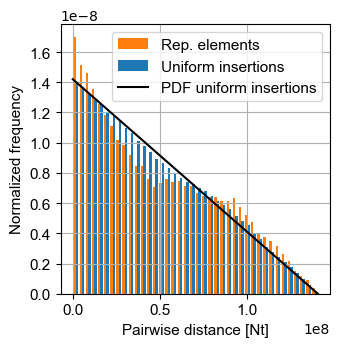

chr10
Mean dist:  46454906.589991294
Std dist:  32956450.726937942
Median dist:  41297915.0
Min dist:  69.0 Max dist:  135171313.5


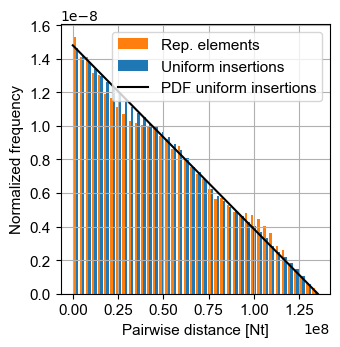

chr11
Mean dist:  47226140.57910699
Std dist:  33607667.40790475
Median dist:  41624203.0
Min dist:  30.5 Max dist:  134430984.0


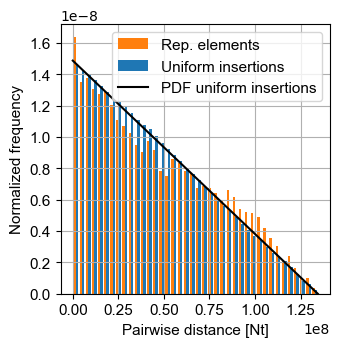

chr12
Mean dist:  45427470.55937938
Std dist:  32132233.99652228
Median dist:  40132007.75
Min dist:  59.5 Max dist:  133631433.5


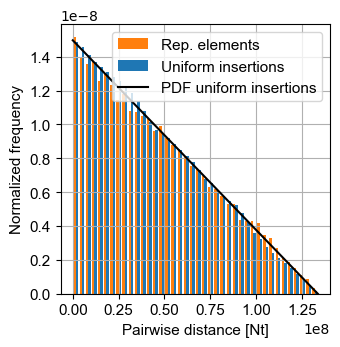

chr13
Mean dist:  32230486.240290657
Std dist:  23006274.048903234
Median dist:  28095868.5
Min dist:  94.5 Max dist:  95091533.0


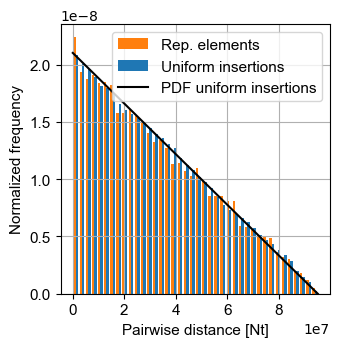

chr14
Mean dist:  28453146.510577876
Std dist:  20226861.61256493
Median dist:  25228991.0
Min dist:  39.5 Max dist:  88160718.5


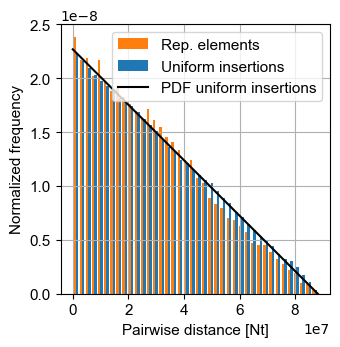

chr15
Mean dist:  28484742.930720564
Std dist:  20182999.1553835
Median dist:  25236563.25
Min dist:  129.5 Max dist:  82204974.5


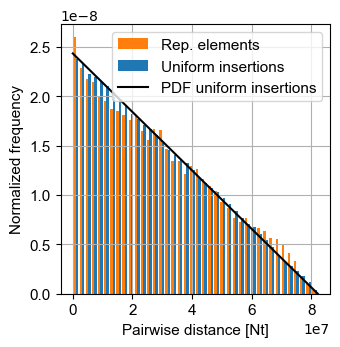

chr16
Mean dist:  30557665.9226468
Std dist:  22227904.62224659
Median dist:  26637579.5
Min dist:  58.0 Max dist:  89542869.5


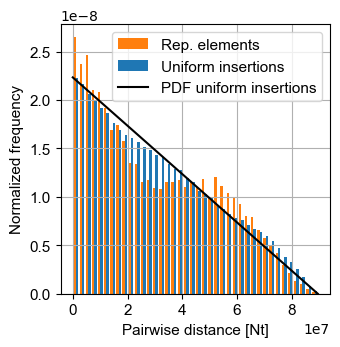

chr17
Mean dist:  29186913.098863635
Std dist:  20766771.20895117
Median dist:  25736725.5
Min dist:  50.0 Max dist:  81155876.0


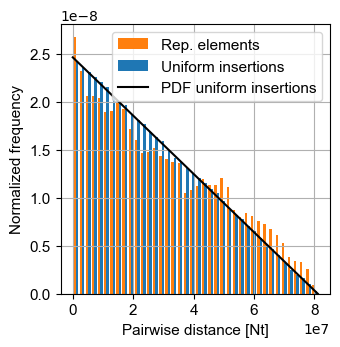

chr18
Mean dist:  25919839.096728023
Std dist:  18404479.53300394
Median dist:  22925086.0
Min dist:  78.0 Max dist:  77530807.0


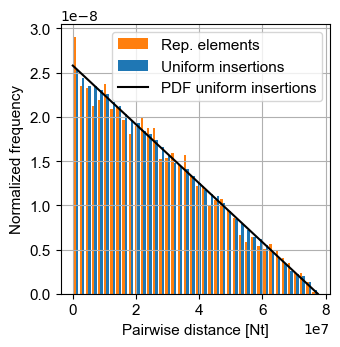

chr19
Mean dist:  17710625.348620676
Std dist:  13036830.384229535
Median dist:  15535861.0
Min dist:  65.0 Max dist:  56029556.0


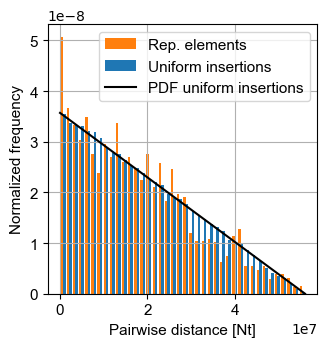

chr20
Mean dist:  22103046.430606965
Std dist:  15660015.454075374
Median dist:  19398492.0
Min dist:  44.0 Max dist:  62841066.5


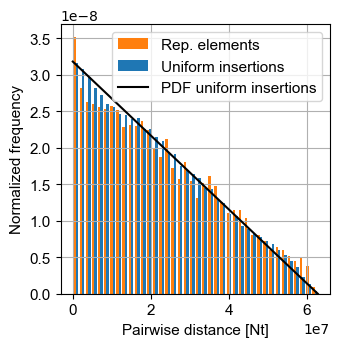

chr21
Mean dist:  13063702.736255411
Std dist:  9328651.944594104
Median dist:  11574754.0
Min dist:  82.0 Max dist:  38372599.0


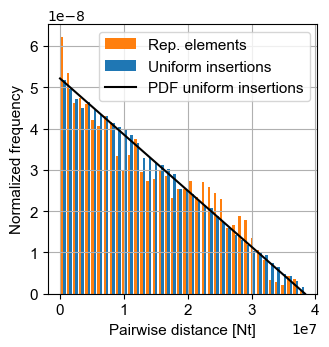

chr22
Mean dist:  12256943.934216468
Std dist:  8888895.416722188
Median dist:  10770016.0
Min dist:  135.0 Max dist:  34978023.0


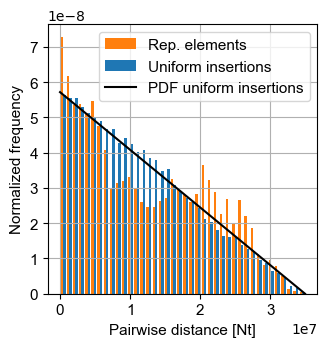

chrX
Mean dist:  51834341.26831347
Std dist:  36785872.235962644
Median dist:  45108311.75
Min dist:  49.0 Max dist:  154812205.5


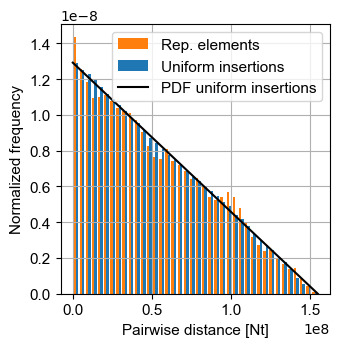

In [21]:
pairwise_dist_hist_1(chr_list=chr_list_3,dist_x_list=dist_x_list_3,dist_rd_x_list=dist_rd_x_list_3)

chr1


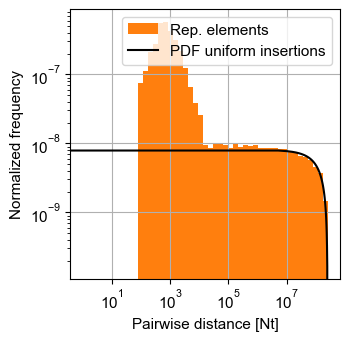

chr2


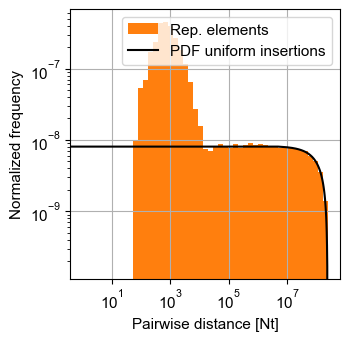

chr3


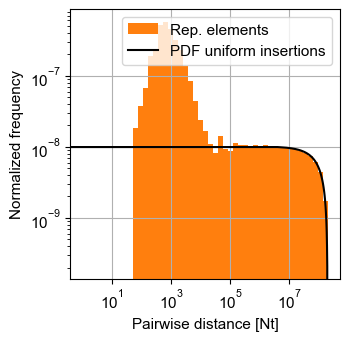

chr4


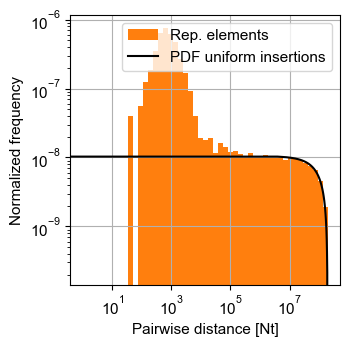

chr5


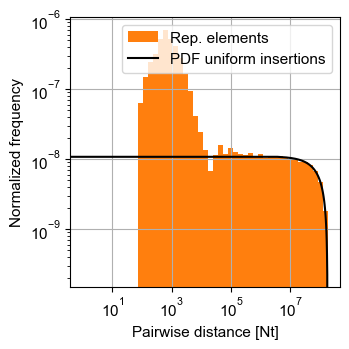

chr6


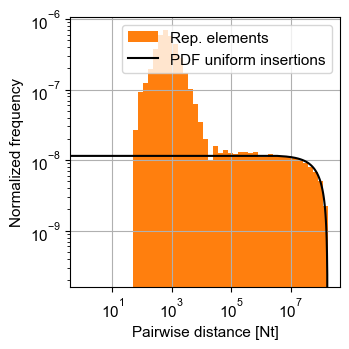

chr7


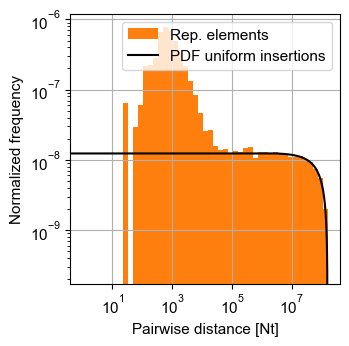

chr8


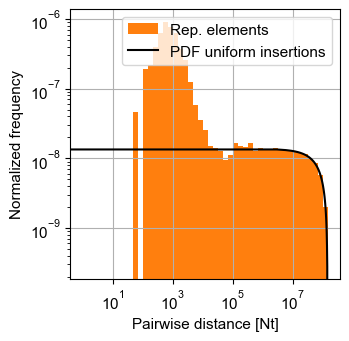

chr9


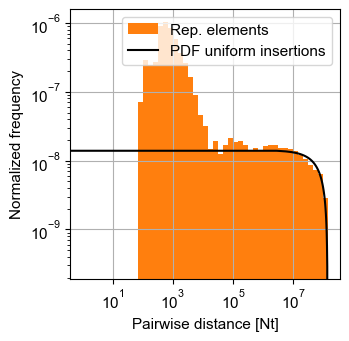

chr10


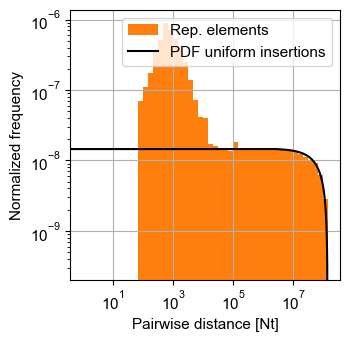

chr11


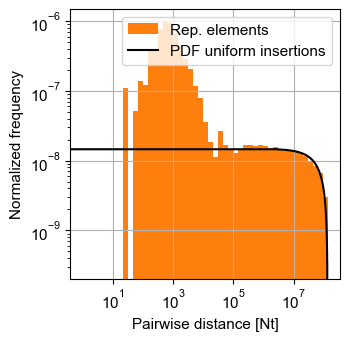

chr12


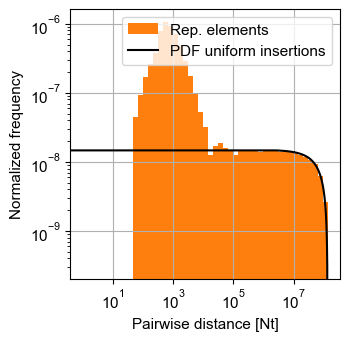

chr13


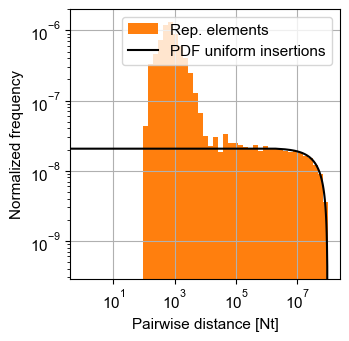

chr14


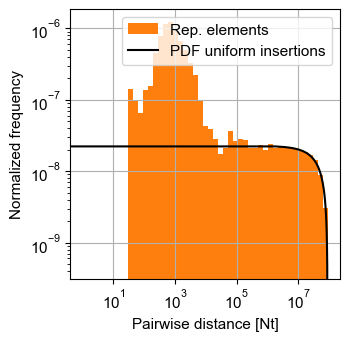

chr15


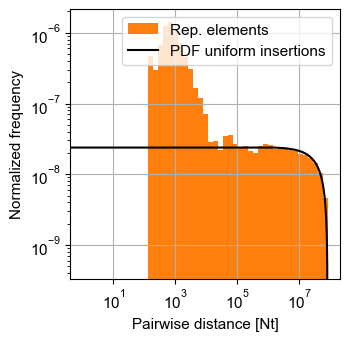

chr16


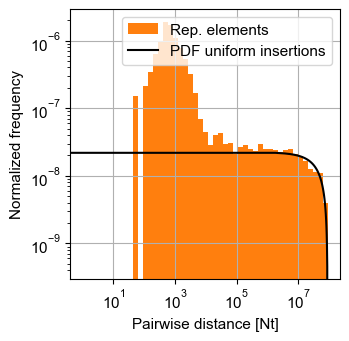

chr17


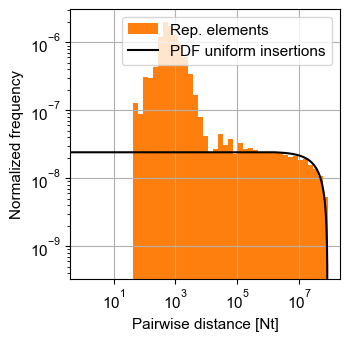

chr18


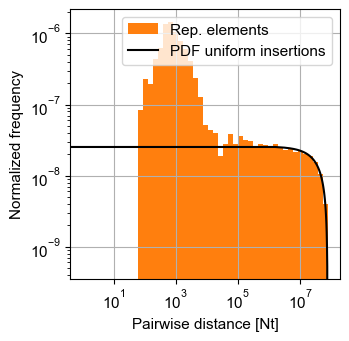

chr19


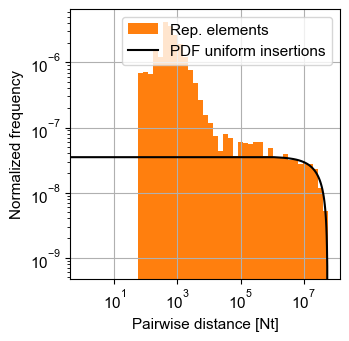

chr20


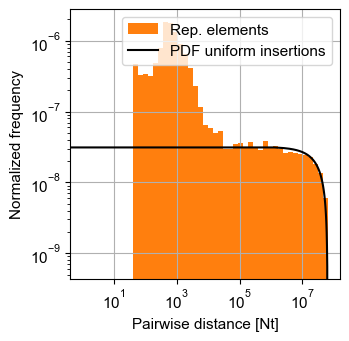

chr21


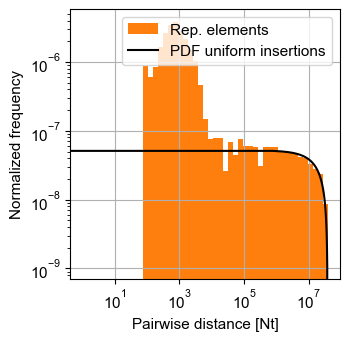

chr22


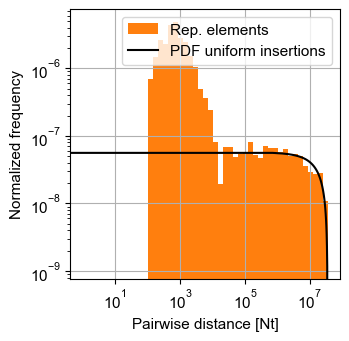

chrX


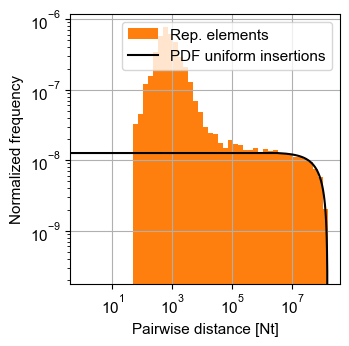

In [22]:
pairwise_dist_hist_2(chr_list=chr_list_3,dist_x_list=dist_x_list_3,dist_rd_x_list=dist_rd_x_list_3)

In [23]:
dist_x_list_all_norm_3=all_normalized_dist(chr_list=chr_list_3,dist_x_list=dist_x_list_3)

In [24]:
print("Mean dist: ", np.mean(dist_x_list_all_norm_3))
print("Std dist: ", np.std(dist_x_list_all_norm_3))
print("Median dist: ", np.median(dist_x_list_all_norm_3))
print("Min dist: ", np.min(dist_x_list_all_norm_3),"Max dist: ",np.max(dist_x_list_all_norm_3))

Mean dist:  0.33901663023242473
Std dist:  0.24123516390273272
Median dist:  0.2974840143574849
Min dist:  1.9820332212111822e-07 Max dist:  1.0


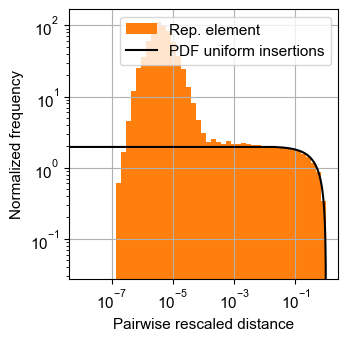

In [25]:
pairwise_dist_hist_all_1(dist_x_list_all_norm=dist_x_list_all_norm_3)

In [26]:

dist_x_list_all_no_norm_3=all_normalized_dist(chr_list=chr_list_3,dist_x_list=dist_x_list_3,norm=False)

pdfs_3,pdfs_3_x=list_of_pdfs_hom_distr(chr_list=chr_list_3,dist_x_list=dist_x_list_3)

1.0000462371506225


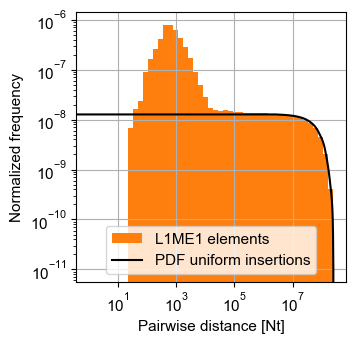

In [27]:
#name_save="Transposon_analysis_1/figures/h_hist_L1MB3_all_chr_2.pdf"
name_save=None

pairwise_dist_hist_all_3(dist_x_list=dist_x_list_3,dist_x_list_all_norm=dist_x_list_all_no_norm_3,pdfs_1_x=pdfs_3_x,pdfs_1=pdfs_3,norm=False,label_rep="L1ME1 elements",label_hom="PDF uniform insertions",save=name_save)



# DB Scan cluster detection

In [28]:
#! crashes for high number of points due to memory 
def DB_scan_1(eps,min_samples,input_):

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    #print(n_clusters_)

    #get particles per cluster 
    counter_labels=Counter(labels)
    

    counter_labels=dict(counter_labels)

    counter_numbers=[]

    for key, value in counter_labels.items():
        #en=counter_labels{i}
        if key !=-1:
            counter_numbers.append(value)
    counter_numbers=np.asarray(counter_numbers)
    
    #percentage of points in clusters:
    try: #if noise present
        perc_in_cluster=1-counter_labels[-1]/len(input_)
    except: #if no noise present, all points part of clusters
        perc_in_cluster=1

    #get mean particle number, get mean only if clusters detected, else append 0    
    if n_clusters_>0:
        mean_cluster_number=np.mean(counter_numbers)
    else:    
        mean_cluster_number=0

    return n_clusters_,mean_cluster_number,perc_in_cluster


In [29]:
def DB_scan_appl_1(eps_1,min_samples_1,chr_list,pos_x_list,pos_rd_x_list): 
    n_clusters_1=[]
    n_clusters_rd_1=[]

    mean_cluster_number_1=[]
    mean_cluster_number_rd_1=[]

    perc_in_cluster_1=[]
    perc_in_cluster_rd_1=[]

    #eps_1=10000
    #min_samples_1=2

    for i in range(len(chr_list[:])):
        n_clusters_1_e,mean_cluster_number_1_e,perc_in_cluster_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_x_list[i].reshape(-1,1))

        n_clusters_1.append(n_clusters_1_e)
        perc_in_cluster_1.append(perc_in_cluster_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_1_e>0:
         #   mean_cluster_number_1.append(mean_cluster_number_1_e)
        #append even for zero average particle number
        mean_cluster_number_1.append(mean_cluster_number_1_e)


        ########################################

        n_clusters_rd_1_e,mean_cluster_number_rd_1_e,perc_in_cluster_rd_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_rd_x_list[i].reshape(-1,1))

        n_clusters_rd_1.append(n_clusters_rd_1_e)
        perc_in_cluster_rd_1.append(perc_in_cluster_rd_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_rd_1_e>0:
         #   mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)    
        #append even for zero average particle number
        mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)

    n_clusters_1=np.asarray(n_clusters_1)
    n_clusters_rd_1=np.asarray(n_clusters_rd_1)

    mean_cluster_number_1=np.asarray(mean_cluster_number_1)
    mean_cluster_number_rd_1=np.asarray(mean_cluster_number_rd_1)

    perc_in_cluster_1=np.asarray(perc_in_cluster_1)
    perc_in_cluster_rd_1=np.asarray(perc_in_cluster_rd_1)


    #non zero entries
    mean_cluster_number_1_nz=mean_cluster_number_1[np.nonzero(mean_cluster_number_1)]
    mean_cluster_number_rd_1_nz=mean_cluster_number_rd_1[np.nonzero(mean_cluster_number_rd_1)]
    
    return n_clusters_1, n_clusters_rd_1, mean_cluster_number_1, mean_cluster_number_rd_1, mean_cluster_number_1_nz, mean_cluster_number_rd_1_nz,perc_in_cluster_1,perc_in_cluster_rd_1

#calculate centres of mass and extend of cluster coordinates
def DB_scan_appl_2(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list): 
    n_clusters_1=[]
    n_clusters_rd_1=[]

    mean_cluster_number_1=[]
    mean_cluster_number_rd_1=[]

    perc_in_cluster_1=[]
    perc_in_cluster_rd_1=[]

    #eps_1=10000
    #min_samples_1=2
    cluster_centers_all=[]
    cluster_ext_all=[]
    for i in range(len(chr_list[:])):
        
        input_=pos_x_list[i].reshape(-1,1)
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_)
        
        # Get cluster labels
        cluster_labels = db.labels_

        # Get core sample indices
        core_indices = db.core_sample_indices_

        # Calculate cluster centers (mean of core samples)
        cluster_centers=[]
        m_d_max=[]
        for l in np.unique(cluster_labels): #select indices for clusters that are not noise
            if l !=-1:
                centre_e=input_[cluster_labels==l].mean(axis=0)
                cluster_centers.append(centre_e[0])
                m_d=scipy.spatial.distance.pdist(input_[cluster_labels==l].reshape(-1,1),metric='euclidean')
                m_d_max.append(np.max(m_d))

        
        cluster_centers_all.append(cluster_centers)
        cluster_ext_all.append(m_d_max)
                               
                               
    return cluster_centers_all,  cluster_ext_all



In [30]:
#apply DB scan, get data points not in clusters (noise) and centres of data points with different ranges of points in them
def DB_scan_appl_3(dataset, eps, min_samples,points_in_clusters):
    
    
    ####
    ###
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)

    #Get labels and number of occurences (= number of points in cluster), including noise points with label = 0
    unique_labels2, counts2 = np.unique(labels, return_counts=True)
    unique_labels=[]
    counts=[]
    #print(unique_labels2,counts2)
    #filter out counts and label for noise points 
    for i in range(len(unique_labels2)):
        if unique_labels2[i]!=-1:
            unique_labels.append(unique_labels2[i])
            counts.append(counts2[i])
            
    #get centres of cluster masked by label (each cluster has unique label)
    cluster_centers = [dataset[labels == label].mean(axis=0)[0] for label in unique_labels]

    #get subset of cluster centres wich have cluster number in specific range
    centres_clusters_by_range=[]
    for i in range(len(points_in_clusters)):
        
        centers = [center for center, count in zip(cluster_centers, counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        #print(centers)
        centres_clusters_by_range.append(centers)

    #get noise points
    outliers = dataset[labels == -1]

    return outliers, centres_clusters_by_range

#apply DB_scan_appl_3 to data partitioned by chromosomes
def DB_scan_appl_4(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list,points_in_clusters):
    centres_clusters_by_range_all_chr=[]
    centres_clusters_by_range_rd_all_chr=[]
    noise_all_chr=[]
    noise_all_chr_rd=[]
    for i in range(len(chr_list)):
        outliers, centres_clusters_by_range=DB_scan_appl_3(dataset=pos_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)
        outliers_rd, centres_clusters_by_range_rd=DB_scan_appl_3(dataset=pos_rd_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)

        centres_clusters_by_range_all_chr.append(centres_clusters_by_range)
        noise_all_chr.append(outliers)
        
        centres_clusters_by_range_rd_all_chr.append(centres_clusters_by_range_rd)
        noise_all_chr_rd.append(outliers_rd)
        
    return centres_clusters_by_range_all_chr,noise_all_chr,centres_clusters_by_range_rd_all_chr,noise_all_chr_rd
        

    
    
#############
############# # based on DB_scan_appl_3+DB_scan_appl_4 but with size of cluster as output

#based on DB_scan_appl_3, but also return size of cluster
#apply DB scan, get data points not in clusters (noise) and centres of data points with different ranges of points in them
def DB_scan_appl_5(dataset, eps, min_samples,points_in_clusters):
    
    
    ####
    ###
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)

    #Get labels and number of occurences (= number of points in cluster), including noise points with label = 0
    unique_labels2, counts2 = np.unique(labels, return_counts=True)
    unique_labels=[]
    counts=[]
    #print(unique_labels2,counts2)
    #filter out counts and label for noise points 
    for i in range(len(unique_labels2)):
        if unique_labels2[i]!=-1:
            unique_labels.append(unique_labels2[i])
            counts.append(counts2[i])
            
    #get centres of cluster masked by label (each cluster has unique label)
    cluster_centers = [dataset[labels == label].mean(axis=0)[0] for label in unique_labels]
    #get sizes of clusters
    cluster_max = [dataset[labels == label].max(axis=0)[0] for label in unique_labels]
    cluster_min = [dataset[labels == label].max(axis=0)[0] for label in unique_labels]
    cluster_sizes = np.asarray(cluster_max)-np.asarray(cluster_min)
    
    #get subset of cluster centres wich have cluster number in specific range
    centres_clusters_by_range=[]
    sizes_clusters_by_range=[]
    for i in range(len(points_in_clusters)):
        
        centers = [center for center, count in zip(cluster_centers, counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        #print(centers)
        centres_clusters_by_range.append(centers)
        
        ####
        sizes = [ size for size, count in zip(cluster_sizes,counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        sizes_clusters_by_range.append(sizes)
    #get noise points
    outliers = dataset[labels == -1]

    return outliers, centres_clusters_by_range, sizes_clusters_by_range



#apply DB_scan_appl_5 to data partitioned by chromosomes
def DB_scan_appl_6(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list,points_in_clusters):
    centres_clusters_by_range_all_chr=[]
    sizes_clusters_by_range_all_chr=[]
    centres_clusters_by_range_rd_all_chr=[]
    sizes_clusters_by_range_rd_all_chr=[]
    noise_all_chr=[]
    noise_all_chr_rd=[]
    for i in range(len(chr_list)):
        outliers, centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_5(dataset=pos_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)
        outliers_rd, centres_clusters_by_range_rd, sizes_clusters_by_range_rd=DB_scan_appl_5(dataset=pos_rd_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)

        centres_clusters_by_range_all_chr.append(centres_clusters_by_range)
        sizes_clusters_by_range_all_chr.append(sizes_clusters_by_range)
        noise_all_chr.append(outliers)
        
        centres_clusters_by_range_rd_all_chr.append(centres_clusters_by_range_rd)
        sizes_clusters_by_range_rd_all_chr.append(sizes_clusters_by_range_rd)
        noise_all_chr_rd.append(outliers_rd)
        
    return centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr,noise_all_chr,centres_clusters_by_range_rd_all_chr,sizes_clusters_by_range_rd_all_chr,noise_all_chr_rd

#returns wrong cluster centres!!!
#############
############# # based on DB_scan_appl_3+DB_scan_appl_4 but with total end to end size of cluster and noise

#based on DB_scan_appl_3, but also return size of cluster
#apply DB scan, get data points not in clusters (noise) and centres of data points with different ranges of points in them
'''def DB_scan_appl_7(dataset, point_sizes, eps, min_samples,points_in_clusters):
    
    
    ####
    ###
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)

    #Get labels and number of occurences (= number of points in cluster), including noise points with label = 0
    unique_labels2, counts2 = np.unique(labels, return_counts=True)
    unique_labels=[]
    counts=[]
    #print(unique_labels2,counts2)
    #filter out counts and label for noise points 
    for i in range(len(unique_labels2)):
        if unique_labels2[i]!=-1:
            unique_labels.append(unique_labels2[i])
            counts.append(counts2[i])
            
    #get centres of cluster masked by label (each cluster has unique label)
    cluster_centers = [dataset[labels == label].mean(axis=0)[0] for label in unique_labels]
    #get sizes of clusters
    #get end points of all points in cluster (i.e. middle plus extension/2) and then get max value
    cluster_max=[ np.asarray([dataset[labels == label]+point_sizes[labels == label]/2])[0].max(axis=0)[0] for label in unique_labels]
    #print(cluster_max)
    #print(np.asarray([dataset[labels == label]+point_sizes[labels == label]/2 for label in unique_labels])[0] )
    #same for middle minus extension/2
    cluster_min=[ np.asarray([dataset[labels == label]-point_sizes[labels == label]/2])[0].min(axis=0)[0] for label in unique_labels]

    #cluster_max = [dataset[labels == label].max(axis=0)[0] for label in unique_labels] #centre of end point
    #cluster_max_len =[dataset[labels == label].max(axis=0)[0] for label in unique_labels]  #extension of end point
    
    
    #cluster_min = [dataset[labels == label].max(axis=0)[0] for label in unique_labels]
    
    cluster_sizes = np.asarray(cluster_max)-np.asarray(cluster_min)
    
    #get subset of cluster centres wich have cluster number in specific range
    centres_clusters_by_range=[]
    sizes_clusters_by_range=[]
    for i in range(len(points_in_clusters)):
        
        centers = [center for center, count in zip(cluster_centers, counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        #print(centers)
        centres_clusters_by_range.append(centers)
        
        ####
        sizes = [ size for size, count in zip(cluster_sizes,counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        sizes_clusters_by_range.append(sizes)
    #get noise points
    outliers = dataset[labels == -1]
    outlier_sizes=point_sizes[labels == -1]

    return outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range'''


#use correct cluster centre: Not centre of centres of points but center of end-to-end cluster extension
#############
############# # based on DB_scan_appl_3+DB_scan_appl_4 but with total end to end size of cluster and noise

#based on DB_scan_appl_3, but also return size of cluster
#apply DB scan, get data points not in clusters (noise) and centres of data points with different ranges of points in them
def DB_scan_appl_7b(dataset, point_sizes, eps, min_samples,points_in_clusters):
    
    
    ####
    ###
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)

    #Get labels and number of occurences (= number of points in cluster), including noise points with label = 0
    unique_labels2, counts2 = np.unique(labels, return_counts=True)
    unique_labels=[]
    counts=[]
    #print(unique_labels2,counts2)
    #filter out counts and label for noise points 
    for i in range(len(unique_labels2)):
        if unique_labels2[i]!=-1:
            unique_labels.append(unique_labels2[i])
            counts.append(counts2[i])
            
    #get centres of cluster masked by label (each cluster has unique label)
    #cluster_centers = [dataset[labels == label].mean(axis=0)[0] for label in unique_labels]
    #get sizes of clusters
    #get end points of all points in cluster (i.e. middle plus extension/2) and then get max value
    cluster_max=[ np.asarray([dataset[labels == label]+point_sizes[labels == label]/2])[0].max(axis=0)[0] for label in unique_labels]
    #print(cluster_max)
    #print(np.asarray([dataset[labels == label]+point_sizes[labels == label]/2 for label in unique_labels])[0] )
    #same for middle minus extension/2
    cluster_min=[ np.asarray([dataset[labels == label]-point_sizes[labels == label]/2])[0].min(axis=0)[0] for label in unique_labels]
    
    
    
    #cluster_max = [dataset[labels == label].max(axis=0)[0] for label in unique_labels] #centre of end point
    #cluster_max_len =[dataset[labels == label].max(axis=0)[0] for label in unique_labels]  #extension of end point
    
    
    #cluster_min = [dataset[labels == label].max(axis=0)[0] for label in unique_labels]
    
    cluster_sizes = np.asarray(cluster_max)-np.asarray(cluster_min)
    
    cluster_centers= cluster_sizes/2 + np.asarray(cluster_min)
    
    #get subset of cluster centres wich have cluster number in specific range
    centres_clusters_by_range=[]
    sizes_clusters_by_range=[]
    for i in range(len(points_in_clusters)):
        
        centers = [center for center, count in zip(cluster_centers, counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        #print(centers)
        centres_clusters_by_range.append(centers)
        
        ####
        sizes = [ size for size, count in zip(cluster_sizes,counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        sizes_clusters_by_range.append(sizes)
    #get noise points
    outliers = dataset[labels == -1]
    outlier_sizes=point_sizes[labels == -1]

    return outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range


#apply DB_scan_appl_7b to data partitioned by chromosomes
def DB_scan_appl_8(eps,min_samples,chr_list,pos_x_list,pos_rd_x_list,len_x_list,points_in_clusters):
    centres_clusters_by_range_all_chr=[]
    sizes_clusters_by_range_all_chr=[]
    centres_clusters_by_range_rd_all_chr=[]
    sizes_clusters_by_range_rd_all_chr=[]
    
    noise_all_chr=[]
    noise_size_all_chr=[]
    noise_all_chr_rd=[]
    noise_size_chr_rd=[]
    for i in range(len(chr_list)):
        #both positions and random positions use same point lengths
        outliers,outlier_sizes, centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_7b(dataset=pos_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)
        outliers_rd,outlier_rd_sizes, centres_clusters_by_range_rd, sizes_clusters_by_range_rd=DB_scan_appl_7b(dataset=pos_rd_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)

        centres_clusters_by_range_all_chr.append(centres_clusters_by_range)
        sizes_clusters_by_range_all_chr.append(sizes_clusters_by_range)
        noise_all_chr.append(outliers)
        noise_size_all_chr.append(outlier_sizes)
        
        centres_clusters_by_range_rd_all_chr.append(centres_clusters_by_range_rd)
        sizes_clusters_by_range_rd_all_chr.append(sizes_clusters_by_range_rd)
        noise_all_chr_rd.append(outliers_rd)
        noise_size_chr_rd.append(outlier_rd_sizes)
        
    return centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr,noise_all_chr,noise_size_all_chr,centres_clusters_by_range_rd_all_chr,sizes_clusters_by_range_rd_all_chr,noise_all_chr_rd,noise_size_chr_rd


# Example data (replace with your own dataset)
data = np.array([1,1.1,10,25,100,101,102,103,600,6000,200,201,202])

# Apply DBSCAN
outliers, cluster_centres_by_range = DB_scan_appl_3(dataset=data.reshape(-1, 1),eps=1, min_samples=2, points_in_clusters=[[2,3],[3,5]])

# Print results
#print(f"Data points not in clusters (outliers): {outliers}")
#print(f"Cluster centers with 2 data points: {centers_2}")
#print(f"Cluster centers with 3 data points: {centers_3}")

print(cluster_centres_by_range)

[[1.05], [101.5, 201.0]]


In [31]:
outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_7b(dataset=np.asarray([5,6,200,300,302,303]).reshape(-1, 1), point_sizes=np.asarray([1,4,100,1,2,4]).reshape(-1, 1), eps=3, min_samples=2,points_in_clusters=[[2,3],[3,5]])

print("###")
print(outliers)
print(outlier_sizes)
print(centres_clusters_by_range)
print(sizes_clusters_by_range)

###
[[200]]
[[100]]
[[6.0], [302.25]]
[[4.0], [5.5]]


In [32]:
#np.unique(cluster_labels)

In [33]:
#get n nearest neighbors in data
def n_neigh(pos_x_list,n_ngh):
    dist_1=[]
    dist_2=[]
    for i in range(len(pos_x_list)):
        ngh=sklearn.neighbors.NearestNeighbors(n_neighbors=n_ngh)
        ngh_fit=ngh.fit(pos_x_list[i].reshape(-1,1))
        ngh_dist,ngh_ind=ngh_fit.kneighbors(pos_x_list[i].reshape(-1,1))
        dist_1.append(ngh_dist.flatten())
    
    for k in dist_1:
        for j in k:
            dist_2.append(j)
    dist_2=np.asarray(dist_2)
    dist_2=np.sort(dist_2)
    return dist_2

# Human

In [34]:
eps_3=10**4
min_samples_3=2

n_clusters_3, n_clusters_rd_3, mean_cluster_number_3, mean_cluster_number_rd_3, mean_cluster_number_3_nz, mean_cluster_number_rd_3_nz,perc_in_cluster_3,perc_in_cluster_rd_3=DB_scan_appl_1(eps_1=eps_3,min_samples_1=2,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3)

In [35]:
cluster_centers_all_3,  cluster_ext_all_3=DB_scan_appl_2(eps=eps_3,min_samples=min_samples_3,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3)

print("max cluster extension:",np.max([item for sublist in cluster_ext_all_3 for item in sublist]))
print("mmin cluster extension:",np.min([item for sublist in cluster_ext_all_3 for item in sublist]))

print("mean cluster extension:",np.mean([item for sublist in cluster_ext_all_3 for item in sublist]))


max cluster extension: 31420.5
mmin cluster extension: 71.0
mean cluster extension: 3085.570990237099


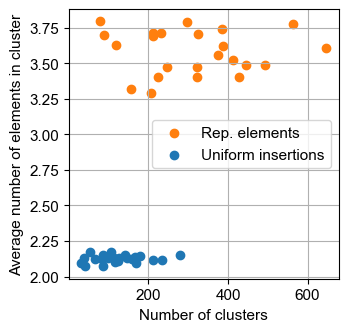

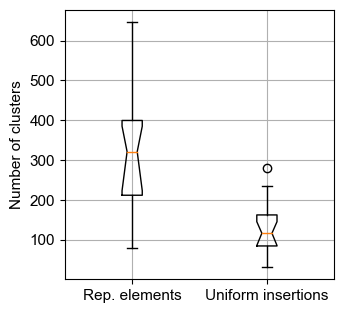

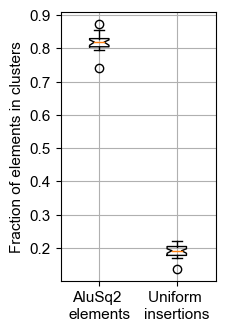

mean cluster number: 3.5787975446014237
mean rd cluster number: 2.1246149089583275


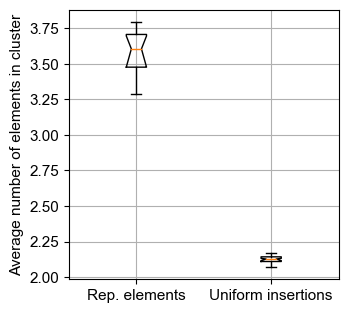

In [36]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.scatter(n_clusters_3,mean_cluster_number_3,label="Rep. elements",color="tab:orange")
ax1.scatter(n_clusters_rd_3,mean_cluster_number_rd_3,label="Uniform insertions",color="tab:blue")

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Average number of elements in cluster",fontname = "Arial",fontsize=11)
plt.xlabel("Number of clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
plt.show()


######################
######################
fliers=True

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([n_clusters_3,n_clusters_rd_3],labels=["Rep. elements","Uniform insertions"],showfliers=fliers,notch=True,bootstrap=10000)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Number of clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_3/figures/num_clusters_e4_3_3.pdf",format="pdf",bbox_inches="tight")
plt.show()

####################
####################


#fig=plt.figure(figsize=(3.5,3.5))
fig=plt.figure(figsize=(2,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([perc_in_cluster_3,perc_in_cluster_rd_3],labels=["AluSq2 \nelements","Uniform \ninsertions"],showfliers=fliers,notch=True,widths=0.25,bootstrap=10000)

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Fraction of elements in clusters",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_AluSq2_frac_in_clusters_e4_2_2.pdf",format="pdf",bbox_inches="tight")

plt.show()

###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

ax1.boxplot([mean_cluster_number_3,mean_cluster_number_rd_3],labels=["Rep. elements","Uniform insertions"],showfliers=fliers,notch=True,bootstrap=10000)
print("mean cluster number:",np.mean(mean_cluster_number_3))
print("mean rd cluster number:",np.mean(mean_cluster_number_rd_3))
#print("max cluster number:",np.max(mean_cluster_number_3))
#print("max rd cluster number:",np.max(mean_cluster_number_rd_3))

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
plt.ylabel("Average number of elements in cluster",fontname = "Arial",fontsize=11)
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_3/figures/avg_num_in_clusters_e4_3_3.pdf",format="pdf",bbox_inches="tight")

plt.show()

In [37]:
#stat sign. for clusters 2-4 elem.
t_frac, p_value_frac=scipy.stats.mannwhitneyu(x=perc_in_cluster_3,y=perc_in_cluster_rd_3,alternative="two-sided")
print("Fraction of elements in clusters:",p_value_frac)

Fraction of elements in clusters: 6.6368856429973785e-09


# Correlations between ATAC seq peaks and TEs

https://genome.ucsc.edu/FAQ/FAQformat.html#format12
    chrom - Name of the chromosome (or contig, scaffold, etc.).
    
chromStart - The starting position of the feature in the chromosome or scaffold. The first base in a chromosome is numbered 0.
    
chromEnd - The ending position of the feature in the chromosome or scaffold. The chromEnd base is not included in the display of the feature. For example, the first 100 bases of a chromosome are defined as chromStart=0, chromEnd=100, and span the bases numbered 0-99.
    
name - Name given to a region (preferably unique). Use "." if no name is assigned.
    
score - Indicates how dark the peak will be displayed in the browser (0-1000). If all scores were "'0"' when the data were submitted to the DCC, the DCC assigned scores 1-1000 based on signal value. Ideally the average signalValue per base spread is between 100-1000.
    
strand - +/- to denote strand or orientation (whenever applicable). Use "." if no orientation is assigned.
signalValue - Measurement of overall (usually, average) enrichment for the region.
    
pValue - Measurement of statistical significance (-log10). Use -1 if no pValue is assigned.
    
qValue - Measurement of statistical significance using false discovery rate (-log10). Use -1 if no qValue is assigned.
    
peak - Point-source called for this peak; 0-based offset from chromStart. Use -1 if no point-source called.


In [38]:
def positions_elements_3(peak_input,chr_sel_name,chr_sel,chr_start,chr_stop):
    #peak_input: narrow peak file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    input_=peak_input[peak_input[chr_sel_name]==chr_sel]
    for i in range(len(input_)):
        pos_1=input_[i:i+1][chr_start].to_numpy()[0] + 0.5*(input_[i:i+1][chr_stop].to_numpy()[0]-input_[i:i+1][chr_start].to_numpy()[0])
        
        pos.append(pos_1)
    return np.asarray(pos)

In [39]:
def check_if_pos_1_in_range_pos_2_V1(chr_input,pos_1_input,pos_2_input,dist):
    fraction_in_range=[]
    for i in range(len(chr_input)): #select chr
        fraction_in_range_e=[]
        for j in range(len(pos_1_input[i])): #select point on chr
            #k=0
            #s=0
            
            if np.min( np.abs(pos_1_input[i][j]-pos_2_input[i]) ) <=dist: #get all distances from point on chr to all points on same chr in pos_2
                fraction_in_range_e.append(1)
            else:
                fraction_in_range_e.append(0)
        fraction_in_range.append(fraction_in_range_e)

        
    return fraction_in_range

# Chr Accessibility, ENCODE
### https://www.encodeproject.org/annotations/ENCSR236YNV/



### http://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg19&g=wgEncodeOpenChromSynth
validated, OC Code = 1:

        Black: Regions identified as peaks by both the DNaseI HS assay and FAIRE assay. Peaks for DNaseI HS have DNase peak calling p-values < 0.05 (-log10(p-value) > 1.3) and peaks for FAIRE have FAIRE peak calling p-values < 0.1 (-log10(p-value) > 1.0). 


Open Chromatin, OC Code = 2 or 3:

        Blue (high significance): Regions not identified as peaks in both DNaseI HS and FAIRE, but for which the combination of peak calling p-values from these assays using Fisher's combined probability test results in a p-value < 0.01 (-log10(p-value) > 2).


DNase, OC Code = 2:

        Green (low significance): Regions identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)) and not identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


FAIRE, OC Code = 3:

        Dark Red (low significance): Regions identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)) and not identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


ChIP-seq, OC Code = 4:

        Pink: Regions identified by ChIP-seq as peaks (at least one of the peak calling p-values for the three ChIP experiments are < 0.05 (-log10(p-value) > 1.3)) indicating binding sites for one or more of RNA Pol II, CTCF, and c-Myc described here and not identified by DNaseI HS or FAIRE as peaks. Peaks for ChIP-seq have p-values < 0.05 (-log10(p-value) > 1.3). For RNA Pol II, only sites that overlap annotated transcription start sites by the UCSC Genes track are considered. 

All signal values, -log10(p-values), and the OC Code are displayed on the detail page for each element and are available in the corresponding bed file. 

In [40]:
Chr_acc_peaks=pd.read_csv("Transposon_analysis_1/DNAse_I_ENCFF001UZS/HelaS3_OC.bed",sep="\t",header = None)

Chr_acc_peaks.columns = ["chrom","chromStart","chromEnd","name","score","strand","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]

In [41]:
Chr_acc_peaks[:]

chrom  chromStart  chromEnd             name  score strand         6  \
0        chr1       10066     10205      FAIREOnly_1   1000      .     10066   
1        chr1       91424     91492       ChIPOnly_1   1000      .     91424   
2        chr1      104923    105070       ChIPOnly_2   1000      .    104923   
3        chr1      237670    237859       ChIPOnly_3   1000      .    237670   
4        chr1      251235    251368       ChIPOnly_4   1000      .    251235   
...       ...         ...       ...              ...    ...    ...       ...   
258213  chr21    48081488  48081897  OpenChrom_11606   1000      .  48081488   
258214  chr21    48082398  48082558  DNaseOnly_77095   1000      .  48082398   
258215  chr21    48082935  48083351  DNaseOnly_77096   1000      .  48082935   
258216  chr21    48087873  48088015  DNaseOnly_77097   1000      .  48087873   
258217  chr21    48088111  48088281  DNaseOnly_77098   1000      .  48088111   

               7          8     9  ...    11      12    13      14   15  \
0          10205    153,0,0  1.34  ...  0.00  0.0176  2.11  0.0000  0.0   
1          91492  255,0,255  0.00  ...  0.00  0.0005  0.00  0.0000  0.0   
2         105070  255,0,255  0.00  ...  0.00  0.0017  0.00  0.0000  0.0   
3         237859  255,0,255  0.00  ...  0.00  0.0017  0.00  0.0000  0.0   
4         251368  255,0,255  0.00  ...  0.00  0.0011  0.00  0.0029  0.0   
...          ...        ...   ...  ...   ...     ...   ...     ...  ...   
258213  48081897    0,0,255  2.15  ...  3.05  0.0053  0.00  0.0078  0.0   
258214  48082558    0,153,0  0.82  ...  1.46  0.0024  0.00  0.0064  0.0   
258215  48083351    0,153,0  0.97  ...  1.65  0.0080  0.00  0.0146  0.0   
258216  48088015    0,153,0  0.74  ...  1.35  0.0057  0.00  0.0129  0.0   
258217  48088281    0,153,0  0.74  ...  1.36  0.0050  0.00  0.0038  0.0   

            16    17      18   19  20  
0       0.0175  0.00  0.0140  0.0   3  
1       0.0958  1.60  0.0013  0.0   4  
2       0.3310  4.55  0.0000  0.0   4  
3       0.3424  4.68  0.0042  0.0   4  
4       0.2762  3.88  0.0000  0.0   4  
...        ...   ...     ...  ...  ..  
258213  0.0064  0.00  0.0000  0.0   2  
258214  0.0064  0.00  0.0137  0.0   2  
258215  0.0619  1.14  0.0102  0.0   2  
258216  0.0056  0.00  0.0079  0.0   2  
258217  0.0025  0.00  0.0139  0.0   2  

[258218 rows x 21 columns]

In [42]:
#Chr_acc_peaks_sel1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("Valid")]
#Chr_acc_peaks_sel1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("OpenChrom")]
#Chr_acc_peaks_sel1=Chr_acc_peaks

Chr_acc_peaks_sel1_p1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("Valid")]
Chr_acc_peaks_sel1_p2=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("OpenChrom")]
Chr_acc_peaks_sel1=pd.concat([Chr_acc_peaks_sel1_p1,Chr_acc_peaks_sel1_p2])

In [43]:
Chr_acc_peaks_sel1

chrom  chromStart  chromEnd             name  score strand         6  \
7        chr1      713850    714460          Valid_1   1000      .    713850   
13       chr1      761903    763244          Valid_2   1000      .    761903   
30       chr1      841391    842575          Valid_3   1000      .    841391   
32       chr1      845956    847166          Valid_4   1000      .    845956   
37       chr1      853094    853481          Valid_5   1000      .    853094   
...       ...         ...       ...              ...    ...    ...       ...   
258047  chr21    47415122  47416071  OpenChrom_11602   1000      .  47415122   
258115  chr21    47604142  47605091  OpenChrom_11603   1000      .  47604142   
258118  chr21    47611090  47611527  OpenChrom_11604   1000      .  47611090   
258203  chr21    48023077  48023411  OpenChrom_11605   1000      .  48023077   
258213  chr21    48081488  48081897  OpenChrom_11606   1000      .  48081488   

               7        8      9  ...     11      12    13      14     15  \
7         714460    0,0,0   8.19  ...   8.29  0.0126  1.26  0.1502   7.06   
13        763244    0,0,0  15.95  ...  16.00  0.0142  1.52  0.2604  12.10   
30        842575    0,0,0   9.85  ...   9.42  0.0162  1.86  0.0530   2.61   
32        847166    0,0,0   4.64  ...   4.16  0.0149  1.64  0.0171   0.00   
37        853481    0,0,0   1.76  ...   1.59  0.0110  1.01  0.0284   1.46   
...          ...      ...    ...  ...    ...     ...   ...     ...    ...   
258047  47416071  0,0,255   2.77  ...   3.75  0.0078  0.00  0.0040   0.00   
258115  47605091  0,0,255   4.32  ...   4.51  0.0105  0.94  0.0225   0.00   
258118  47611527  0,0,255   2.59  ...   3.55  0.0069  0.00  0.0097   0.00   
258203  48023411  0,0,255   2.20  ...   3.11  0.0104  0.00  0.0111   0.00   
258213  48081897  0,0,255   2.15  ...   3.05  0.0053  0.00  0.0078   0.00   

            16    17      18    19  20  
7       0.1080  1.76  0.0274  0.00   1  
13      0.1122  1.82  0.0704  2.93   1  
30      0.0155  0.00  0.0523  0.00   1  
32      0.0546  0.00  0.0249  0.00   1  
37      0.0239  0.00  0.0101  0.00   1  
...        ...   ...     ...   ...  ..  
258047  0.0116  0.00  0.0068  0.00   2  
258115  0.0108  0.00  0.0092  0.00   2  
258118  0.0184  0.00  0.0362  0.00   2  
258203  0.0385  0.00  0.0013  0.00   2  
258213  0.0064  0.00  0.0000  0.00   2  

[65564 rows x 21 columns]

In [44]:
11606 +53958 

65564

In [45]:
peak_len_1=Chr_acc_peaks_sel1[:]["chromEnd"] -Chr_acc_peaks_sel1[:]["chromStart"]

mean peak length: 683.2452260386798
median peak length: 491.0
min peak length: 30
max peak length: 13988


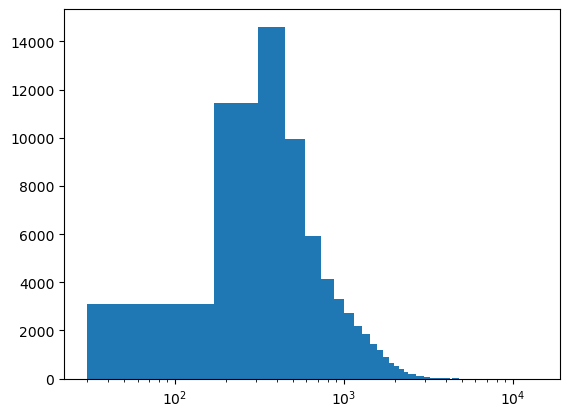

In [46]:
plt.hist(peak_len_1,bins=100)
plt.xscale("log")
print("mean peak length:",np.mean(peak_len_1))
print("median peak length:",np.median(peak_len_1))

print("min peak length:",np.min(peak_len_1))
print("max peak length:",np.max(peak_len_1))

In [47]:
Chr_acc_peaks_all_chrs=[]
for i in range(len(chr_list_3)):
    Chr_acc_peaks_all_chrs.append(positions_elements_3(peak_input=Chr_acc_peaks_sel1,chr_sel_name="chrom",chr_sel=chr_list_3[i],chr_start="chromStart",chr_stop="chromEnd"))
    
    

In [48]:
#elements
#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements  #cluster_centers_all_3, pos_x_list_3
fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=pos_x_list_3,dist=1000)

In [49]:
# cluster centres

#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements  #cluster_centers_all_3, pos_x_list_3
fraction_in_range_cluster_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=cluster_centers_all_3,dist=1000)

In [50]:
#homogeneous position
#fraction of input_1 elements in proximity to input_2 elements
#fraction_in_range_2_rd=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_1_input=Chr_acc_peaks_all_chrs,pos_2_input=pos_rd_x_list_3,dist=10000)

#fraction of input_2 elements in proximity to input_1 elements
fraction_in_range_2_rd=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=pos_rd_x_list_3,dist=1000)

In [51]:
fraction_in_range_2_mean=[]
for i in range(len(fraction_in_range_2)):
    fraction_in_range_2_mean.append(np.mean(fraction_in_range_2[i]))
    
    
fraction_in_range_cluster_2_mean=[]
for i in range(len(fraction_in_range_cluster_2)):
    fraction_in_range_cluster_2_mean.append(np.mean(fraction_in_range_cluster_2[i]))
    
fraction_in_range_2_rd_mean=[]
for i in range(len(fraction_in_range_2_rd)):
    fraction_in_range_2_rd_mean.append(np.mean(fraction_in_range_2_rd[i]))
    


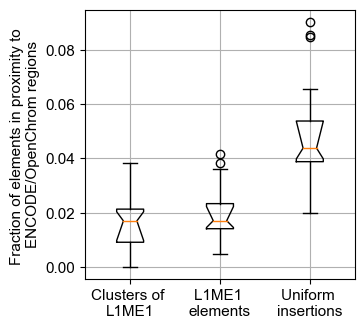

In [52]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

#ax1.boxplot([fraction_in_range_2_mean,fraction_in_range_2_rd_mean],labels=["Rep. elements","Hom. positions"],showfliers=True,notch=True,bootstrap=1000)


ax1.boxplot([fraction_in_range_cluster_2_mean,fraction_in_range_2_mean,fraction_in_range_2_rd_mean],labels=["Clusters of \nL1ME1","L1ME1 \nelements","Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_1.pdf",format="pdf",bbox_inches="tight")
#plt.show()

In [53]:
print(len(pos_rd_x_list_3[10]))
print(len(pos_x_list_3[10]))

1354
1354


# Proximity TE clusters to open chr by number of cluster elements

In [54]:
eps_3b=1e4
min_samples_3b=2
points_in_clusters_3b=[[2,5],[5,10000000]]


#[chr][cluster_centres_range_1,2,...]
#centres_clusters_by_range_all_chr_3,noise_all_chr_3,centres_clusters_by_range_rd_all_chr_3,noise_all_chr_rd_3=DB_scan_appl_4(eps=eps_3b,min_samples=min_samples_3b,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3,points_in_clusters=points_in_clusters_3b)

#centres_clusters_by_range_all_chr_3,sizes_clusters_by_range_all_chr_3,noise_all_chr_3,centres_clusters_by_range_rd_all_chr_3,sizes_clusters_by_range_rd_all_chr_3,noise_all_chr_rd_3=DB_scan_appl_6(eps=eps_3b,min_samples=min_samples_3b,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3,points_in_clusters=points_in_clusters_3b)
centres_clusters_by_range_all_chr_3,sizes_clusters_by_range_all_chr_3,noise_all_chr_3,noise_size_all_chr_3,centres_clusters_by_range_rd_all_chr_3,sizes_clusters_by_range_rd_all_chr_3,noise_all_chr_rd_3,noise_size_chr_rd_3=DB_scan_appl_8(eps=eps_3b,min_samples=min_samples_3b,chr_list=chr_list_3,pos_x_list=pos_x_list_3,pos_rd_x_list=pos_rd_x_list_3,len_x_list=len_x_list_3,points_in_clusters=points_in_clusters_3b)



In [55]:
#select range interval and split data by chromosomes

dist_for_prox=1000
range_sel_u=0
clusters_in_range_cluster_element_range_1=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=[sublist[range_sel_u] for sublist in centres_clusters_by_range_all_chr_3],dist=dist_for_prox)



range_sel_u=1
clusters_in_range_cluster_element_range_2=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=[sublist[range_sel_u] for sublist in centres_clusters_by_range_all_chr_3],dist=dist_for_prox)


noise_in_range_1=check_if_pos_1_in_range_pos_2_V1(chr_input=chr_list_3,pos_2_input=Chr_acc_peaks_all_chrs,pos_1_input=noise_all_chr_3,dist=dist_for_prox)

In [56]:
clusters_in_range_cluster_element_range_1_mean=[]
for i in range(len(clusters_in_range_cluster_element_range_1)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(clusters_in_range_cluster_element_range_1[i])>0:
        clusters_in_range_cluster_element_range_1_mean.append(np.mean(clusters_in_range_cluster_element_range_1[i]))
    
    
clusters_in_range_cluster_element_range_2_mean=[]
for i in range(len(clusters_in_range_cluster_element_range_2)):
    if len(clusters_in_range_cluster_element_range_2[i])>0:
        clusters_in_range_cluster_element_range_2_mean.append(np.mean(clusters_in_range_cluster_element_range_2[i]))
    
noise_in_range_1_mean=[]
for i in range(len(noise_in_range_1)):
    if len(noise_in_range_1[i])>0:
        noise_in_range_1_mean.append(np.mean(noise_in_range_1[i]))    

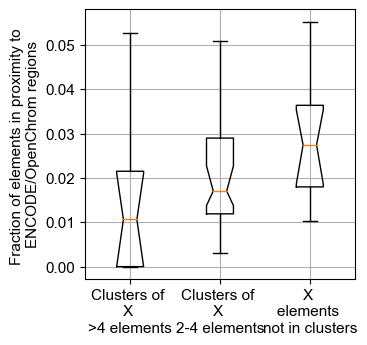

In [57]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([clusters_in_range_cluster_element_range_2_mean,clusters_in_range_cluster_element_range_1_mean,noise_in_range_1_mean],labels=["Clusters of \nX \n>4 elements","Clusters of \nX \n2-4 elements","X \nelements \nnot in clusters"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_1.pdf",format="pdf",bbox_inches="tight")
#plt.show()

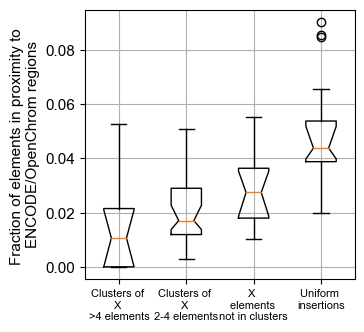

In [58]:
###################
###################
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([clusters_in_range_cluster_element_range_2_mean,clusters_in_range_cluster_element_range_1_mean,noise_in_range_1_mean,fraction_in_range_2_rd_mean],labels=["Clusters of \nX \n>4 elements","Clusters of \nX \n2-4 elements","X \nelements \nnot in clusters","Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=8) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())
#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_2.pdf",format="pdf",bbox_inches="tight")
#plt.show()

In [59]:
cl_num=[clusters_in_range_cluster_element_range_2,clusters_in_range_cluster_element_range_1,noise_in_range_1,fraction_in_range_2_rd]

for i in range(len(cl_num)):
    print("############")
    print("cluster size",i)
    
    for j in range(len(cl_num[i])):
        print("elements in",chr_list_3[j],":",len(cl_num[i][j]))
        
    print(np.sum(np.sum(cl_num[i])))

############
cluster size 0
elements in chr1 : 146
elements in chr2 : 159
elements in chr3 : 102
elements in chr4 : 90
elements in chr5 : 94
elements in chr6 : 95
elements in chr7 : 95
elements in chr8 : 75
elements in chr9 : 68
elements in chr10 : 92
elements in chr11 : 78
elements in chr12 : 86
elements in chr13 : 61
elements in chr14 : 65
elements in chr15 : 47
elements in chr16 : 37
elements in chr17 : 53
elements in chr18 : 55
elements in chr19 : 30
elements in chr20 : 33
elements in chr21 : 23
elements in chr22 : 19
elements in chrX : 87
19
############
cluster size 1
elements in chr1 : 418
elements in chr2 : 488
elements in chr3 : 390
elements in chr4 : 337
elements in chr5 : 352
elements in chr6 : 317
elements in chr7 : 290
elements in chr8 : 248
elements in chr9 : 253
elements in chr10 : 295
elements in chr11 : 218
elements in chr12 : 238
elements in chr13 : 186
elements in chr14 : 167
elements in chr15 : 176
elements in chr16 : 169
elements in chr17 : 158
elements in chr18 : 

/home/aaron/miniconda3/envs/general2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [60]:
len(clusters_in_range_cluster_element_range_2)

23

# Check for overlap with full legth of transposons and open chromatin regions

In [61]:
#https://stackoverflow.com/questions/16691524/calculating-the-overlap-distance-of-two-1d-line-segments
def calc_overlap(min1, max1, min2, max2):
    return max(0, min(max1, max2) - max(min1, min2))

#overlap for arrays
def calc_overlap_V2(max1, max2, min1, min2):
    result = np.maximum(0, np.minimum(max1, max2) - np.maximum(min1, min2))
    return result
#overlap for arrays, with distance separation if no overlap
def calc_overlap_V3(max1, max2, min1, min2):
    result = np.minimum(max1, max2) - np.maximum(min1, min2)
    return result

#check for each element in df1 if at least on element in df2 overlaps it (on the same chr)
def check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1, df2, chr_name_1,start_name_1,stop_name_1, chr_name_2,start_name_2,stop_name_2,min_dist=0):
    
    bool_overlap_entries=[] #if at least one element in df2 overlaps element i in df1
    
    for i in range(len(df1)):
        #get chr, start and stop of entry in df1
        chr_sel=df1.iloc[i][chr_name_1]
        start_sel=df1.iloc[i][start_name_1]
        stop_sel=df1.iloc[i][stop_name_1]
        
        #select sub dataframe on df2 with same chr
        df2_sel_chr=df2[df2[chr_name_2]==chr_sel]
        
        
        ###
        #get arrays of all start and stop points on chr
        start_sel_df2=df2_sel_chr.iloc[:][start_name_2].to_numpy()
        stop_sel_df2=df2_sel_chr.iloc[:][stop_name_2].to_numpy()
        
        overlap_array=calc_overlap_V3(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
        ###
        bool_overlap_e=0
        if any(x > min_dist for x in overlap_array):
            bool_overlap_e=1
        
        
        '''#check if element in df2 on same chr overlaps selected element in df1
        bool_overlap_e=0
        for j in range(len(df2_sel_chr)):
            start_sel_df2=df2_sel_chr.iloc[j][start_name_2]
            stop_sel_df2=df2_sel_chr.iloc[j][stop_name_2]
            #print(start_sel,stop_sel,"#",start_sel_df2,stop_sel_df2)
            
            overlap=calc_overlap(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
            if overlap>0:
                bool_overlap_e=1
                break'''

        bool_overlap_entries.append(bool_overlap_e) 
        print(i,"/",len(df1)-1)
    return bool_overlap_entries

def gen_df_with_random_positions_1(df1,chr_name,start_name,stop_name,chr_name_length_dict):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    #df_rd=pd.DataFrame(columns=col_create)
    chr_sel_list=[]
    rd_start_list=[]
    rd_stop_list=[]
    rd_id_list=[]
    for i in range(len(df1)):
        #get chr, start and stop of entry in df1
        chr_sel=df1.iloc[i][chr_name]
        start_sel=df1.iloc[i][start_name]
        stop_sel=df1.iloc[i][stop_name]
        
        elem_len=stop_sel-start_sel
        
        chr_len_sel=chr_name_length_dict[chr_sel[3:]] #get number behind chr1
        
        rd_middle=np.random.choice( np.arange(  0,int( np.round(chr_len_sel - elem_len/2,0) )  ) )
        
        rd_start= int(  np.round(rd_middle-elem_len/2,0))
        rd_stop=int(  np.round(rd_middle+elem_len/2,0))
        
        chr_sel_list.append(chr_sel)
        rd_start_list.append(rd_start)
        rd_stop_list.append(rd_stop)
        rd_id_list.append(i)
        
        #print(chr_sel,rd_start)
        
        #df_rd.append({col_create[0]:i, col_create[1]:chr_sel, col_create[2]:rd_start, col_create[3]:rd_stop},ignore_index=True)
        
    all_data={col_create[0]:rd_id_list,
             col_create[1]:chr_sel_list,
             col_create[2]:rd_start_list,
             col_create[3]:rd_stop_list}  
    
    df_rd=pd.DataFrame(all_data)
    return df_rd   
    

In [62]:

#create df from chr_list, pos_list and len_list with id, chrom, start, stop, columns
def df_for_rd_positions_V1(chr_list, pos_rd_x_list, len_x_list):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)):
        #get chr
        chr_sel_list=[]
        rd_start_list=[]
        rd_stop_list=[]
        rd_id_list=[]
        count_1=0
    
        chr_sel=chr_list[i]
        for j in range(len(pos_rd_x_list[i])):
            #get pos
            start_sel=int(np.round(pos_rd_x_list[i][j]-len_x_list[i][j]/2 ,0))
            stop_sel=int(np.round(pos_rd_x_list[i][j]+len_x_list[i][j]/2 ,0))
            
            chr_sel_list.append(chr_sel)
            rd_start_list.append(start_sel)
            rd_stop_list.append(stop_sel)
            rd_id_list.append(count_1)
            count_1=count_1+1
            
        all_data={col_create[0]:rd_id_list,
             col_create[1]:chr_sel_list,
             col_create[2]:rd_start_list,
             col_create[3]:rd_stop_list}  
    
        df_rd=pd.DataFrame(all_data)
        df_rd_list.append(df_rd)
    return df_rd_list  
    

In [63]:

#create df with cluster id, chrom, start and stop
#for chromosome and each detected cluster list for specified range of points (e.g. all cluster with 2-4 and all with >4 points) 
def df_for_cluster_positions_V1(chr_list,centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)): #chromosomes
        #get chr
 
        
    
        chr_sel=chr_list[i]
        df_rd_cluster_list=[]
        for j in range(len(centres_clusters_by_range_all_chr[i])): #cluster sizes
            count_1=0
            chr_sel_list=[]
            rd_start_list=[]
            rd_stop_list=[]
            rd_id_list=[]
            all_data={}
            for k in range(len(centres_clusters_by_range_all_chr[i][j])): #entries for each cluster size
                
                start_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]-sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))
                stop_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]+sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))

                chr_sel_list.append(chr_sel)
                rd_start_list.append(start_sel)
                rd_stop_list.append(stop_sel)
                rd_id_list.append(count_1)
                count_1=count_1+1

                all_data={col_create[0]:rd_id_list,
                     col_create[1]:chr_sel_list,
                     col_create[2]:rd_start_list,
                     col_create[3]:rd_stop_list}  
    
            df_rd=pd.DataFrame(all_data)
            df_rd_cluster_list.append(df_rd)
        df_rd_list.append(df_rd_cluster_list)
    return df_rd_list 


In [64]:
#df with random, hom. distr. points (have same lengths as transposons)
df_rd_pos_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=pos_rd_x_list_3, len_x_list=len_x_list_3)

In [65]:
print(np.mean([i for j in len_x_list_3 for i in j]))

480.5730630716767


In [66]:
#df for cluster positions split by chr and by number of points in cluster
df_cluster_pos_3=df_for_cluster_positions_V1(chr_list=chr_list_3,centres_clusters_by_range_all_chr=centres_clusters_by_range_all_chr_3,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_all_chr_3)

In [67]:
#df for points not in clusters (same funtion as for rd points)
df_no_cluster_pos_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=noise_all_chr_3, len_x_list=noise_size_all_chr_3)

In [68]:
print(np.mean([i for j in noise_size_all_chr_3 for i in j]))

463.0964927586809


In [69]:
#df for random cluster positions split by chr and by number of points in cluster
df_cluster_pos_rd_3=df_for_cluster_positions_V1(chr_list=chr_list_3,centres_clusters_by_range_all_chr=centres_clusters_by_range_rd_all_chr_3,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_rd_all_chr_3)

In [70]:
#test_1111=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_rd_3[0][0], df2=df_cluster_pos_rd_3[0][1], chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=0)

In [71]:
#df for random points not in clusters
df_no_cluster_pos_rd_3=df_for_rd_positions_V1(chr_list=chr_list_3, pos_rd_x_list=noise_all_chr_rd_3, len_x_list=noise_size_chr_rd_3)

In [72]:
print(np.mean([i for j in noise_size_chr_rd_3 for i in j]))

479.7147709320695


In [73]:
#lengths of transposon clusters
length_cluster_1=[]
for i in range(len(sizes_clusters_by_range_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_all_chr_3[i][0])):
        length_cluster_1.append(sizes_clusters_by_range_all_chr_3[i][0][j])
 
print("mean length clusters 2-4:",np.mean(length_cluster_1))

length_cluster_2=[]
for i in range(len(sizes_clusters_by_range_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_all_chr_3[i][1])):
        length_cluster_2.append(sizes_clusters_by_range_all_chr_3[i][1][j])
 
print("mean length clusters >4:",np.mean(length_cluster_2))

length_cluster_all=np.concatenate((length_cluster_1,length_cluster_2))
print("mean+std length all clusters:",np.mean(length_cluster_all),",",np.std(length_cluster_all))
print("max, min length all clusters:",np.max(length_cluster_all),",",np.min(length_cluster_all))

mean length clusters 2-4: 2492.9958029197082
mean length clusters >4: 7102.226035502958
mean+std length all clusters: 3579.41129707113 , 3461.7441694688323
max, min length all clusters: 31645.0 , 117.0


In [92]:
#lengths of clusters of hom. distr. points
length_rd_cluster_1=[]
for i in range(len(sizes_clusters_by_range_rd_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_rd_all_chr_3[i][0])):
        length_rd_cluster_1.append(sizes_clusters_by_range_rd_all_chr_3[i][0][j])
 
print("mean length clusters 2-4:",np.mean(length_rd_cluster_1))

length_rd_cluster_2=[]
for i in range(len(sizes_clusters_by_range_rd_all_chr_3)):
    for j in range(len(sizes_clusters_by_range_rd_all_chr_3[i][1])):
        length_rd_cluster_2.append(sizes_clusters_by_range_rd_all_chr_3[i][1][j])
 
print("mean length clusters >4:",np.mean(length_rd_cluster_2))

length_rd_cluster_all=np.concatenate((length_rd_cluster_1,length_rd_cluster_2))
print("mean+std length all clusters:",np.mean(length_rd_cluster_all),",",np.std(length_rd_cluster_all))
print("max, min length all clusters:",np.max(length_rd_cluster_all),",",np.min(length_rd_cluster_all))

mean length clusters 2-4: 6107.089310829817
mean length clusters >4: 19704.5
mean+std length all clusters: 6126.186797752809 , 3648.93312134179
max, min length all clusters: 28731.0 , 222.0


In [75]:
#maximum separation between closet points of regions
max_sep_regions=0 #-1000

In [76]:
%%time
#overlap of clusters with open chromatin
mean_overlap_clusters=[]
for i in range(len(chr_list_3)):
    mean_overlap_clusters_e=[]
    for j in range(len(df_cluster_pos_3[i])):
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_3[i][j], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
        mean_overlap_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_clusters.append(mean_overlap_clusters_e)

0 / 417
1 / 417
2 / 417
3 / 417
4 / 417
5 / 417
6 / 417
7 / 417
8 / 417
9 / 417
10 / 417
11 / 417
12 / 417
13 / 417
14 / 417
15 / 417
16 / 417
17 / 417
18 / 417
19 / 417
20 / 417
21 / 417
22 / 417
23 / 417
24 / 417
25 / 417
26 / 417
27 / 417
28 / 417
29 / 417
30 / 417
31 / 417
32 / 417
33 / 417
34 / 417
35 / 417
36 / 417
37 / 417
38 / 417
39 / 417
40 / 417
41 / 417
42 / 417
43 / 417
44 / 417
45 / 417
46 / 417
47 / 417
48 / 417
49 / 417
50 / 417
51 / 417
52 / 417
53 / 417
54 / 417
55 / 417
56 / 417
57 / 417
58 / 417
59 / 417
60 / 417
61 / 417
62 / 417
63 / 417
64 / 417
65 / 417
66 / 417
67 / 417
68 / 417
69 / 417
70 / 417
71 / 417
72 / 417
73 / 417
74 / 417
75 / 417
76 / 417
77 / 417
78 / 417
79 / 417
80 / 417
81 / 417
82 / 417
83 / 417
84 / 417
85 / 417
86 / 417
87 / 417
88 / 417
89 / 417
90 / 417
91 / 417
92 / 417
93 / 417
94 / 417
95 / 417
96 / 417
97 / 417
98 / 417
99 / 417
100 / 417
101 / 417
102 / 417
103 / 417
104 / 417
105 / 417
106 / 417
107 / 417
108 / 417
109 / 417
110 / 417


294 / 487
295 / 487
296 / 487
297 / 487
298 / 487
299 / 487
300 / 487
301 / 487
302 / 487
303 / 487
304 / 487
305 / 487
306 / 487
307 / 487
308 / 487
309 / 487
310 / 487
311 / 487
312 / 487
313 / 487
314 / 487
315 / 487
316 / 487
317 / 487
318 / 487
319 / 487
320 / 487
321 / 487
322 / 487
323 / 487
324 / 487
325 / 487
326 / 487
327 / 487
328 / 487
329 / 487
330 / 487
331 / 487
332 / 487
333 / 487
334 / 487
335 / 487
336 / 487
337 / 487
338 / 487
339 / 487
340 / 487
341 / 487
342 / 487
343 / 487
344 / 487
345 / 487
346 / 487
347 / 487
348 / 487
349 / 487
350 / 487
351 / 487
352 / 487
353 / 487
354 / 487
355 / 487
356 / 487
357 / 487
358 / 487
359 / 487
360 / 487
361 / 487
362 / 487
363 / 487
364 / 487
365 / 487
366 / 487
367 / 487
368 / 487
369 / 487
370 / 487
371 / 487
372 / 487
373 / 487
374 / 487
375 / 487
376 / 487
377 / 487
378 / 487
379 / 487
380 / 487
381 / 487
382 / 487
383 / 487
384 / 487
385 / 487
386 / 487
387 / 487
388 / 487
389 / 487
390 / 487
391 / 487
392 / 487
393 / 487


56 / 336
57 / 336
58 / 336
59 / 336
60 / 336
61 / 336
62 / 336
63 / 336
64 / 336
65 / 336
66 / 336
67 / 336
68 / 336
69 / 336
70 / 336
71 / 336
72 / 336
73 / 336
74 / 336
75 / 336
76 / 336
77 / 336
78 / 336
79 / 336
80 / 336
81 / 336
82 / 336
83 / 336
84 / 336
85 / 336
86 / 336
87 / 336
88 / 336
89 / 336
90 / 336
91 / 336
92 / 336
93 / 336
94 / 336
95 / 336
96 / 336
97 / 336
98 / 336
99 / 336
100 / 336
101 / 336
102 / 336
103 / 336
104 / 336
105 / 336
106 / 336
107 / 336
108 / 336
109 / 336
110 / 336
111 / 336
112 / 336
113 / 336
114 / 336
115 / 336
116 / 336
117 / 336
118 / 336
119 / 336
120 / 336
121 / 336
122 / 336
123 / 336
124 / 336
125 / 336
126 / 336
127 / 336
128 / 336
129 / 336
130 / 336
131 / 336
132 / 336
133 / 336
134 / 336
135 / 336
136 / 336
137 / 336
138 / 336
139 / 336
140 / 336
141 / 336
142 / 336
143 / 336
144 / 336
145 / 336
146 / 336
147 / 336
148 / 336
149 / 336
150 / 336
151 / 336
152 / 336
153 / 336
154 / 336
155 / 336
156 / 336
157 / 336
158 / 336
159 / 336
160 

161 / 316
162 / 316
163 / 316
164 / 316
165 / 316
166 / 316
167 / 316
168 / 316
169 / 316
170 / 316
171 / 316
172 / 316
173 / 316
174 / 316
175 / 316
176 / 316
177 / 316
178 / 316
179 / 316
180 / 316
181 / 316
182 / 316
183 / 316
184 / 316
185 / 316
186 / 316
187 / 316
188 / 316
189 / 316
190 / 316
191 / 316
192 / 316
193 / 316
194 / 316
195 / 316
196 / 316
197 / 316
198 / 316
199 / 316
200 / 316
201 / 316
202 / 316
203 / 316
204 / 316
205 / 316
206 / 316
207 / 316
208 / 316
209 / 316
210 / 316
211 / 316
212 / 316
213 / 316
214 / 316
215 / 316
216 / 316
217 / 316
218 / 316
219 / 316
220 / 316
221 / 316
222 / 316
223 / 316
224 / 316
225 / 316
226 / 316
227 / 316
228 / 316
229 / 316
230 / 316
231 / 316
232 / 316
233 / 316
234 / 316
235 / 316
236 / 316
237 / 316
238 / 316
239 / 316
240 / 316
241 / 316
242 / 316
243 / 316
244 / 316
245 / 316
246 / 316
247 / 316
248 / 316
249 / 316
250 / 316
251 / 316
252 / 316
253 / 316
254 / 316
255 / 316
256 / 316
257 / 316
258 / 316
259 / 316
260 / 316


42 / 74
43 / 74
44 / 74
45 / 74
46 / 74
47 / 74
48 / 74
49 / 74
50 / 74
51 / 74
52 / 74
53 / 74
54 / 74
55 / 74
56 / 74
57 / 74
58 / 74
59 / 74
60 / 74
61 / 74
62 / 74
63 / 74
64 / 74
65 / 74
66 / 74
67 / 74
68 / 74
69 / 74
70 / 74
71 / 74
72 / 74
73 / 74
74 / 74
0 / 252
1 / 252
2 / 252
3 / 252
4 / 252
5 / 252
6 / 252
7 / 252
8 / 252
9 / 252
10 / 252
11 / 252
12 / 252
13 / 252
14 / 252
15 / 252
16 / 252
17 / 252
18 / 252
19 / 252
20 / 252
21 / 252
22 / 252
23 / 252
24 / 252
25 / 252
26 / 252
27 / 252
28 / 252
29 / 252
30 / 252
31 / 252
32 / 252
33 / 252
34 / 252
35 / 252
36 / 252
37 / 252
38 / 252
39 / 252
40 / 252
41 / 252
42 / 252
43 / 252
44 / 252
45 / 252
46 / 252
47 / 252
48 / 252
49 / 252
50 / 252
51 / 252
52 / 252
53 / 252
54 / 252
55 / 252
56 / 252
57 / 252
58 / 252
59 / 252
60 / 252
61 / 252
62 / 252
63 / 252
64 / 252
65 / 252
66 / 252
67 / 252
68 / 252
69 / 252
70 / 252
71 / 252
72 / 252
73 / 252
74 / 252
75 / 252
76 / 252
77 / 252
78 / 252
79 / 252
80 / 252
81 / 252
82 / 252

26 / 77
27 / 77
28 / 77
29 / 77
30 / 77
31 / 77
32 / 77
33 / 77
34 / 77
35 / 77
36 / 77
37 / 77
38 / 77
39 / 77
40 / 77
41 / 77
42 / 77
43 / 77
44 / 77
45 / 77
46 / 77
47 / 77
48 / 77
49 / 77
50 / 77
51 / 77
52 / 77
53 / 77
54 / 77
55 / 77
56 / 77
57 / 77
58 / 77
59 / 77
60 / 77
61 / 77
62 / 77
63 / 77
64 / 77
65 / 77
66 / 77
67 / 77
68 / 77
69 / 77
70 / 77
71 / 77
72 / 77
73 / 77
74 / 77
75 / 77
76 / 77
77 / 77
0 / 237
1 / 237
2 / 237
3 / 237
4 / 237
5 / 237
6 / 237
7 / 237
8 / 237
9 / 237
10 / 237
11 / 237
12 / 237
13 / 237
14 / 237
15 / 237
16 / 237
17 / 237
18 / 237
19 / 237
20 / 237
21 / 237
22 / 237
23 / 237
24 / 237
25 / 237
26 / 237
27 / 237
28 / 237
29 / 237
30 / 237
31 / 237
32 / 237
33 / 237
34 / 237
35 / 237
36 / 237
37 / 237
38 / 237
39 / 237
40 / 237
41 / 237
42 / 237
43 / 237
44 / 237
45 / 237
46 / 237
47 / 237
48 / 237
49 / 237
50 / 237
51 / 237
52 / 237
53 / 237
54 / 237
55 / 237
56 / 237
57 / 237
58 / 237
59 / 237
60 / 237
61 / 237
62 / 237
63 / 237
64 / 237
65 / 237


79 / 175
80 / 175
81 / 175
82 / 175
83 / 175
84 / 175
85 / 175
86 / 175
87 / 175
88 / 175
89 / 175
90 / 175
91 / 175
92 / 175
93 / 175
94 / 175
95 / 175
96 / 175
97 / 175
98 / 175
99 / 175
100 / 175
101 / 175
102 / 175
103 / 175
104 / 175
105 / 175
106 / 175
107 / 175
108 / 175
109 / 175
110 / 175
111 / 175
112 / 175
113 / 175
114 / 175
115 / 175
116 / 175
117 / 175
118 / 175
119 / 175
120 / 175
121 / 175
122 / 175
123 / 175
124 / 175
125 / 175
126 / 175
127 / 175
128 / 175
129 / 175
130 / 175
131 / 175
132 / 175
133 / 175
134 / 175
135 / 175
136 / 175
137 / 175
138 / 175
139 / 175
140 / 175
141 / 175
142 / 175
143 / 175
144 / 175
145 / 175
146 / 175
147 / 175
148 / 175
149 / 175
150 / 175
151 / 175
152 / 175
153 / 175
154 / 175
155 / 175
156 / 175
157 / 175
158 / 175
159 / 175
160 / 175
161 / 175
162 / 175
163 / 175
164 / 175
165 / 175
166 / 175
167 / 175
168 / 175
169 / 175
170 / 175
171 / 175
172 / 175
173 / 175
174 / 175
175 / 175
0 / 46
1 / 46
2 / 46
3 / 46
4 / 46
5 / 46
6 / 46
7 

117 / 122
118 / 122
119 / 122
120 / 122
121 / 122
122 / 122
0 / 32
1 / 32
2 / 32
3 / 32
4 / 32
5 / 32
6 / 32
7 / 32
8 / 32
9 / 32
10 / 32
11 / 32
12 / 32
13 / 32
14 / 32
15 / 32
16 / 32
17 / 32
18 / 32
19 / 32
20 / 32
21 / 32
22 / 32
23 / 32
24 / 32
25 / 32
26 / 32
27 / 32
28 / 32
29 / 32
30 / 32
31 / 32
32 / 32
0 / 65
1 / 65
2 / 65
3 / 65
4 / 65
5 / 65
6 / 65
7 / 65
8 / 65
9 / 65
10 / 65
11 / 65
12 / 65
13 / 65
14 / 65
15 / 65
16 / 65
17 / 65
18 / 65
19 / 65
20 / 65
21 / 65
22 / 65
23 / 65
24 / 65
25 / 65
26 / 65
27 / 65
28 / 65
29 / 65
30 / 65
31 / 65
32 / 65
33 / 65
34 / 65
35 / 65
36 / 65
37 / 65
38 / 65
39 / 65
40 / 65
41 / 65
42 / 65
43 / 65
44 / 65
45 / 65
46 / 65
47 / 65
48 / 65
49 / 65
50 / 65
51 / 65
52 / 65
53 / 65
54 / 65
55 / 65
56 / 65
57 / 65
58 / 65
59 / 65
60 / 65
61 / 65
62 / 65
63 / 65
64 / 65
65 / 65
0 / 22
1 / 22
2 / 22
3 / 22
4 / 22
5 / 22
6 / 22
7 / 22
8 / 22
9 / 22
10 / 22
11 / 22
12 / 22
13 / 22
14 / 22
15 / 22
16 / 22
17 / 22
18 / 22
19 / 22
20 / 22
21 / 22
22

In [77]:
%%time
#overlap of random clusters with open chromatin
mean_overlap_rd_clusters=[]
for i in range(len(chr_list_3)):
    mean_overlap_rd_clusters_e=[]
    for j in range(len(df_cluster_pos_rd_3[i])):
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_rd_3[i][j], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
        mean_overlap_rd_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_rd_clusters.append(mean_overlap_rd_clusters_e)

0 / 232
1 / 232
2 / 232
3 / 232
4 / 232
5 / 232
6 / 232
7 / 232
8 / 232
9 / 232
10 / 232
11 / 232
12 / 232
13 / 232
14 / 232
15 / 232
16 / 232
17 / 232
18 / 232
19 / 232
20 / 232
21 / 232
22 / 232
23 / 232
24 / 232
25 / 232
26 / 232
27 / 232
28 / 232
29 / 232
30 / 232
31 / 232
32 / 232
33 / 232
34 / 232
35 / 232
36 / 232
37 / 232
38 / 232
39 / 232
40 / 232
41 / 232
42 / 232
43 / 232
44 / 232
45 / 232
46 / 232
47 / 232
48 / 232
49 / 232
50 / 232
51 / 232
52 / 232
53 / 232
54 / 232
55 / 232
56 / 232
57 / 232
58 / 232
59 / 232
60 / 232
61 / 232
62 / 232
63 / 232
64 / 232
65 / 232
66 / 232
67 / 232
68 / 232
69 / 232
70 / 232
71 / 232
72 / 232
73 / 232
74 / 232
75 / 232
76 / 232
77 / 232
78 / 232
79 / 232
80 / 232
81 / 232
82 / 232
83 / 232
84 / 232
85 / 232
86 / 232
87 / 232
88 / 232
89 / 232
90 / 232
91 / 232
92 / 232
93 / 232
94 / 232
95 / 232
96 / 232
97 / 232
98 / 232
99 / 232
100 / 232
101 / 232
102 / 232
103 / 232
104 / 232
105 / 232
106 / 232
107 / 232
108 / 232
109 / 232
110 / 232


23 / 157
24 / 157
25 / 157
26 / 157
27 / 157
28 / 157
29 / 157
30 / 157
31 / 157
32 / 157
33 / 157
34 / 157
35 / 157
36 / 157
37 / 157
38 / 157
39 / 157
40 / 157
41 / 157
42 / 157
43 / 157
44 / 157
45 / 157
46 / 157
47 / 157
48 / 157
49 / 157
50 / 157
51 / 157
52 / 157
53 / 157
54 / 157
55 / 157
56 / 157
57 / 157
58 / 157
59 / 157
60 / 157
61 / 157
62 / 157
63 / 157
64 / 157
65 / 157
66 / 157
67 / 157
68 / 157
69 / 157
70 / 157
71 / 157
72 / 157
73 / 157
74 / 157
75 / 157
76 / 157
77 / 157
78 / 157
79 / 157
80 / 157
81 / 157
82 / 157
83 / 157
84 / 157
85 / 157
86 / 157
87 / 157
88 / 157
89 / 157
90 / 157
91 / 157
92 / 157
93 / 157
94 / 157
95 / 157
96 / 157
97 / 157
98 / 157
99 / 157
100 / 157
101 / 157
102 / 157
103 / 157
104 / 157
105 / 157
106 / 157
107 / 157
108 / 157
109 / 157
110 / 157
111 / 157
112 / 157
113 / 157
114 / 157
115 / 157
116 / 157
117 / 157
118 / 157
119 / 157
120 / 157
121 / 157
122 / 157
123 / 157
124 / 157
125 / 157
126 / 157
127 / 157
128 / 157
129 / 157
130 / 1

78 / 122
79 / 122
80 / 122
81 / 122
82 / 122
83 / 122
84 / 122
85 / 122
86 / 122
87 / 122
88 / 122
89 / 122
90 / 122
91 / 122
92 / 122
93 / 122
94 / 122
95 / 122
96 / 122
97 / 122
98 / 122
99 / 122
100 / 122
101 / 122
102 / 122
103 / 122
104 / 122
105 / 122
106 / 122
107 / 122
108 / 122
109 / 122
110 / 122
111 / 122
112 / 122
113 / 122
114 / 122
115 / 122
116 / 122
117 / 122
118 / 122
119 / 122
120 / 122
121 / 122
122 / 122
0 / 124
1 / 124
2 / 124
3 / 124
4 / 124
5 / 124
6 / 124
7 / 124
8 / 124
9 / 124
10 / 124
11 / 124
12 / 124
13 / 124
14 / 124
15 / 124
16 / 124
17 / 124
18 / 124
19 / 124
20 / 124
21 / 124
22 / 124
23 / 124
24 / 124
25 / 124
26 / 124
27 / 124
28 / 124
29 / 124
30 / 124
31 / 124
32 / 124
33 / 124
34 / 124
35 / 124
36 / 124
37 / 124
38 / 124
39 / 124
40 / 124
41 / 124
42 / 124
43 / 124
44 / 124
45 / 124
46 / 124
47 / 124
48 / 124
49 / 124
50 / 124
51 / 124
52 / 124
53 / 124
54 / 124
55 / 124
56 / 124
57 / 124
58 / 124
59 / 124
60 / 124
61 / 124
62 / 124
63 / 124
64 / 1

In [78]:
#get mean overlap percentages in each chromosome for 2-4 points and >4 points in clusters

min_num_points_cond=10
mean_overlap_clusters_range_1_mean=[]
for i in range(len(mean_overlap_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters[i][0])>min_num_points_cond:
        mean_overlap_clusters_range_1_mean.append(np.mean(mean_overlap_clusters[i][0]))
    
mean_overlap_clusters_range_2_mean=[]
for i in range(len(mean_overlap_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters[i][1])>min_num_points_cond:
        mean_overlap_clusters_range_2_mean.append(np.mean(mean_overlap_clusters[i][1]))
        
mean_overlap_cluster_range_all_mean=[]
for i in range(len(mean_overlap_clusters)):
    concat_overlap=np.concatenate((mean_overlap_clusters[i][0],mean_overlap_clusters[i][1]))
    if len(concat_overlap)>min_num_points_cond:
        mean_overlap_cluster_range_all_mean.append(np.mean(concat_overlap))
    
 
mean_overlap_rd_clusters_range_1_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters[i][0])>min_num_points_cond:
        mean_overlap_rd_clusters_range_1_mean.append(np.mean(mean_overlap_rd_clusters[i][0]))
    
mean_overlap_rd_clusters_range_2_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters[i][1])>min_num_points_cond:
        mean_overlap_rd_clusters_range_2_mean.append(np.mean(mean_overlap_rd_clusters[i][1]))

        
mean_overlap_rd_cluster_range_all_mean=[]
for i in range(len(mean_overlap_rd_clusters)):
    concat_overlap=np.concatenate((mean_overlap_rd_clusters[i][0],mean_overlap_rd_clusters[i][1]))
    if len(concat_overlap)>min_num_points_cond:
        mean_overlap_rd_cluster_range_all_mean.append(np.mean(concat_overlap))

In [79]:
%%time
#overlap all Tr positions or random positions with open chr
mean_overlap_tr_1=[]
mean_overlap_rd_1=[]
for i in range(len(chr_list_3)):
    overlap_tr_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=rmd_list_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="genoName",start_name_1="genoStart",stop_name_1="genoEnd", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    overlap_rd_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_rd_pos_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    
    mean_overlap_tr_1.append(overlap_tr_open_chr_e)
    mean_overlap_rd_1.append(overlap_rd_open_chr_e)
    

0 / 2526
1 / 2526
2 / 2526
3 / 2526
4 / 2526
5 / 2526
6 / 2526
7 / 2526
8 / 2526
9 / 2526
10 / 2526
11 / 2526
12 / 2526
13 / 2526
14 / 2526
15 / 2526
16 / 2526
17 / 2526
18 / 2526
19 / 2526
20 / 2526
21 / 2526
22 / 2526
23 / 2526
24 / 2526
25 / 2526
26 / 2526
27 / 2526
28 / 2526
29 / 2526
30 / 2526
31 / 2526
32 / 2526
33 / 2526
34 / 2526
35 / 2526
36 / 2526
37 / 2526
38 / 2526
39 / 2526
40 / 2526
41 / 2526
42 / 2526
43 / 2526
44 / 2526
45 / 2526
46 / 2526
47 / 2526
48 / 2526
49 / 2526
50 / 2526
51 / 2526
52 / 2526
53 / 2526
54 / 2526
55 / 2526
56 / 2526
57 / 2526
58 / 2526
59 / 2526
60 / 2526
61 / 2526
62 / 2526
63 / 2526
64 / 2526
65 / 2526
66 / 2526
67 / 2526
68 / 2526
69 / 2526
70 / 2526
71 / 2526
72 / 2526
73 / 2526
74 / 2526
75 / 2526
76 / 2526
77 / 2526
78 / 2526
79 / 2526
80 / 2526
81 / 2526
82 / 2526
83 / 2526
84 / 2526
85 / 2526
86 / 2526
87 / 2526
88 / 2526
89 / 2526
90 / 2526
91 / 2526
92 / 2526
93 / 2526
94 / 2526
95 / 2526
96 / 2526
97 / 2526
98 / 2526
99 / 2526
100 / 2526

825 / 2526
826 / 2526
827 / 2526
828 / 2526
829 / 2526
830 / 2526
831 / 2526
832 / 2526
833 / 2526
834 / 2526
835 / 2526
836 / 2526
837 / 2526
838 / 2526
839 / 2526
840 / 2526
841 / 2526
842 / 2526
843 / 2526
844 / 2526
845 / 2526
846 / 2526
847 / 2526
848 / 2526
849 / 2526
850 / 2526
851 / 2526
852 / 2526
853 / 2526
854 / 2526
855 / 2526
856 / 2526
857 / 2526
858 / 2526
859 / 2526
860 / 2526
861 / 2526
862 / 2526
863 / 2526
864 / 2526
865 / 2526
866 / 2526
867 / 2526
868 / 2526
869 / 2526
870 / 2526
871 / 2526
872 / 2526
873 / 2526
874 / 2526
875 / 2526
876 / 2526
877 / 2526
878 / 2526
879 / 2526
880 / 2526
881 / 2526
882 / 2526
883 / 2526
884 / 2526
885 / 2526
886 / 2526
887 / 2526
888 / 2526
889 / 2526
890 / 2526
891 / 2526
892 / 2526
893 / 2526
894 / 2526
895 / 2526
896 / 2526
897 / 2526
898 / 2526
899 / 2526
900 / 2526
901 / 2526
902 / 2526
903 / 2526
904 / 2526
905 / 2526
906 / 2526
907 / 2526
908 / 2526
909 / 2526
910 / 2526
911 / 2526
912 / 2526
913 / 2526
914 / 2526
915 / 2526

1580 / 2526
1581 / 2526
1582 / 2526
1583 / 2526
1584 / 2526
1585 / 2526
1586 / 2526
1587 / 2526
1588 / 2526
1589 / 2526
1590 / 2526
1591 / 2526
1592 / 2526
1593 / 2526
1594 / 2526
1595 / 2526
1596 / 2526
1597 / 2526
1598 / 2526
1599 / 2526
1600 / 2526
1601 / 2526
1602 / 2526
1603 / 2526
1604 / 2526
1605 / 2526
1606 / 2526
1607 / 2526
1608 / 2526
1609 / 2526
1610 / 2526
1611 / 2526
1612 / 2526
1613 / 2526
1614 / 2526
1615 / 2526
1616 / 2526
1617 / 2526
1618 / 2526
1619 / 2526
1620 / 2526
1621 / 2526
1622 / 2526
1623 / 2526
1624 / 2526
1625 / 2526
1626 / 2526
1627 / 2526
1628 / 2526
1629 / 2526
1630 / 2526
1631 / 2526
1632 / 2526
1633 / 2526
1634 / 2526
1635 / 2526
1636 / 2526
1637 / 2526
1638 / 2526
1639 / 2526
1640 / 2526
1641 / 2526
1642 / 2526
1643 / 2526
1644 / 2526
1645 / 2526
1646 / 2526
1647 / 2526
1648 / 2526
1649 / 2526
1650 / 2526
1651 / 2526
1652 / 2526
1653 / 2526
1654 / 2526
1655 / 2526
1656 / 2526
1657 / 2526
1658 / 2526
1659 / 2526
1660 / 2526
1661 / 2526
1662 / 2526
1663

2341 / 2526
2342 / 2526
2343 / 2526
2344 / 2526
2345 / 2526
2346 / 2526
2347 / 2526
2348 / 2526
2349 / 2526
2350 / 2526
2351 / 2526
2352 / 2526
2353 / 2526
2354 / 2526
2355 / 2526
2356 / 2526
2357 / 2526
2358 / 2526
2359 / 2526
2360 / 2526
2361 / 2526
2362 / 2526
2363 / 2526
2364 / 2526
2365 / 2526
2366 / 2526
2367 / 2526
2368 / 2526
2369 / 2526
2370 / 2526
2371 / 2526
2372 / 2526
2373 / 2526
2374 / 2526
2375 / 2526
2376 / 2526
2377 / 2526
2378 / 2526
2379 / 2526
2380 / 2526
2381 / 2526
2382 / 2526
2383 / 2526
2384 / 2526
2385 / 2526
2386 / 2526
2387 / 2526
2388 / 2526
2389 / 2526
2390 / 2526
2391 / 2526
2392 / 2526
2393 / 2526
2394 / 2526
2395 / 2526
2396 / 2526
2397 / 2526
2398 / 2526
2399 / 2526
2400 / 2526
2401 / 2526
2402 / 2526
2403 / 2526
2404 / 2526
2405 / 2526
2406 / 2526
2407 / 2526
2408 / 2526
2409 / 2526
2410 / 2526
2411 / 2526
2412 / 2526
2413 / 2526
2414 / 2526
2415 / 2526
2416 / 2526
2417 / 2526
2418 / 2526
2419 / 2526
2420 / 2526
2421 / 2526
2422 / 2526
2423 / 2526
2424

584 / 2526
585 / 2526
586 / 2526
587 / 2526
588 / 2526
589 / 2526
590 / 2526
591 / 2526
592 / 2526
593 / 2526
594 / 2526
595 / 2526
596 / 2526
597 / 2526
598 / 2526
599 / 2526
600 / 2526
601 / 2526
602 / 2526
603 / 2526
604 / 2526
605 / 2526
606 / 2526
607 / 2526
608 / 2526
609 / 2526
610 / 2526
611 / 2526
612 / 2526
613 / 2526
614 / 2526
615 / 2526
616 / 2526
617 / 2526
618 / 2526
619 / 2526
620 / 2526
621 / 2526
622 / 2526
623 / 2526
624 / 2526
625 / 2526
626 / 2526
627 / 2526
628 / 2526
629 / 2526
630 / 2526
631 / 2526
632 / 2526
633 / 2526
634 / 2526
635 / 2526
636 / 2526
637 / 2526
638 / 2526
639 / 2526
640 / 2526
641 / 2526
642 / 2526
643 / 2526
644 / 2526
645 / 2526
646 / 2526
647 / 2526
648 / 2526
649 / 2526
650 / 2526
651 / 2526
652 / 2526
653 / 2526
654 / 2526
655 / 2526
656 / 2526
657 / 2526
658 / 2526
659 / 2526
660 / 2526
661 / 2526
662 / 2526
663 / 2526
664 / 2526
665 / 2526
666 / 2526
667 / 2526
668 / 2526
669 / 2526
670 / 2526
671 / 2526
672 / 2526
673 / 2526
674 / 2526

1340 / 2526
1341 / 2526
1342 / 2526
1343 / 2526
1344 / 2526
1345 / 2526
1346 / 2526
1347 / 2526
1348 / 2526
1349 / 2526
1350 / 2526
1351 / 2526
1352 / 2526
1353 / 2526
1354 / 2526
1355 / 2526
1356 / 2526
1357 / 2526
1358 / 2526
1359 / 2526
1360 / 2526
1361 / 2526
1362 / 2526
1363 / 2526
1364 / 2526
1365 / 2526
1366 / 2526
1367 / 2526
1368 / 2526
1369 / 2526
1370 / 2526
1371 / 2526
1372 / 2526
1373 / 2526
1374 / 2526
1375 / 2526
1376 / 2526
1377 / 2526
1378 / 2526
1379 / 2526
1380 / 2526
1381 / 2526
1382 / 2526
1383 / 2526
1384 / 2526
1385 / 2526
1386 / 2526
1387 / 2526
1388 / 2526
1389 / 2526
1390 / 2526
1391 / 2526
1392 / 2526
1393 / 2526
1394 / 2526
1395 / 2526
1396 / 2526
1397 / 2526
1398 / 2526
1399 / 2526
1400 / 2526
1401 / 2526
1402 / 2526
1403 / 2526
1404 / 2526
1405 / 2526
1406 / 2526
1407 / 2526
1408 / 2526
1409 / 2526
1410 / 2526
1411 / 2526
1412 / 2526
1413 / 2526
1414 / 2526
1415 / 2526
1416 / 2526
1417 / 2526
1418 / 2526
1419 / 2526
1420 / 2526
1421 / 2526
1422 / 2526
1423

2106 / 2526
2107 / 2526
2108 / 2526
2109 / 2526
2110 / 2526
2111 / 2526
2112 / 2526
2113 / 2526
2114 / 2526
2115 / 2526
2116 / 2526
2117 / 2526
2118 / 2526
2119 / 2526
2120 / 2526
2121 / 2526
2122 / 2526
2123 / 2526
2124 / 2526
2125 / 2526
2126 / 2526
2127 / 2526
2128 / 2526
2129 / 2526
2130 / 2526
2131 / 2526
2132 / 2526
2133 / 2526
2134 / 2526
2135 / 2526
2136 / 2526
2137 / 2526
2138 / 2526
2139 / 2526
2140 / 2526
2141 / 2526
2142 / 2526
2143 / 2526
2144 / 2526
2145 / 2526
2146 / 2526
2147 / 2526
2148 / 2526
2149 / 2526
2150 / 2526
2151 / 2526
2152 / 2526
2153 / 2526
2154 / 2526
2155 / 2526
2156 / 2526
2157 / 2526
2158 / 2526
2159 / 2526
2160 / 2526
2161 / 2526
2162 / 2526
2163 / 2526
2164 / 2526
2165 / 2526
2166 / 2526
2167 / 2526
2168 / 2526
2169 / 2526
2170 / 2526
2171 / 2526
2172 / 2526
2173 / 2526
2174 / 2526
2175 / 2526
2176 / 2526
2177 / 2526
2178 / 2526
2179 / 2526
2180 / 2526
2181 / 2526
2182 / 2526
2183 / 2526
2184 / 2526
2185 / 2526
2186 / 2526
2187 / 2526
2188 / 2526
2189

362 / 2826
363 / 2826
364 / 2826
365 / 2826
366 / 2826
367 / 2826
368 / 2826
369 / 2826
370 / 2826
371 / 2826
372 / 2826
373 / 2826
374 / 2826
375 / 2826
376 / 2826
377 / 2826
378 / 2826
379 / 2826
380 / 2826
381 / 2826
382 / 2826
383 / 2826
384 / 2826
385 / 2826
386 / 2826
387 / 2826
388 / 2826
389 / 2826
390 / 2826
391 / 2826
392 / 2826
393 / 2826
394 / 2826
395 / 2826
396 / 2826
397 / 2826
398 / 2826
399 / 2826
400 / 2826
401 / 2826
402 / 2826
403 / 2826
404 / 2826
405 / 2826
406 / 2826
407 / 2826
408 / 2826
409 / 2826
410 / 2826
411 / 2826
412 / 2826
413 / 2826
414 / 2826
415 / 2826
416 / 2826
417 / 2826
418 / 2826
419 / 2826
420 / 2826
421 / 2826
422 / 2826
423 / 2826
424 / 2826
425 / 2826
426 / 2826
427 / 2826
428 / 2826
429 / 2826
430 / 2826
431 / 2826
432 / 2826
433 / 2826
434 / 2826
435 / 2826
436 / 2826
437 / 2826
438 / 2826
439 / 2826
440 / 2826
441 / 2826
442 / 2826
443 / 2826
444 / 2826
445 / 2826
446 / 2826
447 / 2826
448 / 2826
449 / 2826
450 / 2826
451 / 2826
452 / 2826

1099 / 2826
1100 / 2826
1101 / 2826
1102 / 2826
1103 / 2826
1104 / 2826
1105 / 2826
1106 / 2826
1107 / 2826
1108 / 2826
1109 / 2826
1110 / 2826
1111 / 2826
1112 / 2826
1113 / 2826
1114 / 2826
1115 / 2826
1116 / 2826
1117 / 2826
1118 / 2826
1119 / 2826
1120 / 2826
1121 / 2826
1122 / 2826
1123 / 2826
1124 / 2826
1125 / 2826
1126 / 2826
1127 / 2826
1128 / 2826
1129 / 2826
1130 / 2826
1131 / 2826
1132 / 2826
1133 / 2826
1134 / 2826
1135 / 2826
1136 / 2826
1137 / 2826
1138 / 2826
1139 / 2826
1140 / 2826
1141 / 2826
1142 / 2826
1143 / 2826
1144 / 2826
1145 / 2826
1146 / 2826
1147 / 2826
1148 / 2826
1149 / 2826
1150 / 2826
1151 / 2826
1152 / 2826
1153 / 2826
1154 / 2826
1155 / 2826
1156 / 2826
1157 / 2826
1158 / 2826
1159 / 2826
1160 / 2826
1161 / 2826
1162 / 2826
1163 / 2826
1164 / 2826
1165 / 2826
1166 / 2826
1167 / 2826
1168 / 2826
1169 / 2826
1170 / 2826
1171 / 2826
1172 / 2826
1173 / 2826
1174 / 2826
1175 / 2826
1176 / 2826
1177 / 2826
1178 / 2826
1179 / 2826
1180 / 2826
1181 / 2826
1182

1823 / 2826
1824 / 2826
1825 / 2826
1826 / 2826
1827 / 2826
1828 / 2826
1829 / 2826
1830 / 2826
1831 / 2826
1832 / 2826
1833 / 2826
1834 / 2826
1835 / 2826
1836 / 2826
1837 / 2826
1838 / 2826
1839 / 2826
1840 / 2826
1841 / 2826
1842 / 2826
1843 / 2826
1844 / 2826
1845 / 2826
1846 / 2826
1847 / 2826
1848 / 2826
1849 / 2826
1850 / 2826
1851 / 2826
1852 / 2826
1853 / 2826
1854 / 2826
1855 / 2826
1856 / 2826
1857 / 2826
1858 / 2826
1859 / 2826
1860 / 2826
1861 / 2826
1862 / 2826
1863 / 2826
1864 / 2826
1865 / 2826
1866 / 2826
1867 / 2826
1868 / 2826
1869 / 2826
1870 / 2826
1871 / 2826
1872 / 2826
1873 / 2826
1874 / 2826
1875 / 2826
1876 / 2826
1877 / 2826
1878 / 2826
1879 / 2826
1880 / 2826
1881 / 2826
1882 / 2826
1883 / 2826
1884 / 2826
1885 / 2826
1886 / 2826
1887 / 2826
1888 / 2826
1889 / 2826
1890 / 2826
1891 / 2826
1892 / 2826
1893 / 2826
1894 / 2826
1895 / 2826
1896 / 2826
1897 / 2826
1898 / 2826
1899 / 2826
1900 / 2826
1901 / 2826
1902 / 2826
1903 / 2826
1904 / 2826
1905 / 2826
1906

2562 / 2826
2563 / 2826
2564 / 2826
2565 / 2826
2566 / 2826
2567 / 2826
2568 / 2826
2569 / 2826
2570 / 2826
2571 / 2826
2572 / 2826
2573 / 2826
2574 / 2826
2575 / 2826
2576 / 2826
2577 / 2826
2578 / 2826
2579 / 2826
2580 / 2826
2581 / 2826
2582 / 2826
2583 / 2826
2584 / 2826
2585 / 2826
2586 / 2826
2587 / 2826
2588 / 2826
2589 / 2826
2590 / 2826
2591 / 2826
2592 / 2826
2593 / 2826
2594 / 2826
2595 / 2826
2596 / 2826
2597 / 2826
2598 / 2826
2599 / 2826
2600 / 2826
2601 / 2826
2602 / 2826
2603 / 2826
2604 / 2826
2605 / 2826
2606 / 2826
2607 / 2826
2608 / 2826
2609 / 2826
2610 / 2826
2611 / 2826
2612 / 2826
2613 / 2826
2614 / 2826
2615 / 2826
2616 / 2826
2617 / 2826
2618 / 2826
2619 / 2826
2620 / 2826
2621 / 2826
2622 / 2826
2623 / 2826
2624 / 2826
2625 / 2826
2626 / 2826
2627 / 2826
2628 / 2826
2629 / 2826
2630 / 2826
2631 / 2826
2632 / 2826
2633 / 2826
2634 / 2826
2635 / 2826
2636 / 2826
2637 / 2826
2638 / 2826
2639 / 2826
2640 / 2826
2641 / 2826
2642 / 2826
2643 / 2826
2644 / 2826
2645

488 / 2826
489 / 2826
490 / 2826
491 / 2826
492 / 2826
493 / 2826
494 / 2826
495 / 2826
496 / 2826
497 / 2826
498 / 2826
499 / 2826
500 / 2826
501 / 2826
502 / 2826
503 / 2826
504 / 2826
505 / 2826
506 / 2826
507 / 2826
508 / 2826
509 / 2826
510 / 2826
511 / 2826
512 / 2826
513 / 2826
514 / 2826
515 / 2826
516 / 2826
517 / 2826
518 / 2826
519 / 2826
520 / 2826
521 / 2826
522 / 2826
523 / 2826
524 / 2826
525 / 2826
526 / 2826
527 / 2826
528 / 2826
529 / 2826
530 / 2826
531 / 2826
532 / 2826
533 / 2826
534 / 2826
535 / 2826
536 / 2826
537 / 2826
538 / 2826
539 / 2826
540 / 2826
541 / 2826
542 / 2826
543 / 2826
544 / 2826
545 / 2826
546 / 2826
547 / 2826
548 / 2826
549 / 2826
550 / 2826
551 / 2826
552 / 2826
553 / 2826
554 / 2826
555 / 2826
556 / 2826
557 / 2826
558 / 2826
559 / 2826
560 / 2826
561 / 2826
562 / 2826
563 / 2826
564 / 2826
565 / 2826
566 / 2826
567 / 2826
568 / 2826
569 / 2826
570 / 2826
571 / 2826
572 / 2826
573 / 2826
574 / 2826
575 / 2826
576 / 2826
577 / 2826
578 / 2826

1237 / 2826
1238 / 2826
1239 / 2826
1240 / 2826
1241 / 2826
1242 / 2826
1243 / 2826
1244 / 2826
1245 / 2826
1246 / 2826
1247 / 2826
1248 / 2826
1249 / 2826
1250 / 2826
1251 / 2826
1252 / 2826
1253 / 2826
1254 / 2826
1255 / 2826
1256 / 2826
1257 / 2826
1258 / 2826
1259 / 2826
1260 / 2826
1261 / 2826
1262 / 2826
1263 / 2826
1264 / 2826
1265 / 2826
1266 / 2826
1267 / 2826
1268 / 2826
1269 / 2826
1270 / 2826
1271 / 2826
1272 / 2826
1273 / 2826
1274 / 2826
1275 / 2826
1276 / 2826
1277 / 2826
1278 / 2826
1279 / 2826
1280 / 2826
1281 / 2826
1282 / 2826
1283 / 2826
1284 / 2826
1285 / 2826
1286 / 2826
1287 / 2826
1288 / 2826
1289 / 2826
1290 / 2826
1291 / 2826
1292 / 2826
1293 / 2826
1294 / 2826
1295 / 2826
1296 / 2826
1297 / 2826
1298 / 2826
1299 / 2826
1300 / 2826
1301 / 2826
1302 / 2826
1303 / 2826
1304 / 2826
1305 / 2826
1306 / 2826
1307 / 2826
1308 / 2826
1309 / 2826
1310 / 2826
1311 / 2826
1312 / 2826
1313 / 2826
1314 / 2826
1315 / 2826
1316 / 2826
1317 / 2826
1318 / 2826
1319 / 2826
1320

1949 / 2826
1950 / 2826
1951 / 2826
1952 / 2826
1953 / 2826
1954 / 2826
1955 / 2826
1956 / 2826
1957 / 2826
1958 / 2826
1959 / 2826
1960 / 2826
1961 / 2826
1962 / 2826
1963 / 2826
1964 / 2826
1965 / 2826
1966 / 2826
1967 / 2826
1968 / 2826
1969 / 2826
1970 / 2826
1971 / 2826
1972 / 2826
1973 / 2826
1974 / 2826
1975 / 2826
1976 / 2826
1977 / 2826
1978 / 2826
1979 / 2826
1980 / 2826
1981 / 2826
1982 / 2826
1983 / 2826
1984 / 2826
1985 / 2826
1986 / 2826
1987 / 2826
1988 / 2826
1989 / 2826
1990 / 2826
1991 / 2826
1992 / 2826
1993 / 2826
1994 / 2826
1995 / 2826
1996 / 2826
1997 / 2826
1998 / 2826
1999 / 2826
2000 / 2826
2001 / 2826
2002 / 2826
2003 / 2826
2004 / 2826
2005 / 2826
2006 / 2826
2007 / 2826
2008 / 2826
2009 / 2826
2010 / 2826
2011 / 2826
2012 / 2826
2013 / 2826
2014 / 2826
2015 / 2826
2016 / 2826
2017 / 2826
2018 / 2826
2019 / 2826
2020 / 2826
2021 / 2826
2022 / 2826
2023 / 2826
2024 / 2826
2025 / 2826
2026 / 2826
2027 / 2826
2028 / 2826
2029 / 2826
2030 / 2826
2031 / 2826
2032

2677 / 2826
2678 / 2826
2679 / 2826
2680 / 2826
2681 / 2826
2682 / 2826
2683 / 2826
2684 / 2826
2685 / 2826
2686 / 2826
2687 / 2826
2688 / 2826
2689 / 2826
2690 / 2826
2691 / 2826
2692 / 2826
2693 / 2826
2694 / 2826
2695 / 2826
2696 / 2826
2697 / 2826
2698 / 2826
2699 / 2826
2700 / 2826
2701 / 2826
2702 / 2826
2703 / 2826
2704 / 2826
2705 / 2826
2706 / 2826
2707 / 2826
2708 / 2826
2709 / 2826
2710 / 2826
2711 / 2826
2712 / 2826
2713 / 2826
2714 / 2826
2715 / 2826
2716 / 2826
2717 / 2826
2718 / 2826
2719 / 2826
2720 / 2826
2721 / 2826
2722 / 2826
2723 / 2826
2724 / 2826
2725 / 2826
2726 / 2826
2727 / 2826
2728 / 2826
2729 / 2826
2730 / 2826
2731 / 2826
2732 / 2826
2733 / 2826
2734 / 2826
2735 / 2826
2736 / 2826
2737 / 2826
2738 / 2826
2739 / 2826
2740 / 2826
2741 / 2826
2742 / 2826
2743 / 2826
2744 / 2826
2745 / 2826
2746 / 2826
2747 / 2826
2748 / 2826
2749 / 2826
2750 / 2826
2751 / 2826
2752 / 2826
2753 / 2826
2754 / 2826
2755 / 2826
2756 / 2826
2757 / 2826
2758 / 2826
2759 / 2826
2760

665 / 2158
666 / 2158
667 / 2158
668 / 2158
669 / 2158
670 / 2158
671 / 2158
672 / 2158
673 / 2158
674 / 2158
675 / 2158
676 / 2158
677 / 2158
678 / 2158
679 / 2158
680 / 2158
681 / 2158
682 / 2158
683 / 2158
684 / 2158
685 / 2158
686 / 2158
687 / 2158
688 / 2158
689 / 2158
690 / 2158
691 / 2158
692 / 2158
693 / 2158
694 / 2158
695 / 2158
696 / 2158
697 / 2158
698 / 2158
699 / 2158
700 / 2158
701 / 2158
702 / 2158
703 / 2158
704 / 2158
705 / 2158
706 / 2158
707 / 2158
708 / 2158
709 / 2158
710 / 2158
711 / 2158
712 / 2158
713 / 2158
714 / 2158
715 / 2158
716 / 2158
717 / 2158
718 / 2158
719 / 2158
720 / 2158
721 / 2158
722 / 2158
723 / 2158
724 / 2158
725 / 2158
726 / 2158
727 / 2158
728 / 2158
729 / 2158
730 / 2158
731 / 2158
732 / 2158
733 / 2158
734 / 2158
735 / 2158
736 / 2158
737 / 2158
738 / 2158
739 / 2158
740 / 2158
741 / 2158
742 / 2158
743 / 2158
744 / 2158
745 / 2158
746 / 2158
747 / 2158
748 / 2158
749 / 2158
750 / 2158
751 / 2158
752 / 2158
753 / 2158
754 / 2158
755 / 2158

1402 / 2158
1403 / 2158
1404 / 2158
1405 / 2158
1406 / 2158
1407 / 2158
1408 / 2158
1409 / 2158
1410 / 2158
1411 / 2158
1412 / 2158
1413 / 2158
1414 / 2158
1415 / 2158
1416 / 2158
1417 / 2158
1418 / 2158
1419 / 2158
1420 / 2158
1421 / 2158
1422 / 2158
1423 / 2158
1424 / 2158
1425 / 2158
1426 / 2158
1427 / 2158
1428 / 2158
1429 / 2158
1430 / 2158
1431 / 2158
1432 / 2158
1433 / 2158
1434 / 2158
1435 / 2158
1436 / 2158
1437 / 2158
1438 / 2158
1439 / 2158
1440 / 2158
1441 / 2158
1442 / 2158
1443 / 2158
1444 / 2158
1445 / 2158
1446 / 2158
1447 / 2158
1448 / 2158
1449 / 2158
1450 / 2158
1451 / 2158
1452 / 2158
1453 / 2158
1454 / 2158
1455 / 2158
1456 / 2158
1457 / 2158
1458 / 2158
1459 / 2158
1460 / 2158
1461 / 2158
1462 / 2158
1463 / 2158
1464 / 2158
1465 / 2158
1466 / 2158
1467 / 2158
1468 / 2158
1469 / 2158
1470 / 2158
1471 / 2158
1472 / 2158
1473 / 2158
1474 / 2158
1475 / 2158
1476 / 2158
1477 / 2158
1478 / 2158
1479 / 2158
1480 / 2158
1481 / 2158
1482 / 2158
1483 / 2158
1484 / 2158
1485

2148 / 2158
2149 / 2158
2150 / 2158
2151 / 2158
2152 / 2158
2153 / 2158
2154 / 2158
2155 / 2158
2156 / 2158
2157 / 2158
2158 / 2158
0 / 2158
1 / 2158
2 / 2158
3 / 2158
4 / 2158
5 / 2158
6 / 2158
7 / 2158
8 / 2158
9 / 2158
10 / 2158
11 / 2158
12 / 2158
13 / 2158
14 / 2158
15 / 2158
16 / 2158
17 / 2158
18 / 2158
19 / 2158
20 / 2158
21 / 2158
22 / 2158
23 / 2158
24 / 2158
25 / 2158
26 / 2158
27 / 2158
28 / 2158
29 / 2158
30 / 2158
31 / 2158
32 / 2158
33 / 2158
34 / 2158
35 / 2158
36 / 2158
37 / 2158
38 / 2158
39 / 2158
40 / 2158
41 / 2158
42 / 2158
43 / 2158
44 / 2158
45 / 2158
46 / 2158
47 / 2158
48 / 2158
49 / 2158
50 / 2158
51 / 2158
52 / 2158
53 / 2158
54 / 2158
55 / 2158
56 / 2158
57 / 2158
58 / 2158
59 / 2158
60 / 2158
61 / 2158
62 / 2158
63 / 2158
64 / 2158
65 / 2158
66 / 2158
67 / 2158
68 / 2158
69 / 2158
70 / 2158
71 / 2158
72 / 2158
73 / 2158
74 / 2158
75 / 2158
76 / 2158
77 / 2158
78 / 2158
79 / 2158
80 / 2158
81 / 2158
82 / 2158
83 / 2158
84 / 2158
85 / 2158
86 / 2158
87 / 215

838 / 2158
839 / 2158
840 / 2158
841 / 2158
842 / 2158
843 / 2158
844 / 2158
845 / 2158
846 / 2158
847 / 2158
848 / 2158
849 / 2158
850 / 2158
851 / 2158
852 / 2158
853 / 2158
854 / 2158
855 / 2158
856 / 2158
857 / 2158
858 / 2158
859 / 2158
860 / 2158
861 / 2158
862 / 2158
863 / 2158
864 / 2158
865 / 2158
866 / 2158
867 / 2158
868 / 2158
869 / 2158
870 / 2158
871 / 2158
872 / 2158
873 / 2158
874 / 2158
875 / 2158
876 / 2158
877 / 2158
878 / 2158
879 / 2158
880 / 2158
881 / 2158
882 / 2158
883 / 2158
884 / 2158
885 / 2158
886 / 2158
887 / 2158
888 / 2158
889 / 2158
890 / 2158
891 / 2158
892 / 2158
893 / 2158
894 / 2158
895 / 2158
896 / 2158
897 / 2158
898 / 2158
899 / 2158
900 / 2158
901 / 2158
902 / 2158
903 / 2158
904 / 2158
905 / 2158
906 / 2158
907 / 2158
908 / 2158
909 / 2158
910 / 2158
911 / 2158
912 / 2158
913 / 2158
914 / 2158
915 / 2158
916 / 2158
917 / 2158
918 / 2158
919 / 2158
920 / 2158
921 / 2158
922 / 2158
923 / 2158
924 / 2158
925 / 2158
926 / 2158
927 / 2158
928 / 2158

1576 / 2158
1577 / 2158
1578 / 2158
1579 / 2158
1580 / 2158
1581 / 2158
1582 / 2158
1583 / 2158
1584 / 2158
1585 / 2158
1586 / 2158
1587 / 2158
1588 / 2158
1589 / 2158
1590 / 2158
1591 / 2158
1592 / 2158
1593 / 2158
1594 / 2158
1595 / 2158
1596 / 2158
1597 / 2158
1598 / 2158
1599 / 2158
1600 / 2158
1601 / 2158
1602 / 2158
1603 / 2158
1604 / 2158
1605 / 2158
1606 / 2158
1607 / 2158
1608 / 2158
1609 / 2158
1610 / 2158
1611 / 2158
1612 / 2158
1613 / 2158
1614 / 2158
1615 / 2158
1616 / 2158
1617 / 2158
1618 / 2158
1619 / 2158
1620 / 2158
1621 / 2158
1622 / 2158
1623 / 2158
1624 / 2158
1625 / 2158
1626 / 2158
1627 / 2158
1628 / 2158
1629 / 2158
1630 / 2158
1631 / 2158
1632 / 2158
1633 / 2158
1634 / 2158
1635 / 2158
1636 / 2158
1637 / 2158
1638 / 2158
1639 / 2158
1640 / 2158
1641 / 2158
1642 / 2158
1643 / 2158
1644 / 2158
1645 / 2158
1646 / 2158
1647 / 2158
1648 / 2158
1649 / 2158
1650 / 2158
1651 / 2158
1652 / 2158
1653 / 2158
1654 / 2158
1655 / 2158
1656 / 2158
1657 / 2158
1658 / 2158
1659

182 / 1774
183 / 1774
184 / 1774
185 / 1774
186 / 1774
187 / 1774
188 / 1774
189 / 1774
190 / 1774
191 / 1774
192 / 1774
193 / 1774
194 / 1774
195 / 1774
196 / 1774
197 / 1774
198 / 1774
199 / 1774
200 / 1774
201 / 1774
202 / 1774
203 / 1774
204 / 1774
205 / 1774
206 / 1774
207 / 1774
208 / 1774
209 / 1774
210 / 1774
211 / 1774
212 / 1774
213 / 1774
214 / 1774
215 / 1774
216 / 1774
217 / 1774
218 / 1774
219 / 1774
220 / 1774
221 / 1774
222 / 1774
223 / 1774
224 / 1774
225 / 1774
226 / 1774
227 / 1774
228 / 1774
229 / 1774
230 / 1774
231 / 1774
232 / 1774
233 / 1774
234 / 1774
235 / 1774
236 / 1774
237 / 1774
238 / 1774
239 / 1774
240 / 1774
241 / 1774
242 / 1774
243 / 1774
244 / 1774
245 / 1774
246 / 1774
247 / 1774
248 / 1774
249 / 1774
250 / 1774
251 / 1774
252 / 1774
253 / 1774
254 / 1774
255 / 1774
256 / 1774
257 / 1774
258 / 1774
259 / 1774
260 / 1774
261 / 1774
262 / 1774
263 / 1774
264 / 1774
265 / 1774
266 / 1774
267 / 1774
268 / 1774
269 / 1774
270 / 1774
271 / 1774
272 / 1774

1003 / 1774
1004 / 1774
1005 / 1774
1006 / 1774
1007 / 1774
1008 / 1774
1009 / 1774
1010 / 1774
1011 / 1774
1012 / 1774
1013 / 1774
1014 / 1774
1015 / 1774
1016 / 1774
1017 / 1774
1018 / 1774
1019 / 1774
1020 / 1774
1021 / 1774
1022 / 1774
1023 / 1774
1024 / 1774
1025 / 1774
1026 / 1774
1027 / 1774
1028 / 1774
1029 / 1774
1030 / 1774
1031 / 1774
1032 / 1774
1033 / 1774
1034 / 1774
1035 / 1774
1036 / 1774
1037 / 1774
1038 / 1774
1039 / 1774
1040 / 1774
1041 / 1774
1042 / 1774
1043 / 1774
1044 / 1774
1045 / 1774
1046 / 1774
1047 / 1774
1048 / 1774
1049 / 1774
1050 / 1774
1051 / 1774
1052 / 1774
1053 / 1774
1054 / 1774
1055 / 1774
1056 / 1774
1057 / 1774
1058 / 1774
1059 / 1774
1060 / 1774
1061 / 1774
1062 / 1774
1063 / 1774
1064 / 1774
1065 / 1774
1066 / 1774
1067 / 1774
1068 / 1774
1069 / 1774
1070 / 1774
1071 / 1774
1072 / 1774
1073 / 1774
1074 / 1774
1075 / 1774
1076 / 1774
1077 / 1774
1078 / 1774
1079 / 1774
1080 / 1774
1081 / 1774
1082 / 1774
1083 / 1774
1084 / 1774
1085 / 1774
1086

1731 / 1774
1732 / 1774
1733 / 1774
1734 / 1774
1735 / 1774
1736 / 1774
1737 / 1774
1738 / 1774
1739 / 1774
1740 / 1774
1741 / 1774
1742 / 1774
1743 / 1774
1744 / 1774
1745 / 1774
1746 / 1774
1747 / 1774
1748 / 1774
1749 / 1774
1750 / 1774
1751 / 1774
1752 / 1774
1753 / 1774
1754 / 1774
1755 / 1774
1756 / 1774
1757 / 1774
1758 / 1774
1759 / 1774
1760 / 1774
1761 / 1774
1762 / 1774
1763 / 1774
1764 / 1774
1765 / 1774
1766 / 1774
1767 / 1774
1768 / 1774
1769 / 1774
1770 / 1774
1771 / 1774
1772 / 1774
1773 / 1774
1774 / 1774
0 / 1774
1 / 1774
2 / 1774
3 / 1774
4 / 1774
5 / 1774
6 / 1774
7 / 1774
8 / 1774
9 / 1774
10 / 1774
11 / 1774
12 / 1774
13 / 1774
14 / 1774
15 / 1774
16 / 1774
17 / 1774
18 / 1774
19 / 1774
20 / 1774
21 / 1774
22 / 1774
23 / 1774
24 / 1774
25 / 1774
26 / 1774
27 / 1774
28 / 1774
29 / 1774
30 / 1774
31 / 1774
32 / 1774
33 / 1774
34 / 1774
35 / 1774
36 / 1774
37 / 1774
38 / 1774
39 / 1774
40 / 1774
41 / 1774
42 / 1774
43 / 1774
44 / 1774
45 / 1774
46 / 1774
47 / 1774
48

787 / 1774
788 / 1774
789 / 1774
790 / 1774
791 / 1774
792 / 1774
793 / 1774
794 / 1774
795 / 1774
796 / 1774
797 / 1774
798 / 1774
799 / 1774
800 / 1774
801 / 1774
802 / 1774
803 / 1774
804 / 1774
805 / 1774
806 / 1774
807 / 1774
808 / 1774
809 / 1774
810 / 1774
811 / 1774
812 / 1774
813 / 1774
814 / 1774
815 / 1774
816 / 1774
817 / 1774
818 / 1774
819 / 1774
820 / 1774
821 / 1774
822 / 1774
823 / 1774
824 / 1774
825 / 1774
826 / 1774
827 / 1774
828 / 1774
829 / 1774
830 / 1774
831 / 1774
832 / 1774
833 / 1774
834 / 1774
835 / 1774
836 / 1774
837 / 1774
838 / 1774
839 / 1774
840 / 1774
841 / 1774
842 / 1774
843 / 1774
844 / 1774
845 / 1774
846 / 1774
847 / 1774
848 / 1774
849 / 1774
850 / 1774
851 / 1774
852 / 1774
853 / 1774
854 / 1774
855 / 1774
856 / 1774
857 / 1774
858 / 1774
859 / 1774
860 / 1774
861 / 1774
862 / 1774
863 / 1774
864 / 1774
865 / 1774
866 / 1774
867 / 1774
868 / 1774
869 / 1774
870 / 1774
871 / 1774
872 / 1774
873 / 1774
874 / 1774
875 / 1774
876 / 1774
877 / 1774

1579 / 1774
1580 / 1774
1581 / 1774
1582 / 1774
1583 / 1774
1584 / 1774
1585 / 1774
1586 / 1774
1587 / 1774
1588 / 1774
1589 / 1774
1590 / 1774
1591 / 1774
1592 / 1774
1593 / 1774
1594 / 1774
1595 / 1774
1596 / 1774
1597 / 1774
1598 / 1774
1599 / 1774
1600 / 1774
1601 / 1774
1602 / 1774
1603 / 1774
1604 / 1774
1605 / 1774
1606 / 1774
1607 / 1774
1608 / 1774
1609 / 1774
1610 / 1774
1611 / 1774
1612 / 1774
1613 / 1774
1614 / 1774
1615 / 1774
1616 / 1774
1617 / 1774
1618 / 1774
1619 / 1774
1620 / 1774
1621 / 1774
1622 / 1774
1623 / 1774
1624 / 1774
1625 / 1774
1626 / 1774
1627 / 1774
1628 / 1774
1629 / 1774
1630 / 1774
1631 / 1774
1632 / 1774
1633 / 1774
1634 / 1774
1635 / 1774
1636 / 1774
1637 / 1774
1638 / 1774
1639 / 1774
1640 / 1774
1641 / 1774
1642 / 1774
1643 / 1774
1644 / 1774
1645 / 1774
1646 / 1774
1647 / 1774
1648 / 1774
1649 / 1774
1650 / 1774
1651 / 1774
1652 / 1774
1653 / 1774
1654 / 1774
1655 / 1774
1656 / 1774
1657 / 1774
1658 / 1774
1659 / 1774
1660 / 1774
1661 / 1774
1662

587 / 1940
588 / 1940
589 / 1940
590 / 1940
591 / 1940
592 / 1940
593 / 1940
594 / 1940
595 / 1940
596 / 1940
597 / 1940
598 / 1940
599 / 1940
600 / 1940
601 / 1940
602 / 1940
603 / 1940
604 / 1940
605 / 1940
606 / 1940
607 / 1940
608 / 1940
609 / 1940
610 / 1940
611 / 1940
612 / 1940
613 / 1940
614 / 1940
615 / 1940
616 / 1940
617 / 1940
618 / 1940
619 / 1940
620 / 1940
621 / 1940
622 / 1940
623 / 1940
624 / 1940
625 / 1940
626 / 1940
627 / 1940
628 / 1940
629 / 1940
630 / 1940
631 / 1940
632 / 1940
633 / 1940
634 / 1940
635 / 1940
636 / 1940
637 / 1940
638 / 1940
639 / 1940
640 / 1940
641 / 1940
642 / 1940
643 / 1940
644 / 1940
645 / 1940
646 / 1940
647 / 1940
648 / 1940
649 / 1940
650 / 1940
651 / 1940
652 / 1940
653 / 1940
654 / 1940
655 / 1940
656 / 1940
657 / 1940
658 / 1940
659 / 1940
660 / 1940
661 / 1940
662 / 1940
663 / 1940
664 / 1940
665 / 1940
666 / 1940
667 / 1940
668 / 1940
669 / 1940
670 / 1940
671 / 1940
672 / 1940
673 / 1940
674 / 1940
675 / 1940
676 / 1940
677 / 1940

1361 / 1940
1362 / 1940
1363 / 1940
1364 / 1940
1365 / 1940
1366 / 1940
1367 / 1940
1368 / 1940
1369 / 1940
1370 / 1940
1371 / 1940
1372 / 1940
1373 / 1940
1374 / 1940
1375 / 1940
1376 / 1940
1377 / 1940
1378 / 1940
1379 / 1940
1380 / 1940
1381 / 1940
1382 / 1940
1383 / 1940
1384 / 1940
1385 / 1940
1386 / 1940
1387 / 1940
1388 / 1940
1389 / 1940
1390 / 1940
1391 / 1940
1392 / 1940
1393 / 1940
1394 / 1940
1395 / 1940
1396 / 1940
1397 / 1940
1398 / 1940
1399 / 1940
1400 / 1940
1401 / 1940
1402 / 1940
1403 / 1940
1404 / 1940
1405 / 1940
1406 / 1940
1407 / 1940
1408 / 1940
1409 / 1940
1410 / 1940
1411 / 1940
1412 / 1940
1413 / 1940
1414 / 1940
1415 / 1940
1416 / 1940
1417 / 1940
1418 / 1940
1419 / 1940
1420 / 1940
1421 / 1940
1422 / 1940
1423 / 1940
1424 / 1940
1425 / 1940
1426 / 1940
1427 / 1940
1428 / 1940
1429 / 1940
1430 / 1940
1431 / 1940
1432 / 1940
1433 / 1940
1434 / 1940
1435 / 1940
1436 / 1940
1437 / 1940
1438 / 1940
1439 / 1940
1440 / 1940
1441 / 1940
1442 / 1940
1443 / 1940
1444

176 / 1940
177 / 1940
178 / 1940
179 / 1940
180 / 1940
181 / 1940
182 / 1940
183 / 1940
184 / 1940
185 / 1940
186 / 1940
187 / 1940
188 / 1940
189 / 1940
190 / 1940
191 / 1940
192 / 1940
193 / 1940
194 / 1940
195 / 1940
196 / 1940
197 / 1940
198 / 1940
199 / 1940
200 / 1940
201 / 1940
202 / 1940
203 / 1940
204 / 1940
205 / 1940
206 / 1940
207 / 1940
208 / 1940
209 / 1940
210 / 1940
211 / 1940
212 / 1940
213 / 1940
214 / 1940
215 / 1940
216 / 1940
217 / 1940
218 / 1940
219 / 1940
220 / 1940
221 / 1940
222 / 1940
223 / 1940
224 / 1940
225 / 1940
226 / 1940
227 / 1940
228 / 1940
229 / 1940
230 / 1940
231 / 1940
232 / 1940
233 / 1940
234 / 1940
235 / 1940
236 / 1940
237 / 1940
238 / 1940
239 / 1940
240 / 1940
241 / 1940
242 / 1940
243 / 1940
244 / 1940
245 / 1940
246 / 1940
247 / 1940
248 / 1940
249 / 1940
250 / 1940
251 / 1940
252 / 1940
253 / 1940
254 / 1940
255 / 1940
256 / 1940
257 / 1940
258 / 1940
259 / 1940
260 / 1940
261 / 1940
262 / 1940
263 / 1940
264 / 1940
265 / 1940
266 / 1940

953 / 1940
954 / 1940
955 / 1940
956 / 1940
957 / 1940
958 / 1940
959 / 1940
960 / 1940
961 / 1940
962 / 1940
963 / 1940
964 / 1940
965 / 1940
966 / 1940
967 / 1940
968 / 1940
969 / 1940
970 / 1940
971 / 1940
972 / 1940
973 / 1940
974 / 1940
975 / 1940
976 / 1940
977 / 1940
978 / 1940
979 / 1940
980 / 1940
981 / 1940
982 / 1940
983 / 1940
984 / 1940
985 / 1940
986 / 1940
987 / 1940
988 / 1940
989 / 1940
990 / 1940
991 / 1940
992 / 1940
993 / 1940
994 / 1940
995 / 1940
996 / 1940
997 / 1940
998 / 1940
999 / 1940
1000 / 1940
1001 / 1940
1002 / 1940
1003 / 1940
1004 / 1940
1005 / 1940
1006 / 1940
1007 / 1940
1008 / 1940
1009 / 1940
1010 / 1940
1011 / 1940
1012 / 1940
1013 / 1940
1014 / 1940
1015 / 1940
1016 / 1940
1017 / 1940
1018 / 1940
1019 / 1940
1020 / 1940
1021 / 1940
1022 / 1940
1023 / 1940
1024 / 1940
1025 / 1940
1026 / 1940
1027 / 1940
1028 / 1940
1029 / 1940
1030 / 1940
1031 / 1940
1032 / 1940
1033 / 1940
1034 / 1940
1035 / 1940
1036 / 1940
1037 / 1940
1038 / 1940
1039 / 1940
104

1725 / 1940
1726 / 1940
1727 / 1940
1728 / 1940
1729 / 1940
1730 / 1940
1731 / 1940
1732 / 1940
1733 / 1940
1734 / 1940
1735 / 1940
1736 / 1940
1737 / 1940
1738 / 1940
1739 / 1940
1740 / 1940
1741 / 1940
1742 / 1940
1743 / 1940
1744 / 1940
1745 / 1940
1746 / 1940
1747 / 1940
1748 / 1940
1749 / 1940
1750 / 1940
1751 / 1940
1752 / 1940
1753 / 1940
1754 / 1940
1755 / 1940
1756 / 1940
1757 / 1940
1758 / 1940
1759 / 1940
1760 / 1940
1761 / 1940
1762 / 1940
1763 / 1940
1764 / 1940
1765 / 1940
1766 / 1940
1767 / 1940
1768 / 1940
1769 / 1940
1770 / 1940
1771 / 1940
1772 / 1940
1773 / 1940
1774 / 1940
1775 / 1940
1776 / 1940
1777 / 1940
1778 / 1940
1779 / 1940
1780 / 1940
1781 / 1940
1782 / 1940
1783 / 1940
1784 / 1940
1785 / 1940
1786 / 1940
1787 / 1940
1788 / 1940
1789 / 1940
1790 / 1940
1791 / 1940
1792 / 1940
1793 / 1940
1794 / 1940
1795 / 1940
1796 / 1940
1797 / 1940
1798 / 1940
1799 / 1940
1800 / 1940
1801 / 1940
1802 / 1940
1803 / 1940
1804 / 1940
1805 / 1940
1806 / 1940
1807 / 1940
1808

575 / 1804
576 / 1804
577 / 1804
578 / 1804
579 / 1804
580 / 1804
581 / 1804
582 / 1804
583 / 1804
584 / 1804
585 / 1804
586 / 1804
587 / 1804
588 / 1804
589 / 1804
590 / 1804
591 / 1804
592 / 1804
593 / 1804
594 / 1804
595 / 1804
596 / 1804
597 / 1804
598 / 1804
599 / 1804
600 / 1804
601 / 1804
602 / 1804
603 / 1804
604 / 1804
605 / 1804
606 / 1804
607 / 1804
608 / 1804
609 / 1804
610 / 1804
611 / 1804
612 / 1804
613 / 1804
614 / 1804
615 / 1804
616 / 1804
617 / 1804
618 / 1804
619 / 1804
620 / 1804
621 / 1804
622 / 1804
623 / 1804
624 / 1804
625 / 1804
626 / 1804
627 / 1804
628 / 1804
629 / 1804
630 / 1804
631 / 1804
632 / 1804
633 / 1804
634 / 1804
635 / 1804
636 / 1804
637 / 1804
638 / 1804
639 / 1804
640 / 1804
641 / 1804
642 / 1804
643 / 1804
644 / 1804
645 / 1804
646 / 1804
647 / 1804
648 / 1804
649 / 1804
650 / 1804
651 / 1804
652 / 1804
653 / 1804
654 / 1804
655 / 1804
656 / 1804
657 / 1804
658 / 1804
659 / 1804
660 / 1804
661 / 1804
662 / 1804
663 / 1804
664 / 1804
665 / 1804

1325 / 1804
1326 / 1804
1327 / 1804
1328 / 1804
1329 / 1804
1330 / 1804
1331 / 1804
1332 / 1804
1333 / 1804
1334 / 1804
1335 / 1804
1336 / 1804
1337 / 1804
1338 / 1804
1339 / 1804
1340 / 1804
1341 / 1804
1342 / 1804
1343 / 1804
1344 / 1804
1345 / 1804
1346 / 1804
1347 / 1804
1348 / 1804
1349 / 1804
1350 / 1804
1351 / 1804
1352 / 1804
1353 / 1804
1354 / 1804
1355 / 1804
1356 / 1804
1357 / 1804
1358 / 1804
1359 / 1804
1360 / 1804
1361 / 1804
1362 / 1804
1363 / 1804
1364 / 1804
1365 / 1804
1366 / 1804
1367 / 1804
1368 / 1804
1369 / 1804
1370 / 1804
1371 / 1804
1372 / 1804
1373 / 1804
1374 / 1804
1375 / 1804
1376 / 1804
1377 / 1804
1378 / 1804
1379 / 1804
1380 / 1804
1381 / 1804
1382 / 1804
1383 / 1804
1384 / 1804
1385 / 1804
1386 / 1804
1387 / 1804
1388 / 1804
1389 / 1804
1390 / 1804
1391 / 1804
1392 / 1804
1393 / 1804
1394 / 1804
1395 / 1804
1396 / 1804
1397 / 1804
1398 / 1804
1399 / 1804
1400 / 1804
1401 / 1804
1402 / 1804
1403 / 1804
1404 / 1804
1405 / 1804
1406 / 1804
1407 / 1804
1408

281 / 1804
282 / 1804
283 / 1804
284 / 1804
285 / 1804
286 / 1804
287 / 1804
288 / 1804
289 / 1804
290 / 1804
291 / 1804
292 / 1804
293 / 1804
294 / 1804
295 / 1804
296 / 1804
297 / 1804
298 / 1804
299 / 1804
300 / 1804
301 / 1804
302 / 1804
303 / 1804
304 / 1804
305 / 1804
306 / 1804
307 / 1804
308 / 1804
309 / 1804
310 / 1804
311 / 1804
312 / 1804
313 / 1804
314 / 1804
315 / 1804
316 / 1804
317 / 1804
318 / 1804
319 / 1804
320 / 1804
321 / 1804
322 / 1804
323 / 1804
324 / 1804
325 / 1804
326 / 1804
327 / 1804
328 / 1804
329 / 1804
330 / 1804
331 / 1804
332 / 1804
333 / 1804
334 / 1804
335 / 1804
336 / 1804
337 / 1804
338 / 1804
339 / 1804
340 / 1804
341 / 1804
342 / 1804
343 / 1804
344 / 1804
345 / 1804
346 / 1804
347 / 1804
348 / 1804
349 / 1804
350 / 1804
351 / 1804
352 / 1804
353 / 1804
354 / 1804
355 / 1804
356 / 1804
357 / 1804
358 / 1804
359 / 1804
360 / 1804
361 / 1804
362 / 1804
363 / 1804
364 / 1804
365 / 1804
366 / 1804
367 / 1804
368 / 1804
369 / 1804
370 / 1804
371 / 1804

1059 / 1804
1060 / 1804
1061 / 1804
1062 / 1804
1063 / 1804
1064 / 1804
1065 / 1804
1066 / 1804
1067 / 1804
1068 / 1804
1069 / 1804
1070 / 1804
1071 / 1804
1072 / 1804
1073 / 1804
1074 / 1804
1075 / 1804
1076 / 1804
1077 / 1804
1078 / 1804
1079 / 1804
1080 / 1804
1081 / 1804
1082 / 1804
1083 / 1804
1084 / 1804
1085 / 1804
1086 / 1804
1087 / 1804
1088 / 1804
1089 / 1804
1090 / 1804
1091 / 1804
1092 / 1804
1093 / 1804
1094 / 1804
1095 / 1804
1096 / 1804
1097 / 1804
1098 / 1804
1099 / 1804
1100 / 1804
1101 / 1804
1102 / 1804
1103 / 1804
1104 / 1804
1105 / 1804
1106 / 1804
1107 / 1804
1108 / 1804
1109 / 1804
1110 / 1804
1111 / 1804
1112 / 1804
1113 / 1804
1114 / 1804
1115 / 1804
1116 / 1804
1117 / 1804
1118 / 1804
1119 / 1804
1120 / 1804
1121 / 1804
1122 / 1804
1123 / 1804
1124 / 1804
1125 / 1804
1126 / 1804
1127 / 1804
1128 / 1804
1129 / 1804
1130 / 1804
1131 / 1804
1132 / 1804
1133 / 1804
1134 / 1804
1135 / 1804
1136 / 1804
1137 / 1804
1138 / 1804
1139 / 1804
1140 / 1804
1141 / 1804
1142

13 / 1751
14 / 1751
15 / 1751
16 / 1751
17 / 1751
18 / 1751
19 / 1751
20 / 1751
21 / 1751
22 / 1751
23 / 1751
24 / 1751
25 / 1751
26 / 1751
27 / 1751
28 / 1751
29 / 1751
30 / 1751
31 / 1751
32 / 1751
33 / 1751
34 / 1751
35 / 1751
36 / 1751
37 / 1751
38 / 1751
39 / 1751
40 / 1751
41 / 1751
42 / 1751
43 / 1751
44 / 1751
45 / 1751
46 / 1751
47 / 1751
48 / 1751
49 / 1751
50 / 1751
51 / 1751
52 / 1751
53 / 1751
54 / 1751
55 / 1751
56 / 1751
57 / 1751
58 / 1751
59 / 1751
60 / 1751
61 / 1751
62 / 1751
63 / 1751
64 / 1751
65 / 1751
66 / 1751
67 / 1751
68 / 1751
69 / 1751
70 / 1751
71 / 1751
72 / 1751
73 / 1751
74 / 1751
75 / 1751
76 / 1751
77 / 1751
78 / 1751
79 / 1751
80 / 1751
81 / 1751
82 / 1751
83 / 1751
84 / 1751
85 / 1751
86 / 1751
87 / 1751
88 / 1751
89 / 1751
90 / 1751
91 / 1751
92 / 1751
93 / 1751
94 / 1751
95 / 1751
96 / 1751
97 / 1751
98 / 1751
99 / 1751
100 / 1751
101 / 1751
102 / 1751
103 / 1751
104 / 1751
105 / 1751
106 / 1751
107 / 1751
108 / 1751
109 / 1751
110 / 1751
111 / 175

772 / 1751
773 / 1751
774 / 1751
775 / 1751
776 / 1751
777 / 1751
778 / 1751
779 / 1751
780 / 1751
781 / 1751
782 / 1751
783 / 1751
784 / 1751
785 / 1751
786 / 1751
787 / 1751
788 / 1751
789 / 1751
790 / 1751
791 / 1751
792 / 1751
793 / 1751
794 / 1751
795 / 1751
796 / 1751
797 / 1751
798 / 1751
799 / 1751
800 / 1751
801 / 1751
802 / 1751
803 / 1751
804 / 1751
805 / 1751
806 / 1751
807 / 1751
808 / 1751
809 / 1751
810 / 1751
811 / 1751
812 / 1751
813 / 1751
814 / 1751
815 / 1751
816 / 1751
817 / 1751
818 / 1751
819 / 1751
820 / 1751
821 / 1751
822 / 1751
823 / 1751
824 / 1751
825 / 1751
826 / 1751
827 / 1751
828 / 1751
829 / 1751
830 / 1751
831 / 1751
832 / 1751
833 / 1751
834 / 1751
835 / 1751
836 / 1751
837 / 1751
838 / 1751
839 / 1751
840 / 1751
841 / 1751
842 / 1751
843 / 1751
844 / 1751
845 / 1751
846 / 1751
847 / 1751
848 / 1751
849 / 1751
850 / 1751
851 / 1751
852 / 1751
853 / 1751
854 / 1751
855 / 1751
856 / 1751
857 / 1751
858 / 1751
859 / 1751
860 / 1751
861 / 1751
862 / 1751

1546 / 1751
1547 / 1751
1548 / 1751
1549 / 1751
1550 / 1751
1551 / 1751
1552 / 1751
1553 / 1751
1554 / 1751
1555 / 1751
1556 / 1751
1557 / 1751
1558 / 1751
1559 / 1751
1560 / 1751
1561 / 1751
1562 / 1751
1563 / 1751
1564 / 1751
1565 / 1751
1566 / 1751
1567 / 1751
1568 / 1751
1569 / 1751
1570 / 1751
1571 / 1751
1572 / 1751
1573 / 1751
1574 / 1751
1575 / 1751
1576 / 1751
1577 / 1751
1578 / 1751
1579 / 1751
1580 / 1751
1581 / 1751
1582 / 1751
1583 / 1751
1584 / 1751
1585 / 1751
1586 / 1751
1587 / 1751
1588 / 1751
1589 / 1751
1590 / 1751
1591 / 1751
1592 / 1751
1593 / 1751
1594 / 1751
1595 / 1751
1596 / 1751
1597 / 1751
1598 / 1751
1599 / 1751
1600 / 1751
1601 / 1751
1602 / 1751
1603 / 1751
1604 / 1751
1605 / 1751
1606 / 1751
1607 / 1751
1608 / 1751
1609 / 1751
1610 / 1751
1611 / 1751
1612 / 1751
1613 / 1751
1614 / 1751
1615 / 1751
1616 / 1751
1617 / 1751
1618 / 1751
1619 / 1751
1620 / 1751
1621 / 1751
1622 / 1751
1623 / 1751
1624 / 1751
1625 / 1751
1626 / 1751
1627 / 1751
1628 / 1751
1629

579 / 1751
580 / 1751
581 / 1751
582 / 1751
583 / 1751
584 / 1751
585 / 1751
586 / 1751
587 / 1751
588 / 1751
589 / 1751
590 / 1751
591 / 1751
592 / 1751
593 / 1751
594 / 1751
595 / 1751
596 / 1751
597 / 1751
598 / 1751
599 / 1751
600 / 1751
601 / 1751
602 / 1751
603 / 1751
604 / 1751
605 / 1751
606 / 1751
607 / 1751
608 / 1751
609 / 1751
610 / 1751
611 / 1751
612 / 1751
613 / 1751
614 / 1751
615 / 1751
616 / 1751
617 / 1751
618 / 1751
619 / 1751
620 / 1751
621 / 1751
622 / 1751
623 / 1751
624 / 1751
625 / 1751
626 / 1751
627 / 1751
628 / 1751
629 / 1751
630 / 1751
631 / 1751
632 / 1751
633 / 1751
634 / 1751
635 / 1751
636 / 1751
637 / 1751
638 / 1751
639 / 1751
640 / 1751
641 / 1751
642 / 1751
643 / 1751
644 / 1751
645 / 1751
646 / 1751
647 / 1751
648 / 1751
649 / 1751
650 / 1751
651 / 1751
652 / 1751
653 / 1751
654 / 1751
655 / 1751
656 / 1751
657 / 1751
658 / 1751
659 / 1751
660 / 1751
661 / 1751
662 / 1751
663 / 1751
664 / 1751
665 / 1751
666 / 1751
667 / 1751
668 / 1751
669 / 1751

1340 / 1751
1341 / 1751
1342 / 1751
1343 / 1751
1344 / 1751
1345 / 1751
1346 / 1751
1347 / 1751
1348 / 1751
1349 / 1751
1350 / 1751
1351 / 1751
1352 / 1751
1353 / 1751
1354 / 1751
1355 / 1751
1356 / 1751
1357 / 1751
1358 / 1751
1359 / 1751
1360 / 1751
1361 / 1751
1362 / 1751
1363 / 1751
1364 / 1751
1365 / 1751
1366 / 1751
1367 / 1751
1368 / 1751
1369 / 1751
1370 / 1751
1371 / 1751
1372 / 1751
1373 / 1751
1374 / 1751
1375 / 1751
1376 / 1751
1377 / 1751
1378 / 1751
1379 / 1751
1380 / 1751
1381 / 1751
1382 / 1751
1383 / 1751
1384 / 1751
1385 / 1751
1386 / 1751
1387 / 1751
1388 / 1751
1389 / 1751
1390 / 1751
1391 / 1751
1392 / 1751
1393 / 1751
1394 / 1751
1395 / 1751
1396 / 1751
1397 / 1751
1398 / 1751
1399 / 1751
1400 / 1751
1401 / 1751
1402 / 1751
1403 / 1751
1404 / 1751
1405 / 1751
1406 / 1751
1407 / 1751
1408 / 1751
1409 / 1751
1410 / 1751
1411 / 1751
1412 / 1751
1413 / 1751
1414 / 1751
1415 / 1751
1416 / 1751
1417 / 1751
1418 / 1751
1419 / 1751
1420 / 1751
1421 / 1751
1422 / 1751
1423

366 / 1414
367 / 1414
368 / 1414
369 / 1414
370 / 1414
371 / 1414
372 / 1414
373 / 1414
374 / 1414
375 / 1414
376 / 1414
377 / 1414
378 / 1414
379 / 1414
380 / 1414
381 / 1414
382 / 1414
383 / 1414
384 / 1414
385 / 1414
386 / 1414
387 / 1414
388 / 1414
389 / 1414
390 / 1414
391 / 1414
392 / 1414
393 / 1414
394 / 1414
395 / 1414
396 / 1414
397 / 1414
398 / 1414
399 / 1414
400 / 1414
401 / 1414
402 / 1414
403 / 1414
404 / 1414
405 / 1414
406 / 1414
407 / 1414
408 / 1414
409 / 1414
410 / 1414
411 / 1414
412 / 1414
413 / 1414
414 / 1414
415 / 1414
416 / 1414
417 / 1414
418 / 1414
419 / 1414
420 / 1414
421 / 1414
422 / 1414
423 / 1414
424 / 1414
425 / 1414
426 / 1414
427 / 1414
428 / 1414
429 / 1414
430 / 1414
431 / 1414
432 / 1414
433 / 1414
434 / 1414
435 / 1414
436 / 1414
437 / 1414
438 / 1414
439 / 1414
440 / 1414
441 / 1414
442 / 1414
443 / 1414
444 / 1414
445 / 1414
446 / 1414
447 / 1414
448 / 1414
449 / 1414
450 / 1414
451 / 1414
452 / 1414
453 / 1414
454 / 1414
455 / 1414
456 / 1414

1138 / 1414
1139 / 1414
1140 / 1414
1141 / 1414
1142 / 1414
1143 / 1414
1144 / 1414
1145 / 1414
1146 / 1414
1147 / 1414
1148 / 1414
1149 / 1414
1150 / 1414
1151 / 1414
1152 / 1414
1153 / 1414
1154 / 1414
1155 / 1414
1156 / 1414
1157 / 1414
1158 / 1414
1159 / 1414
1160 / 1414
1161 / 1414
1162 / 1414
1163 / 1414
1164 / 1414
1165 / 1414
1166 / 1414
1167 / 1414
1168 / 1414
1169 / 1414
1170 / 1414
1171 / 1414
1172 / 1414
1173 / 1414
1174 / 1414
1175 / 1414
1176 / 1414
1177 / 1414
1178 / 1414
1179 / 1414
1180 / 1414
1181 / 1414
1182 / 1414
1183 / 1414
1184 / 1414
1185 / 1414
1186 / 1414
1187 / 1414
1188 / 1414
1189 / 1414
1190 / 1414
1191 / 1414
1192 / 1414
1193 / 1414
1194 / 1414
1195 / 1414
1196 / 1414
1197 / 1414
1198 / 1414
1199 / 1414
1200 / 1414
1201 / 1414
1202 / 1414
1203 / 1414
1204 / 1414
1205 / 1414
1206 / 1414
1207 / 1414
1208 / 1414
1209 / 1414
1210 / 1414
1211 / 1414
1212 / 1414
1213 / 1414
1214 / 1414
1215 / 1414
1216 / 1414
1217 / 1414
1218 / 1414
1219 / 1414
1220 / 1414
1221

490 / 1414
491 / 1414
492 / 1414
493 / 1414
494 / 1414
495 / 1414
496 / 1414
497 / 1414
498 / 1414
499 / 1414
500 / 1414
501 / 1414
502 / 1414
503 / 1414
504 / 1414
505 / 1414
506 / 1414
507 / 1414
508 / 1414
509 / 1414
510 / 1414
511 / 1414
512 / 1414
513 / 1414
514 / 1414
515 / 1414
516 / 1414
517 / 1414
518 / 1414
519 / 1414
520 / 1414
521 / 1414
522 / 1414
523 / 1414
524 / 1414
525 / 1414
526 / 1414
527 / 1414
528 / 1414
529 / 1414
530 / 1414
531 / 1414
532 / 1414
533 / 1414
534 / 1414
535 / 1414
536 / 1414
537 / 1414
538 / 1414
539 / 1414
540 / 1414
541 / 1414
542 / 1414
543 / 1414
544 / 1414
545 / 1414
546 / 1414
547 / 1414
548 / 1414
549 / 1414
550 / 1414
551 / 1414
552 / 1414
553 / 1414
554 / 1414
555 / 1414
556 / 1414
557 / 1414
558 / 1414
559 / 1414
560 / 1414
561 / 1414
562 / 1414
563 / 1414
564 / 1414
565 / 1414
566 / 1414
567 / 1414
568 / 1414
569 / 1414
570 / 1414
571 / 1414
572 / 1414
573 / 1414
574 / 1414
575 / 1414
576 / 1414
577 / 1414
578 / 1414
579 / 1414
580 / 1414

1270 / 1414
1271 / 1414
1272 / 1414
1273 / 1414
1274 / 1414
1275 / 1414
1276 / 1414
1277 / 1414
1278 / 1414
1279 / 1414
1280 / 1414
1281 / 1414
1282 / 1414
1283 / 1414
1284 / 1414
1285 / 1414
1286 / 1414
1287 / 1414
1288 / 1414
1289 / 1414
1290 / 1414
1291 / 1414
1292 / 1414
1293 / 1414
1294 / 1414
1295 / 1414
1296 / 1414
1297 / 1414
1298 / 1414
1299 / 1414
1300 / 1414
1301 / 1414
1302 / 1414
1303 / 1414
1304 / 1414
1305 / 1414
1306 / 1414
1307 / 1414
1308 / 1414
1309 / 1414
1310 / 1414
1311 / 1414
1312 / 1414
1313 / 1414
1314 / 1414
1315 / 1414
1316 / 1414
1317 / 1414
1318 / 1414
1319 / 1414
1320 / 1414
1321 / 1414
1322 / 1414
1323 / 1414
1324 / 1414
1325 / 1414
1326 / 1414
1327 / 1414
1328 / 1414
1329 / 1414
1330 / 1414
1331 / 1414
1332 / 1414
1333 / 1414
1334 / 1414
1335 / 1414
1336 / 1414
1337 / 1414
1338 / 1414
1339 / 1414
1340 / 1414
1341 / 1414
1342 / 1414
1343 / 1414
1344 / 1414
1345 / 1414
1346 / 1414
1347 / 1414
1348 / 1414
1349 / 1414
1350 / 1414
1351 / 1414
1352 / 1414
1353

625 / 1346
626 / 1346
627 / 1346
628 / 1346
629 / 1346
630 / 1346
631 / 1346
632 / 1346
633 / 1346
634 / 1346
635 / 1346
636 / 1346
637 / 1346
638 / 1346
639 / 1346
640 / 1346
641 / 1346
642 / 1346
643 / 1346
644 / 1346
645 / 1346
646 / 1346
647 / 1346
648 / 1346
649 / 1346
650 / 1346
651 / 1346
652 / 1346
653 / 1346
654 / 1346
655 / 1346
656 / 1346
657 / 1346
658 / 1346
659 / 1346
660 / 1346
661 / 1346
662 / 1346
663 / 1346
664 / 1346
665 / 1346
666 / 1346
667 / 1346
668 / 1346
669 / 1346
670 / 1346
671 / 1346
672 / 1346
673 / 1346
674 / 1346
675 / 1346
676 / 1346
677 / 1346
678 / 1346
679 / 1346
680 / 1346
681 / 1346
682 / 1346
683 / 1346
684 / 1346
685 / 1346
686 / 1346
687 / 1346
688 / 1346
689 / 1346
690 / 1346
691 / 1346
692 / 1346
693 / 1346
694 / 1346
695 / 1346
696 / 1346
697 / 1346
698 / 1346
699 / 1346
700 / 1346
701 / 1346
702 / 1346
703 / 1346
704 / 1346
705 / 1346
706 / 1346
707 / 1346
708 / 1346
709 / 1346
710 / 1346
711 / 1346
712 / 1346
713 / 1346
714 / 1346
715 / 1346

41 / 1346
42 / 1346
43 / 1346
44 / 1346
45 / 1346
46 / 1346
47 / 1346
48 / 1346
49 / 1346
50 / 1346
51 / 1346
52 / 1346
53 / 1346
54 / 1346
55 / 1346
56 / 1346
57 / 1346
58 / 1346
59 / 1346
60 / 1346
61 / 1346
62 / 1346
63 / 1346
64 / 1346
65 / 1346
66 / 1346
67 / 1346
68 / 1346
69 / 1346
70 / 1346
71 / 1346
72 / 1346
73 / 1346
74 / 1346
75 / 1346
76 / 1346
77 / 1346
78 / 1346
79 / 1346
80 / 1346
81 / 1346
82 / 1346
83 / 1346
84 / 1346
85 / 1346
86 / 1346
87 / 1346
88 / 1346
89 / 1346
90 / 1346
91 / 1346
92 / 1346
93 / 1346
94 / 1346
95 / 1346
96 / 1346
97 / 1346
98 / 1346
99 / 1346
100 / 1346
101 / 1346
102 / 1346
103 / 1346
104 / 1346
105 / 1346
106 / 1346
107 / 1346
108 / 1346
109 / 1346
110 / 1346
111 / 1346
112 / 1346
113 / 1346
114 / 1346
115 / 1346
116 / 1346
117 / 1346
118 / 1346
119 / 1346
120 / 1346
121 / 1346
122 / 1346
123 / 1346
124 / 1346
125 / 1346
126 / 1346
127 / 1346
128 / 1346
129 / 1346
130 / 1346
131 / 1346
132 / 1346
133 / 1346
134 / 1346
135 / 1346
136 / 1346
137

804 / 1346
805 / 1346
806 / 1346
807 / 1346
808 / 1346
809 / 1346
810 / 1346
811 / 1346
812 / 1346
813 / 1346
814 / 1346
815 / 1346
816 / 1346
817 / 1346
818 / 1346
819 / 1346
820 / 1346
821 / 1346
822 / 1346
823 / 1346
824 / 1346
825 / 1346
826 / 1346
827 / 1346
828 / 1346
829 / 1346
830 / 1346
831 / 1346
832 / 1346
833 / 1346
834 / 1346
835 / 1346
836 / 1346
837 / 1346
838 / 1346
839 / 1346
840 / 1346
841 / 1346
842 / 1346
843 / 1346
844 / 1346
845 / 1346
846 / 1346
847 / 1346
848 / 1346
849 / 1346
850 / 1346
851 / 1346
852 / 1346
853 / 1346
854 / 1346
855 / 1346
856 / 1346
857 / 1346
858 / 1346
859 / 1346
860 / 1346
861 / 1346
862 / 1346
863 / 1346
864 / 1346
865 / 1346
866 / 1346
867 / 1346
868 / 1346
869 / 1346
870 / 1346
871 / 1346
872 / 1346
873 / 1346
874 / 1346
875 / 1346
876 / 1346
877 / 1346
878 / 1346
879 / 1346
880 / 1346
881 / 1346
882 / 1346
883 / 1346
884 / 1346
885 / 1346
886 / 1346
887 / 1346
888 / 1346
889 / 1346
890 / 1346
891 / 1346
892 / 1346
893 / 1346
894 / 1346

220 / 1670
221 / 1670
222 / 1670
223 / 1670
224 / 1670
225 / 1670
226 / 1670
227 / 1670
228 / 1670
229 / 1670
230 / 1670
231 / 1670
232 / 1670
233 / 1670
234 / 1670
235 / 1670
236 / 1670
237 / 1670
238 / 1670
239 / 1670
240 / 1670
241 / 1670
242 / 1670
243 / 1670
244 / 1670
245 / 1670
246 / 1670
247 / 1670
248 / 1670
249 / 1670
250 / 1670
251 / 1670
252 / 1670
253 / 1670
254 / 1670
255 / 1670
256 / 1670
257 / 1670
258 / 1670
259 / 1670
260 / 1670
261 / 1670
262 / 1670
263 / 1670
264 / 1670
265 / 1670
266 / 1670
267 / 1670
268 / 1670
269 / 1670
270 / 1670
271 / 1670
272 / 1670
273 / 1670
274 / 1670
275 / 1670
276 / 1670
277 / 1670
278 / 1670
279 / 1670
280 / 1670
281 / 1670
282 / 1670
283 / 1670
284 / 1670
285 / 1670
286 / 1670
287 / 1670
288 / 1670
289 / 1670
290 / 1670
291 / 1670
292 / 1670
293 / 1670
294 / 1670
295 / 1670
296 / 1670
297 / 1670
298 / 1670
299 / 1670
300 / 1670
301 / 1670
302 / 1670
303 / 1670
304 / 1670
305 / 1670
306 / 1670
307 / 1670
308 / 1670
309 / 1670
310 / 1670

1025 / 1670
1026 / 1670
1027 / 1670
1028 / 1670
1029 / 1670
1030 / 1670
1031 / 1670
1032 / 1670
1033 / 1670
1034 / 1670
1035 / 1670
1036 / 1670
1037 / 1670
1038 / 1670
1039 / 1670
1040 / 1670
1041 / 1670
1042 / 1670
1043 / 1670
1044 / 1670
1045 / 1670
1046 / 1670
1047 / 1670
1048 / 1670
1049 / 1670
1050 / 1670
1051 / 1670
1052 / 1670
1053 / 1670
1054 / 1670
1055 / 1670
1056 / 1670
1057 / 1670
1058 / 1670
1059 / 1670
1060 / 1670
1061 / 1670
1062 / 1670
1063 / 1670
1064 / 1670
1065 / 1670
1066 / 1670
1067 / 1670
1068 / 1670
1069 / 1670
1070 / 1670
1071 / 1670
1072 / 1670
1073 / 1670
1074 / 1670
1075 / 1670
1076 / 1670
1077 / 1670
1078 / 1670
1079 / 1670
1080 / 1670
1081 / 1670
1082 / 1670
1083 / 1670
1084 / 1670
1085 / 1670
1086 / 1670
1087 / 1670
1088 / 1670
1089 / 1670
1090 / 1670
1091 / 1670
1092 / 1670
1093 / 1670
1094 / 1670
1095 / 1670
1096 / 1670
1097 / 1670
1098 / 1670
1099 / 1670
1100 / 1670
1101 / 1670
1102 / 1670
1103 / 1670
1104 / 1670
1105 / 1670
1106 / 1670
1107 / 1670
1108

143 / 1670
144 / 1670
145 / 1670
146 / 1670
147 / 1670
148 / 1670
149 / 1670
150 / 1670
151 / 1670
152 / 1670
153 / 1670
154 / 1670
155 / 1670
156 / 1670
157 / 1670
158 / 1670
159 / 1670
160 / 1670
161 / 1670
162 / 1670
163 / 1670
164 / 1670
165 / 1670
166 / 1670
167 / 1670
168 / 1670
169 / 1670
170 / 1670
171 / 1670
172 / 1670
173 / 1670
174 / 1670
175 / 1670
176 / 1670
177 / 1670
178 / 1670
179 / 1670
180 / 1670
181 / 1670
182 / 1670
183 / 1670
184 / 1670
185 / 1670
186 / 1670
187 / 1670
188 / 1670
189 / 1670
190 / 1670
191 / 1670
192 / 1670
193 / 1670
194 / 1670
195 / 1670
196 / 1670
197 / 1670
198 / 1670
199 / 1670
200 / 1670
201 / 1670
202 / 1670
203 / 1670
204 / 1670
205 / 1670
206 / 1670
207 / 1670
208 / 1670
209 / 1670
210 / 1670
211 / 1670
212 / 1670
213 / 1670
214 / 1670
215 / 1670
216 / 1670
217 / 1670
218 / 1670
219 / 1670
220 / 1670
221 / 1670
222 / 1670
223 / 1670
224 / 1670
225 / 1670
226 / 1670
227 / 1670
228 / 1670
229 / 1670
230 / 1670
231 / 1670
232 / 1670
233 / 1670

935 / 1670
936 / 1670
937 / 1670
938 / 1670
939 / 1670
940 / 1670
941 / 1670
942 / 1670
943 / 1670
944 / 1670
945 / 1670
946 / 1670
947 / 1670
948 / 1670
949 / 1670
950 / 1670
951 / 1670
952 / 1670
953 / 1670
954 / 1670
955 / 1670
956 / 1670
957 / 1670
958 / 1670
959 / 1670
960 / 1670
961 / 1670
962 / 1670
963 / 1670
964 / 1670
965 / 1670
966 / 1670
967 / 1670
968 / 1670
969 / 1670
970 / 1670
971 / 1670
972 / 1670
973 / 1670
974 / 1670
975 / 1670
976 / 1670
977 / 1670
978 / 1670
979 / 1670
980 / 1670
981 / 1670
982 / 1670
983 / 1670
984 / 1670
985 / 1670
986 / 1670
987 / 1670
988 / 1670
989 / 1670
990 / 1670
991 / 1670
992 / 1670
993 / 1670
994 / 1670
995 / 1670
996 / 1670
997 / 1670
998 / 1670
999 / 1670
1000 / 1670
1001 / 1670
1002 / 1670
1003 / 1670
1004 / 1670
1005 / 1670
1006 / 1670
1007 / 1670
1008 / 1670
1009 / 1670
1010 / 1670
1011 / 1670
1012 / 1670
1013 / 1670
1014 / 1670
1015 / 1670
1016 / 1670
1017 / 1670
1018 / 1670
1019 / 1670
1020 / 1670
1021 / 1670
1022 / 1670
1023 / 16

1666 / 1670
1667 / 1670
1668 / 1670
1669 / 1670
1670 / 1670
0 / 1353
1 / 1353
2 / 1353
3 / 1353
4 / 1353
5 / 1353
6 / 1353
7 / 1353
8 / 1353
9 / 1353
10 / 1353
11 / 1353
12 / 1353
13 / 1353
14 / 1353
15 / 1353
16 / 1353
17 / 1353
18 / 1353
19 / 1353
20 / 1353
21 / 1353
22 / 1353
23 / 1353
24 / 1353
25 / 1353
26 / 1353
27 / 1353
28 / 1353
29 / 1353
30 / 1353
31 / 1353
32 / 1353
33 / 1353
34 / 1353
35 / 1353
36 / 1353
37 / 1353
38 / 1353
39 / 1353
40 / 1353
41 / 1353
42 / 1353
43 / 1353
44 / 1353
45 / 1353
46 / 1353
47 / 1353
48 / 1353
49 / 1353
50 / 1353
51 / 1353
52 / 1353
53 / 1353
54 / 1353
55 / 1353
56 / 1353
57 / 1353
58 / 1353
59 / 1353
60 / 1353
61 / 1353
62 / 1353
63 / 1353
64 / 1353
65 / 1353
66 / 1353
67 / 1353
68 / 1353
69 / 1353
70 / 1353
71 / 1353
72 / 1353
73 / 1353
74 / 1353
75 / 1353
76 / 1353
77 / 1353
78 / 1353
79 / 1353
80 / 1353
81 / 1353
82 / 1353
83 / 1353
84 / 1353
85 / 1353
86 / 1353
87 / 1353
88 / 1353
89 / 1353
90 / 1353
91 / 1353
92 / 1353
93 / 1353
94 / 1353


779 / 1353
780 / 1353
781 / 1353
782 / 1353
783 / 1353
784 / 1353
785 / 1353
786 / 1353
787 / 1353
788 / 1353
789 / 1353
790 / 1353
791 / 1353
792 / 1353
793 / 1353
794 / 1353
795 / 1353
796 / 1353
797 / 1353
798 / 1353
799 / 1353
800 / 1353
801 / 1353
802 / 1353
803 / 1353
804 / 1353
805 / 1353
806 / 1353
807 / 1353
808 / 1353
809 / 1353
810 / 1353
811 / 1353
812 / 1353
813 / 1353
814 / 1353
815 / 1353
816 / 1353
817 / 1353
818 / 1353
819 / 1353
820 / 1353
821 / 1353
822 / 1353
823 / 1353
824 / 1353
825 / 1353
826 / 1353
827 / 1353
828 / 1353
829 / 1353
830 / 1353
831 / 1353
832 / 1353
833 / 1353
834 / 1353
835 / 1353
836 / 1353
837 / 1353
838 / 1353
839 / 1353
840 / 1353
841 / 1353
842 / 1353
843 / 1353
844 / 1353
845 / 1353
846 / 1353
847 / 1353
848 / 1353
849 / 1353
850 / 1353
851 / 1353
852 / 1353
853 / 1353
854 / 1353
855 / 1353
856 / 1353
857 / 1353
858 / 1353
859 / 1353
860 / 1353
861 / 1353
862 / 1353
863 / 1353
864 / 1353
865 / 1353
866 / 1353
867 / 1353
868 / 1353
869 / 1353

232 / 1353
233 / 1353
234 / 1353
235 / 1353
236 / 1353
237 / 1353
238 / 1353
239 / 1353
240 / 1353
241 / 1353
242 / 1353
243 / 1353
244 / 1353
245 / 1353
246 / 1353
247 / 1353
248 / 1353
249 / 1353
250 / 1353
251 / 1353
252 / 1353
253 / 1353
254 / 1353
255 / 1353
256 / 1353
257 / 1353
258 / 1353
259 / 1353
260 / 1353
261 / 1353
262 / 1353
263 / 1353
264 / 1353
265 / 1353
266 / 1353
267 / 1353
268 / 1353
269 / 1353
270 / 1353
271 / 1353
272 / 1353
273 / 1353
274 / 1353
275 / 1353
276 / 1353
277 / 1353
278 / 1353
279 / 1353
280 / 1353
281 / 1353
282 / 1353
283 / 1353
284 / 1353
285 / 1353
286 / 1353
287 / 1353
288 / 1353
289 / 1353
290 / 1353
291 / 1353
292 / 1353
293 / 1353
294 / 1353
295 / 1353
296 / 1353
297 / 1353
298 / 1353
299 / 1353
300 / 1353
301 / 1353
302 / 1353
303 / 1353
304 / 1353
305 / 1353
306 / 1353
307 / 1353
308 / 1353
309 / 1353
310 / 1353
311 / 1353
312 / 1353
313 / 1353
314 / 1353
315 / 1353
316 / 1353
317 / 1353
318 / 1353
319 / 1353
320 / 1353
321 / 1353
322 / 1353

1019 / 1353
1020 / 1353
1021 / 1353
1022 / 1353
1023 / 1353
1024 / 1353
1025 / 1353
1026 / 1353
1027 / 1353
1028 / 1353
1029 / 1353
1030 / 1353
1031 / 1353
1032 / 1353
1033 / 1353
1034 / 1353
1035 / 1353
1036 / 1353
1037 / 1353
1038 / 1353
1039 / 1353
1040 / 1353
1041 / 1353
1042 / 1353
1043 / 1353
1044 / 1353
1045 / 1353
1046 / 1353
1047 / 1353
1048 / 1353
1049 / 1353
1050 / 1353
1051 / 1353
1052 / 1353
1053 / 1353
1054 / 1353
1055 / 1353
1056 / 1353
1057 / 1353
1058 / 1353
1059 / 1353
1060 / 1353
1061 / 1353
1062 / 1353
1063 / 1353
1064 / 1353
1065 / 1353
1066 / 1353
1067 / 1353
1068 / 1353
1069 / 1353
1070 / 1353
1071 / 1353
1072 / 1353
1073 / 1353
1074 / 1353
1075 / 1353
1076 / 1353
1077 / 1353
1078 / 1353
1079 / 1353
1080 / 1353
1081 / 1353
1082 / 1353
1083 / 1353
1084 / 1353
1085 / 1353
1086 / 1353
1087 / 1353
1088 / 1353
1089 / 1353
1090 / 1353
1091 / 1353
1092 / 1353
1093 / 1353
1094 / 1353
1095 / 1353
1096 / 1353
1097 / 1353
1098 / 1353
1099 / 1353
1100 / 1353
1101 / 1353
1102

482 / 1447
483 / 1447
484 / 1447
485 / 1447
486 / 1447
487 / 1447
488 / 1447
489 / 1447
490 / 1447
491 / 1447
492 / 1447
493 / 1447
494 / 1447
495 / 1447
496 / 1447
497 / 1447
498 / 1447
499 / 1447
500 / 1447
501 / 1447
502 / 1447
503 / 1447
504 / 1447
505 / 1447
506 / 1447
507 / 1447
508 / 1447
509 / 1447
510 / 1447
511 / 1447
512 / 1447
513 / 1447
514 / 1447
515 / 1447
516 / 1447
517 / 1447
518 / 1447
519 / 1447
520 / 1447
521 / 1447
522 / 1447
523 / 1447
524 / 1447
525 / 1447
526 / 1447
527 / 1447
528 / 1447
529 / 1447
530 / 1447
531 / 1447
532 / 1447
533 / 1447
534 / 1447
535 / 1447
536 / 1447
537 / 1447
538 / 1447
539 / 1447
540 / 1447
541 / 1447
542 / 1447
543 / 1447
544 / 1447
545 / 1447
546 / 1447
547 / 1447
548 / 1447
549 / 1447
550 / 1447
551 / 1447
552 / 1447
553 / 1447
554 / 1447
555 / 1447
556 / 1447
557 / 1447
558 / 1447
559 / 1447
560 / 1447
561 / 1447
562 / 1447
563 / 1447
564 / 1447
565 / 1447
566 / 1447
567 / 1447
568 / 1447
569 / 1447
570 / 1447
571 / 1447
572 / 1447

1269 / 1447
1270 / 1447
1271 / 1447
1272 / 1447
1273 / 1447
1274 / 1447
1275 / 1447
1276 / 1447
1277 / 1447
1278 / 1447
1279 / 1447
1280 / 1447
1281 / 1447
1282 / 1447
1283 / 1447
1284 / 1447
1285 / 1447
1286 / 1447
1287 / 1447
1288 / 1447
1289 / 1447
1290 / 1447
1291 / 1447
1292 / 1447
1293 / 1447
1294 / 1447
1295 / 1447
1296 / 1447
1297 / 1447
1298 / 1447
1299 / 1447
1300 / 1447
1301 / 1447
1302 / 1447
1303 / 1447
1304 / 1447
1305 / 1447
1306 / 1447
1307 / 1447
1308 / 1447
1309 / 1447
1310 / 1447
1311 / 1447
1312 / 1447
1313 / 1447
1314 / 1447
1315 / 1447
1316 / 1447
1317 / 1447
1318 / 1447
1319 / 1447
1320 / 1447
1321 / 1447
1322 / 1447
1323 / 1447
1324 / 1447
1325 / 1447
1326 / 1447
1327 / 1447
1328 / 1447
1329 / 1447
1330 / 1447
1331 / 1447
1332 / 1447
1333 / 1447
1334 / 1447
1335 / 1447
1336 / 1447
1337 / 1447
1338 / 1447
1339 / 1447
1340 / 1447
1341 / 1447
1342 / 1447
1343 / 1447
1344 / 1447
1345 / 1447
1346 / 1447
1347 / 1447
1348 / 1447
1349 / 1447
1350 / 1447
1351 / 1447
1352

603 / 1447
604 / 1447
605 / 1447
606 / 1447
607 / 1447
608 / 1447
609 / 1447
610 / 1447
611 / 1447
612 / 1447
613 / 1447
614 / 1447
615 / 1447
616 / 1447
617 / 1447
618 / 1447
619 / 1447
620 / 1447
621 / 1447
622 / 1447
623 / 1447
624 / 1447
625 / 1447
626 / 1447
627 / 1447
628 / 1447
629 / 1447
630 / 1447
631 / 1447
632 / 1447
633 / 1447
634 / 1447
635 / 1447
636 / 1447
637 / 1447
638 / 1447
639 / 1447
640 / 1447
641 / 1447
642 / 1447
643 / 1447
644 / 1447
645 / 1447
646 / 1447
647 / 1447
648 / 1447
649 / 1447
650 / 1447
651 / 1447
652 / 1447
653 / 1447
654 / 1447
655 / 1447
656 / 1447
657 / 1447
658 / 1447
659 / 1447
660 / 1447
661 / 1447
662 / 1447
663 / 1447
664 / 1447
665 / 1447
666 / 1447
667 / 1447
668 / 1447
669 / 1447
670 / 1447
671 / 1447
672 / 1447
673 / 1447
674 / 1447
675 / 1447
676 / 1447
677 / 1447
678 / 1447
679 / 1447
680 / 1447
681 / 1447
682 / 1447
683 / 1447
684 / 1447
685 / 1447
686 / 1447
687 / 1447
688 / 1447
689 / 1447
690 / 1447
691 / 1447
692 / 1447
693 / 1447

1389 / 1447
1390 / 1447
1391 / 1447
1392 / 1447
1393 / 1447
1394 / 1447
1395 / 1447
1396 / 1447
1397 / 1447
1398 / 1447
1399 / 1447
1400 / 1447
1401 / 1447
1402 / 1447
1403 / 1447
1404 / 1447
1405 / 1447
1406 / 1447
1407 / 1447
1408 / 1447
1409 / 1447
1410 / 1447
1411 / 1447
1412 / 1447
1413 / 1447
1414 / 1447
1415 / 1447
1416 / 1447
1417 / 1447
1418 / 1447
1419 / 1447
1420 / 1447
1421 / 1447
1422 / 1447
1423 / 1447
1424 / 1447
1425 / 1447
1426 / 1447
1427 / 1447
1428 / 1447
1429 / 1447
1430 / 1447
1431 / 1447
1432 / 1447
1433 / 1447
1434 / 1447
1435 / 1447
1436 / 1447
1437 / 1447
1438 / 1447
1439 / 1447
1440 / 1447
1441 / 1447
1442 / 1447
1443 / 1447
1444 / 1447
1445 / 1447
1446 / 1447
1447 / 1447
0 / 1054
1 / 1054
2 / 1054
3 / 1054
4 / 1054
5 / 1054
6 / 1054
7 / 1054
8 / 1054
9 / 1054
10 / 1054
11 / 1054
12 / 1054
13 / 1054
14 / 1054
15 / 1054
16 / 1054
17 / 1054
18 / 1054
19 / 1054
20 / 1054
21 / 1054
22 / 1054
23 / 1054
24 / 1054
25 / 1054
26 / 1054
27 / 1054
28 / 1054
29 / 1054
30

698 / 1054
699 / 1054
700 / 1054
701 / 1054
702 / 1054
703 / 1054
704 / 1054
705 / 1054
706 / 1054
707 / 1054
708 / 1054
709 / 1054
710 / 1054
711 / 1054
712 / 1054
713 / 1054
714 / 1054
715 / 1054
716 / 1054
717 / 1054
718 / 1054
719 / 1054
720 / 1054
721 / 1054
722 / 1054
723 / 1054
724 / 1054
725 / 1054
726 / 1054
727 / 1054
728 / 1054
729 / 1054
730 / 1054
731 / 1054
732 / 1054
733 / 1054
734 / 1054
735 / 1054
736 / 1054
737 / 1054
738 / 1054
739 / 1054
740 / 1054
741 / 1054
742 / 1054
743 / 1054
744 / 1054
745 / 1054
746 / 1054
747 / 1054
748 / 1054
749 / 1054
750 / 1054
751 / 1054
752 / 1054
753 / 1054
754 / 1054
755 / 1054
756 / 1054
757 / 1054
758 / 1054
759 / 1054
760 / 1054
761 / 1054
762 / 1054
763 / 1054
764 / 1054
765 / 1054
766 / 1054
767 / 1054
768 / 1054
769 / 1054
770 / 1054
771 / 1054
772 / 1054
773 / 1054
774 / 1054
775 / 1054
776 / 1054
777 / 1054
778 / 1054
779 / 1054
780 / 1054
781 / 1054
782 / 1054
783 / 1054
784 / 1054
785 / 1054
786 / 1054
787 / 1054
788 / 1054

458 / 1054
459 / 1054
460 / 1054
461 / 1054
462 / 1054
463 / 1054
464 / 1054
465 / 1054
466 / 1054
467 / 1054
468 / 1054
469 / 1054
470 / 1054
471 / 1054
472 / 1054
473 / 1054
474 / 1054
475 / 1054
476 / 1054
477 / 1054
478 / 1054
479 / 1054
480 / 1054
481 / 1054
482 / 1054
483 / 1054
484 / 1054
485 / 1054
486 / 1054
487 / 1054
488 / 1054
489 / 1054
490 / 1054
491 / 1054
492 / 1054
493 / 1054
494 / 1054
495 / 1054
496 / 1054
497 / 1054
498 / 1054
499 / 1054
500 / 1054
501 / 1054
502 / 1054
503 / 1054
504 / 1054
505 / 1054
506 / 1054
507 / 1054
508 / 1054
509 / 1054
510 / 1054
511 / 1054
512 / 1054
513 / 1054
514 / 1054
515 / 1054
516 / 1054
517 / 1054
518 / 1054
519 / 1054
520 / 1054
521 / 1054
522 / 1054
523 / 1054
524 / 1054
525 / 1054
526 / 1054
527 / 1054
528 / 1054
529 / 1054
530 / 1054
531 / 1054
532 / 1054
533 / 1054
534 / 1054
535 / 1054
536 / 1054
537 / 1054
538 / 1054
539 / 1054
540 / 1054
541 / 1054
542 / 1054
543 / 1054
544 / 1054
545 / 1054
546 / 1054
547 / 1054
548 / 1054

155 / 1049
156 / 1049
157 / 1049
158 / 1049
159 / 1049
160 / 1049
161 / 1049
162 / 1049
163 / 1049
164 / 1049
165 / 1049
166 / 1049
167 / 1049
168 / 1049
169 / 1049
170 / 1049
171 / 1049
172 / 1049
173 / 1049
174 / 1049
175 / 1049
176 / 1049
177 / 1049
178 / 1049
179 / 1049
180 / 1049
181 / 1049
182 / 1049
183 / 1049
184 / 1049
185 / 1049
186 / 1049
187 / 1049
188 / 1049
189 / 1049
190 / 1049
191 / 1049
192 / 1049
193 / 1049
194 / 1049
195 / 1049
196 / 1049
197 / 1049
198 / 1049
199 / 1049
200 / 1049
201 / 1049
202 / 1049
203 / 1049
204 / 1049
205 / 1049
206 / 1049
207 / 1049
208 / 1049
209 / 1049
210 / 1049
211 / 1049
212 / 1049
213 / 1049
214 / 1049
215 / 1049
216 / 1049
217 / 1049
218 / 1049
219 / 1049
220 / 1049
221 / 1049
222 / 1049
223 / 1049
224 / 1049
225 / 1049
226 / 1049
227 / 1049
228 / 1049
229 / 1049
230 / 1049
231 / 1049
232 / 1049
233 / 1049
234 / 1049
235 / 1049
236 / 1049
237 / 1049
238 / 1049
239 / 1049
240 / 1049
241 / 1049
242 / 1049
243 / 1049
244 / 1049
245 / 1049

940 / 1049
941 / 1049
942 / 1049
943 / 1049
944 / 1049
945 / 1049
946 / 1049
947 / 1049
948 / 1049
949 / 1049
950 / 1049
951 / 1049
952 / 1049
953 / 1049
954 / 1049
955 / 1049
956 / 1049
957 / 1049
958 / 1049
959 / 1049
960 / 1049
961 / 1049
962 / 1049
963 / 1049
964 / 1049
965 / 1049
966 / 1049
967 / 1049
968 / 1049
969 / 1049
970 / 1049
971 / 1049
972 / 1049
973 / 1049
974 / 1049
975 / 1049
976 / 1049
977 / 1049
978 / 1049
979 / 1049
980 / 1049
981 / 1049
982 / 1049
983 / 1049
984 / 1049
985 / 1049
986 / 1049
987 / 1049
988 / 1049
989 / 1049
990 / 1049
991 / 1049
992 / 1049
993 / 1049
994 / 1049
995 / 1049
996 / 1049
997 / 1049
998 / 1049
999 / 1049
1000 / 1049
1001 / 1049
1002 / 1049
1003 / 1049
1004 / 1049
1005 / 1049
1006 / 1049
1007 / 1049
1008 / 1049
1009 / 1049
1010 / 1049
1011 / 1049
1012 / 1049
1013 / 1049
1014 / 1049
1015 / 1049
1016 / 1049
1017 / 1049
1018 / 1049
1019 / 1049
1020 / 1049
1021 / 1049
1022 / 1049
1023 / 1049
1024 / 1049
1025 / 1049
1026 / 1049
1027 / 1049
1028

714 / 1049
715 / 1049
716 / 1049
717 / 1049
718 / 1049
719 / 1049
720 / 1049
721 / 1049
722 / 1049
723 / 1049
724 / 1049
725 / 1049
726 / 1049
727 / 1049
728 / 1049
729 / 1049
730 / 1049
731 / 1049
732 / 1049
733 / 1049
734 / 1049
735 / 1049
736 / 1049
737 / 1049
738 / 1049
739 / 1049
740 / 1049
741 / 1049
742 / 1049
743 / 1049
744 / 1049
745 / 1049
746 / 1049
747 / 1049
748 / 1049
749 / 1049
750 / 1049
751 / 1049
752 / 1049
753 / 1049
754 / 1049
755 / 1049
756 / 1049
757 / 1049
758 / 1049
759 / 1049
760 / 1049
761 / 1049
762 / 1049
763 / 1049
764 / 1049
765 / 1049
766 / 1049
767 / 1049
768 / 1049
769 / 1049
770 / 1049
771 / 1049
772 / 1049
773 / 1049
774 / 1049
775 / 1049
776 / 1049
777 / 1049
778 / 1049
779 / 1049
780 / 1049
781 / 1049
782 / 1049
783 / 1049
784 / 1049
785 / 1049
786 / 1049
787 / 1049
788 / 1049
789 / 1049
790 / 1049
791 / 1049
792 / 1049
793 / 1049
794 / 1049
795 / 1049
796 / 1049
797 / 1049
798 / 1049
799 / 1049
800 / 1049
801 / 1049
802 / 1049
803 / 1049
804 / 1049

478 / 943
479 / 943
480 / 943
481 / 943
482 / 943
483 / 943
484 / 943
485 / 943
486 / 943
487 / 943
488 / 943
489 / 943
490 / 943
491 / 943
492 / 943
493 / 943
494 / 943
495 / 943
496 / 943
497 / 943
498 / 943
499 / 943
500 / 943
501 / 943
502 / 943
503 / 943
504 / 943
505 / 943
506 / 943
507 / 943
508 / 943
509 / 943
510 / 943
511 / 943
512 / 943
513 / 943
514 / 943
515 / 943
516 / 943
517 / 943
518 / 943
519 / 943
520 / 943
521 / 943
522 / 943
523 / 943
524 / 943
525 / 943
526 / 943
527 / 943
528 / 943
529 / 943
530 / 943
531 / 943
532 / 943
533 / 943
534 / 943
535 / 943
536 / 943
537 / 943
538 / 943
539 / 943
540 / 943
541 / 943
542 / 943
543 / 943
544 / 943
545 / 943
546 / 943
547 / 943
548 / 943
549 / 943
550 / 943
551 / 943
552 / 943
553 / 943
554 / 943
555 / 943
556 / 943
557 / 943
558 / 943
559 / 943
560 / 943
561 / 943
562 / 943
563 / 943
564 / 943
565 / 943
566 / 943
567 / 943
568 / 943
569 / 943
570 / 943
571 / 943
572 / 943
573 / 943
574 / 943
575 / 943
576 / 943
577 / 943


367 / 943
368 / 943
369 / 943
370 / 943
371 / 943
372 / 943
373 / 943
374 / 943
375 / 943
376 / 943
377 / 943
378 / 943
379 / 943
380 / 943
381 / 943
382 / 943
383 / 943
384 / 943
385 / 943
386 / 943
387 / 943
388 / 943
389 / 943
390 / 943
391 / 943
392 / 943
393 / 943
394 / 943
395 / 943
396 / 943
397 / 943
398 / 943
399 / 943
400 / 943
401 / 943
402 / 943
403 / 943
404 / 943
405 / 943
406 / 943
407 / 943
408 / 943
409 / 943
410 / 943
411 / 943
412 / 943
413 / 943
414 / 943
415 / 943
416 / 943
417 / 943
418 / 943
419 / 943
420 / 943
421 / 943
422 / 943
423 / 943
424 / 943
425 / 943
426 / 943
427 / 943
428 / 943
429 / 943
430 / 943
431 / 943
432 / 943
433 / 943
434 / 943
435 / 943
436 / 943
437 / 943
438 / 943
439 / 943
440 / 943
441 / 943
442 / 943
443 / 943
444 / 943
445 / 943
446 / 943
447 / 943
448 / 943
449 / 943
450 / 943
451 / 943
452 / 943
453 / 943
454 / 943
455 / 943
456 / 943
457 / 943
458 / 943
459 / 943
460 / 943
461 / 943
462 / 943
463 / 943
464 / 943
465 / 943
466 / 943


256 / 837
257 / 837
258 / 837
259 / 837
260 / 837
261 / 837
262 / 837
263 / 837
264 / 837
265 / 837
266 / 837
267 / 837
268 / 837
269 / 837
270 / 837
271 / 837
272 / 837
273 / 837
274 / 837
275 / 837
276 / 837
277 / 837
278 / 837
279 / 837
280 / 837
281 / 837
282 / 837
283 / 837
284 / 837
285 / 837
286 / 837
287 / 837
288 / 837
289 / 837
290 / 837
291 / 837
292 / 837
293 / 837
294 / 837
295 / 837
296 / 837
297 / 837
298 / 837
299 / 837
300 / 837
301 / 837
302 / 837
303 / 837
304 / 837
305 / 837
306 / 837
307 / 837
308 / 837
309 / 837
310 / 837
311 / 837
312 / 837
313 / 837
314 / 837
315 / 837
316 / 837
317 / 837
318 / 837
319 / 837
320 / 837
321 / 837
322 / 837
323 / 837
324 / 837
325 / 837
326 / 837
327 / 837
328 / 837
329 / 837
330 / 837
331 / 837
332 / 837
333 / 837
334 / 837
335 / 837
336 / 837
337 / 837
338 / 837
339 / 837
340 / 837
341 / 837
342 / 837
343 / 837
344 / 837
345 / 837
346 / 837
347 / 837
348 / 837
349 / 837
350 / 837
351 / 837
352 / 837
353 / 837
354 / 837
355 / 837


260 / 837
261 / 837
262 / 837
263 / 837
264 / 837
265 / 837
266 / 837
267 / 837
268 / 837
269 / 837
270 / 837
271 / 837
272 / 837
273 / 837
274 / 837
275 / 837
276 / 837
277 / 837
278 / 837
279 / 837
280 / 837
281 / 837
282 / 837
283 / 837
284 / 837
285 / 837
286 / 837
287 / 837
288 / 837
289 / 837
290 / 837
291 / 837
292 / 837
293 / 837
294 / 837
295 / 837
296 / 837
297 / 837
298 / 837
299 / 837
300 / 837
301 / 837
302 / 837
303 / 837
304 / 837
305 / 837
306 / 837
307 / 837
308 / 837
309 / 837
310 / 837
311 / 837
312 / 837
313 / 837
314 / 837
315 / 837
316 / 837
317 / 837
318 / 837
319 / 837
320 / 837
321 / 837
322 / 837
323 / 837
324 / 837
325 / 837
326 / 837
327 / 837
328 / 837
329 / 837
330 / 837
331 / 837
332 / 837
333 / 837
334 / 837
335 / 837
336 / 837
337 / 837
338 / 837
339 / 837
340 / 837
341 / 837
342 / 837
343 / 837
344 / 837
345 / 837
346 / 837
347 / 837
348 / 837
349 / 837
350 / 837
351 / 837
352 / 837
353 / 837
354 / 837
355 / 837
356 / 837
357 / 837
358 / 837
359 / 837


274 / 917
275 / 917
276 / 917
277 / 917
278 / 917
279 / 917
280 / 917
281 / 917
282 / 917
283 / 917
284 / 917
285 / 917
286 / 917
287 / 917
288 / 917
289 / 917
290 / 917
291 / 917
292 / 917
293 / 917
294 / 917
295 / 917
296 / 917
297 / 917
298 / 917
299 / 917
300 / 917
301 / 917
302 / 917
303 / 917
304 / 917
305 / 917
306 / 917
307 / 917
308 / 917
309 / 917
310 / 917
311 / 917
312 / 917
313 / 917
314 / 917
315 / 917
316 / 917
317 / 917
318 / 917
319 / 917
320 / 917
321 / 917
322 / 917
323 / 917
324 / 917
325 / 917
326 / 917
327 / 917
328 / 917
329 / 917
330 / 917
331 / 917
332 / 917
333 / 917
334 / 917
335 / 917
336 / 917
337 / 917
338 / 917
339 / 917
340 / 917
341 / 917
342 / 917
343 / 917
344 / 917
345 / 917
346 / 917
347 / 917
348 / 917
349 / 917
350 / 917
351 / 917
352 / 917
353 / 917
354 / 917
355 / 917
356 / 917
357 / 917
358 / 917
359 / 917
360 / 917
361 / 917
362 / 917
363 / 917
364 / 917
365 / 917
366 / 917
367 / 917
368 / 917
369 / 917
370 / 917
371 / 917
372 / 917
373 / 917


193 / 917
194 / 917
195 / 917
196 / 917
197 / 917
198 / 917
199 / 917
200 / 917
201 / 917
202 / 917
203 / 917
204 / 917
205 / 917
206 / 917
207 / 917
208 / 917
209 / 917
210 / 917
211 / 917
212 / 917
213 / 917
214 / 917
215 / 917
216 / 917
217 / 917
218 / 917
219 / 917
220 / 917
221 / 917
222 / 917
223 / 917
224 / 917
225 / 917
226 / 917
227 / 917
228 / 917
229 / 917
230 / 917
231 / 917
232 / 917
233 / 917
234 / 917
235 / 917
236 / 917
237 / 917
238 / 917
239 / 917
240 / 917
241 / 917
242 / 917
243 / 917
244 / 917
245 / 917
246 / 917
247 / 917
248 / 917
249 / 917
250 / 917
251 / 917
252 / 917
253 / 917
254 / 917
255 / 917
256 / 917
257 / 917
258 / 917
259 / 917
260 / 917
261 / 917
262 / 917
263 / 917
264 / 917
265 / 917
266 / 917
267 / 917
268 / 917
269 / 917
270 / 917
271 / 917
272 / 917
273 / 917
274 / 917
275 / 917
276 / 917
277 / 917
278 / 917
279 / 917
280 / 917
281 / 917
282 / 917
283 / 917
284 / 917
285 / 917
286 / 917
287 / 917
288 / 917
289 / 917
290 / 917
291 / 917
292 / 917


140 / 954
141 / 954
142 / 954
143 / 954
144 / 954
145 / 954
146 / 954
147 / 954
148 / 954
149 / 954
150 / 954
151 / 954
152 / 954
153 / 954
154 / 954
155 / 954
156 / 954
157 / 954
158 / 954
159 / 954
160 / 954
161 / 954
162 / 954
163 / 954
164 / 954
165 / 954
166 / 954
167 / 954
168 / 954
169 / 954
170 / 954
171 / 954
172 / 954
173 / 954
174 / 954
175 / 954
176 / 954
177 / 954
178 / 954
179 / 954
180 / 954
181 / 954
182 / 954
183 / 954
184 / 954
185 / 954
186 / 954
187 / 954
188 / 954
189 / 954
190 / 954
191 / 954
192 / 954
193 / 954
194 / 954
195 / 954
196 / 954
197 / 954
198 / 954
199 / 954
200 / 954
201 / 954
202 / 954
203 / 954
204 / 954
205 / 954
206 / 954
207 / 954
208 / 954
209 / 954
210 / 954
211 / 954
212 / 954
213 / 954
214 / 954
215 / 954
216 / 954
217 / 954
218 / 954
219 / 954
220 / 954
221 / 954
222 / 954
223 / 954
224 / 954
225 / 954
226 / 954
227 / 954
228 / 954
229 / 954
230 / 954
231 / 954
232 / 954
233 / 954
234 / 954
235 / 954
236 / 954
237 / 954
238 / 954
239 / 954


63 / 954
64 / 954
65 / 954
66 / 954
67 / 954
68 / 954
69 / 954
70 / 954
71 / 954
72 / 954
73 / 954
74 / 954
75 / 954
76 / 954
77 / 954
78 / 954
79 / 954
80 / 954
81 / 954
82 / 954
83 / 954
84 / 954
85 / 954
86 / 954
87 / 954
88 / 954
89 / 954
90 / 954
91 / 954
92 / 954
93 / 954
94 / 954
95 / 954
96 / 954
97 / 954
98 / 954
99 / 954
100 / 954
101 / 954
102 / 954
103 / 954
104 / 954
105 / 954
106 / 954
107 / 954
108 / 954
109 / 954
110 / 954
111 / 954
112 / 954
113 / 954
114 / 954
115 / 954
116 / 954
117 / 954
118 / 954
119 / 954
120 / 954
121 / 954
122 / 954
123 / 954
124 / 954
125 / 954
126 / 954
127 / 954
128 / 954
129 / 954
130 / 954
131 / 954
132 / 954
133 / 954
134 / 954
135 / 954
136 / 954
137 / 954
138 / 954
139 / 954
140 / 954
141 / 954
142 / 954
143 / 954
144 / 954
145 / 954
146 / 954
147 / 954
148 / 954
149 / 954
150 / 954
151 / 954
152 / 954
153 / 954
154 / 954
155 / 954
156 / 954
157 / 954
158 / 954
159 / 954
160 / 954
161 / 954
162 / 954
163 / 954
164 / 954
165 / 954
166 / 9

19 / 489
20 / 489
21 / 489
22 / 489
23 / 489
24 / 489
25 / 489
26 / 489
27 / 489
28 / 489
29 / 489
30 / 489
31 / 489
32 / 489
33 / 489
34 / 489
35 / 489
36 / 489
37 / 489
38 / 489
39 / 489
40 / 489
41 / 489
42 / 489
43 / 489
44 / 489
45 / 489
46 / 489
47 / 489
48 / 489
49 / 489
50 / 489
51 / 489
52 / 489
53 / 489
54 / 489
55 / 489
56 / 489
57 / 489
58 / 489
59 / 489
60 / 489
61 / 489
62 / 489
63 / 489
64 / 489
65 / 489
66 / 489
67 / 489
68 / 489
69 / 489
70 / 489
71 / 489
72 / 489
73 / 489
74 / 489
75 / 489
76 / 489
77 / 489
78 / 489
79 / 489
80 / 489
81 / 489
82 / 489
83 / 489
84 / 489
85 / 489
86 / 489
87 / 489
88 / 489
89 / 489
90 / 489
91 / 489
92 / 489
93 / 489
94 / 489
95 / 489
96 / 489
97 / 489
98 / 489
99 / 489
100 / 489
101 / 489
102 / 489
103 / 489
104 / 489
105 / 489
106 / 489
107 / 489
108 / 489
109 / 489
110 / 489
111 / 489
112 / 489
113 / 489
114 / 489
115 / 489
116 / 489
117 / 489
118 / 489
119 / 489
120 / 489
121 / 489
122 / 489
123 / 489
124 / 489
125 / 489
126 / 489
1

369 / 489
370 / 489
371 / 489
372 / 489
373 / 489
374 / 489
375 / 489
376 / 489
377 / 489
378 / 489
379 / 489
380 / 489
381 / 489
382 / 489
383 / 489
384 / 489
385 / 489
386 / 489
387 / 489
388 / 489
389 / 489
390 / 489
391 / 489
392 / 489
393 / 489
394 / 489
395 / 489
396 / 489
397 / 489
398 / 489
399 / 489
400 / 489
401 / 489
402 / 489
403 / 489
404 / 489
405 / 489
406 / 489
407 / 489
408 / 489
409 / 489
410 / 489
411 / 489
412 / 489
413 / 489
414 / 489
415 / 489
416 / 489
417 / 489
418 / 489
419 / 489
420 / 489
421 / 489
422 / 489
423 / 489
424 / 489
425 / 489
426 / 489
427 / 489
428 / 489
429 / 489
430 / 489
431 / 489
432 / 489
433 / 489
434 / 489
435 / 489
436 / 489
437 / 489
438 / 489
439 / 489
440 / 489
441 / 489
442 / 489
443 / 489
444 / 489
445 / 489
446 / 489
447 / 489
448 / 489
449 / 489
450 / 489
451 / 489
452 / 489
453 / 489
454 / 489
455 / 489
456 / 489
457 / 489
458 / 489
459 / 489
460 / 489
461 / 489
462 / 489
463 / 489
464 / 489
465 / 489
466 / 489
467 / 489
468 / 489


18 / 698
19 / 698
20 / 698
21 / 698
22 / 698
23 / 698
24 / 698
25 / 698
26 / 698
27 / 698
28 / 698
29 / 698
30 / 698
31 / 698
32 / 698
33 / 698
34 / 698
35 / 698
36 / 698
37 / 698
38 / 698
39 / 698
40 / 698
41 / 698
42 / 698
43 / 698
44 / 698
45 / 698
46 / 698
47 / 698
48 / 698
49 / 698
50 / 698
51 / 698
52 / 698
53 / 698
54 / 698
55 / 698
56 / 698
57 / 698
58 / 698
59 / 698
60 / 698
61 / 698
62 / 698
63 / 698
64 / 698
65 / 698
66 / 698
67 / 698
68 / 698
69 / 698
70 / 698
71 / 698
72 / 698
73 / 698
74 / 698
75 / 698
76 / 698
77 / 698
78 / 698
79 / 698
80 / 698
81 / 698
82 / 698
83 / 698
84 / 698
85 / 698
86 / 698
87 / 698
88 / 698
89 / 698
90 / 698
91 / 698
92 / 698
93 / 698
94 / 698
95 / 698
96 / 698
97 / 698
98 / 698
99 / 698
100 / 698
101 / 698
102 / 698
103 / 698
104 / 698
105 / 698
106 / 698
107 / 698
108 / 698
109 / 698
110 / 698
111 / 698
112 / 698
113 / 698
114 / 698
115 / 698
116 / 698
117 / 698
118 / 698
119 / 698
120 / 698
121 / 698
122 / 698
123 / 698
124 / 698
125 / 698
12

222 / 384
223 / 384
224 / 384
225 / 384
226 / 384
227 / 384
228 / 384
229 / 384
230 / 384
231 / 384
232 / 384
233 / 384
234 / 384
235 / 384
236 / 384
237 / 384
238 / 384
239 / 384
240 / 384
241 / 384
242 / 384
243 / 384
244 / 384
245 / 384
246 / 384
247 / 384
248 / 384
249 / 384
250 / 384
251 / 384
252 / 384
253 / 384
254 / 384
255 / 384
256 / 384
257 / 384
258 / 384
259 / 384
260 / 384
261 / 384
262 / 384
263 / 384
264 / 384
265 / 384
266 / 384
267 / 384
268 / 384
269 / 384
270 / 384
271 / 384
272 / 384
273 / 384
274 / 384
275 / 384
276 / 384
277 / 384
278 / 384
279 / 384
280 / 384
281 / 384
282 / 384
283 / 384
284 / 384
285 / 384
286 / 384
287 / 384
288 / 384
289 / 384
290 / 384
291 / 384
292 / 384
293 / 384
294 / 384
295 / 384
296 / 384
297 / 384
298 / 384
299 / 384
300 / 384
301 / 384
302 / 384
303 / 384
304 / 384
305 / 384
306 / 384
307 / 384
308 / 384
309 / 384
310 / 384
311 / 384
312 / 384
313 / 384
314 / 384
315 / 384
316 / 384
317 / 384
318 / 384
319 / 384
320 / 384
321 / 384


356 / 364
357 / 364
358 / 364
359 / 364
360 / 364
361 / 364
362 / 364
363 / 364
364 / 364
0 / 364
1 / 364
2 / 364
3 / 364
4 / 364
5 / 364
6 / 364
7 / 364
8 / 364
9 / 364
10 / 364
11 / 364
12 / 364
13 / 364
14 / 364
15 / 364
16 / 364
17 / 364
18 / 364
19 / 364
20 / 364
21 / 364
22 / 364
23 / 364
24 / 364
25 / 364
26 / 364
27 / 364
28 / 364
29 / 364
30 / 364
31 / 364
32 / 364
33 / 364
34 / 364
35 / 364
36 / 364
37 / 364
38 / 364
39 / 364
40 / 364
41 / 364
42 / 364
43 / 364
44 / 364
45 / 364
46 / 364
47 / 364
48 / 364
49 / 364
50 / 364
51 / 364
52 / 364
53 / 364
54 / 364
55 / 364
56 / 364
57 / 364
58 / 364
59 / 364
60 / 364
61 / 364
62 / 364
63 / 364
64 / 364
65 / 364
66 / 364
67 / 364
68 / 364
69 / 364
70 / 364
71 / 364
72 / 364
73 / 364
74 / 364
75 / 364
76 / 364
77 / 364
78 / 364
79 / 364
80 / 364
81 / 364
82 / 364
83 / 364
84 / 364
85 / 364
86 / 364
87 / 364
88 / 364
89 / 364
90 / 364
91 / 364
92 / 364
93 / 364
94 / 364
95 / 364
96 / 364
97 / 364
98 / 364
99 / 364
100 / 364
101 / 364


482 / 1656
483 / 1656
484 / 1656
485 / 1656
486 / 1656
487 / 1656
488 / 1656
489 / 1656
490 / 1656
491 / 1656
492 / 1656
493 / 1656
494 / 1656
495 / 1656
496 / 1656
497 / 1656
498 / 1656
499 / 1656
500 / 1656
501 / 1656
502 / 1656
503 / 1656
504 / 1656
505 / 1656
506 / 1656
507 / 1656
508 / 1656
509 / 1656
510 / 1656
511 / 1656
512 / 1656
513 / 1656
514 / 1656
515 / 1656
516 / 1656
517 / 1656
518 / 1656
519 / 1656
520 / 1656
521 / 1656
522 / 1656
523 / 1656
524 / 1656
525 / 1656
526 / 1656
527 / 1656
528 / 1656
529 / 1656
530 / 1656
531 / 1656
532 / 1656
533 / 1656
534 / 1656
535 / 1656
536 / 1656
537 / 1656
538 / 1656
539 / 1656
540 / 1656
541 / 1656
542 / 1656
543 / 1656
544 / 1656
545 / 1656
546 / 1656
547 / 1656
548 / 1656
549 / 1656
550 / 1656
551 / 1656
552 / 1656
553 / 1656
554 / 1656
555 / 1656
556 / 1656
557 / 1656
558 / 1656
559 / 1656
560 / 1656
561 / 1656
562 / 1656
563 / 1656
564 / 1656
565 / 1656
566 / 1656
567 / 1656
568 / 1656
569 / 1656
570 / 1656
571 / 1656
572 / 1656

1225 / 1656
1226 / 1656
1227 / 1656
1228 / 1656
1229 / 1656
1230 / 1656
1231 / 1656
1232 / 1656
1233 / 1656
1234 / 1656
1235 / 1656
1236 / 1656
1237 / 1656
1238 / 1656
1239 / 1656
1240 / 1656
1241 / 1656
1242 / 1656
1243 / 1656
1244 / 1656
1245 / 1656
1246 / 1656
1247 / 1656
1248 / 1656
1249 / 1656
1250 / 1656
1251 / 1656
1252 / 1656
1253 / 1656
1254 / 1656
1255 / 1656
1256 / 1656
1257 / 1656
1258 / 1656
1259 / 1656
1260 / 1656
1261 / 1656
1262 / 1656
1263 / 1656
1264 / 1656
1265 / 1656
1266 / 1656
1267 / 1656
1268 / 1656
1269 / 1656
1270 / 1656
1271 / 1656
1272 / 1656
1273 / 1656
1274 / 1656
1275 / 1656
1276 / 1656
1277 / 1656
1278 / 1656
1279 / 1656
1280 / 1656
1281 / 1656
1282 / 1656
1283 / 1656
1284 / 1656
1285 / 1656
1286 / 1656
1287 / 1656
1288 / 1656
1289 / 1656
1290 / 1656
1291 / 1656
1292 / 1656
1293 / 1656
1294 / 1656
1295 / 1656
1296 / 1656
1297 / 1656
1298 / 1656
1299 / 1656
1300 / 1656
1301 / 1656
1302 / 1656
1303 / 1656
1304 / 1656
1305 / 1656
1306 / 1656
1307 / 1656
1308

353 / 1656
354 / 1656
355 / 1656
356 / 1656
357 / 1656
358 / 1656
359 / 1656
360 / 1656
361 / 1656
362 / 1656
363 / 1656
364 / 1656
365 / 1656
366 / 1656
367 / 1656
368 / 1656
369 / 1656
370 / 1656
371 / 1656
372 / 1656
373 / 1656
374 / 1656
375 / 1656
376 / 1656
377 / 1656
378 / 1656
379 / 1656
380 / 1656
381 / 1656
382 / 1656
383 / 1656
384 / 1656
385 / 1656
386 / 1656
387 / 1656
388 / 1656
389 / 1656
390 / 1656
391 / 1656
392 / 1656
393 / 1656
394 / 1656
395 / 1656
396 / 1656
397 / 1656
398 / 1656
399 / 1656
400 / 1656
401 / 1656
402 / 1656
403 / 1656
404 / 1656
405 / 1656
406 / 1656
407 / 1656
408 / 1656
409 / 1656
410 / 1656
411 / 1656
412 / 1656
413 / 1656
414 / 1656
415 / 1656
416 / 1656
417 / 1656
418 / 1656
419 / 1656
420 / 1656
421 / 1656
422 / 1656
423 / 1656
424 / 1656
425 / 1656
426 / 1656
427 / 1656
428 / 1656
429 / 1656
430 / 1656
431 / 1656
432 / 1656
433 / 1656
434 / 1656
435 / 1656
436 / 1656
437 / 1656
438 / 1656
439 / 1656
440 / 1656
441 / 1656
442 / 1656
443 / 1656

1109 / 1656
1110 / 1656
1111 / 1656
1112 / 1656
1113 / 1656
1114 / 1656
1115 / 1656
1116 / 1656
1117 / 1656
1118 / 1656
1119 / 1656
1120 / 1656
1121 / 1656
1122 / 1656
1123 / 1656
1124 / 1656
1125 / 1656
1126 / 1656
1127 / 1656
1128 / 1656
1129 / 1656
1130 / 1656
1131 / 1656
1132 / 1656
1133 / 1656
1134 / 1656
1135 / 1656
1136 / 1656
1137 / 1656
1138 / 1656
1139 / 1656
1140 / 1656
1141 / 1656
1142 / 1656
1143 / 1656
1144 / 1656
1145 / 1656
1146 / 1656
1147 / 1656
1148 / 1656
1149 / 1656
1150 / 1656
1151 / 1656
1152 / 1656
1153 / 1656
1154 / 1656
1155 / 1656
1156 / 1656
1157 / 1656
1158 / 1656
1159 / 1656
1160 / 1656
1161 / 1656
1162 / 1656
1163 / 1656
1164 / 1656
1165 / 1656
1166 / 1656
1167 / 1656
1168 / 1656
1169 / 1656
1170 / 1656
1171 / 1656
1172 / 1656
1173 / 1656
1174 / 1656
1175 / 1656
1176 / 1656
1177 / 1656
1178 / 1656
1179 / 1656
1180 / 1656
1181 / 1656
1182 / 1656
1183 / 1656
1184 / 1656
1185 / 1656
1186 / 1656
1187 / 1656
1188 / 1656
1189 / 1656
1190 / 1656
1191 / 1656
1192

In [80]:
#mean overlap for each chromosome
mean_overlap_tr_1_mean=[]
mean_overlap_rd_1_mean=[]
for i in range(len(mean_overlap_tr_1)):
    mean_overlap_tr_1_mean.append(np.mean(mean_overlap_tr_1[i]))
    mean_overlap_rd_1_mean.append(np.mean(mean_overlap_rd_1[i]))

In [81]:
%%time
#overlap all transposons not in clusters positions or random positions not in clusters with open chr
mean_overlap_no_cluster_tr_1=[]
mean_overlap_no_cluster_rd_1=[]
for i in range(len(chr_list_3)):
    overlap_tr_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    overlap_rd_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_rd_3[i], df2=Chr_acc_peaks_sel1, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
    
    mean_overlap_no_cluster_tr_1.append(overlap_tr_open_chr_e)
    mean_overlap_no_cluster_rd_1.append(overlap_rd_open_chr_e)
    
mean_overlap_no_cluster_tr_1_mean=[]
mean_overlap_no_cluster_rd_1_mean=[]
for i in range(len(mean_overlap_tr_1)):
    mean_overlap_no_cluster_tr_1_mean.append(np.mean(mean_overlap_no_cluster_tr_1[i]))
    mean_overlap_no_cluster_rd_1_mean.append(np.mean(mean_overlap_no_cluster_rd_1[i]))
    

0 / 395
1 / 395
2 / 395
3 / 395
4 / 395
5 / 395
6 / 395
7 / 395
8 / 395
9 / 395
10 / 395
11 / 395
12 / 395
13 / 395
14 / 395
15 / 395
16 / 395
17 / 395
18 / 395
19 / 395
20 / 395
21 / 395
22 / 395
23 / 395
24 / 395
25 / 395
26 / 395
27 / 395
28 / 395
29 / 395
30 / 395
31 / 395
32 / 395
33 / 395
34 / 395
35 / 395
36 / 395
37 / 395
38 / 395
39 / 395
40 / 395
41 / 395
42 / 395
43 / 395
44 / 395
45 / 395
46 / 395
47 / 395
48 / 395
49 / 395
50 / 395
51 / 395
52 / 395
53 / 395
54 / 395
55 / 395
56 / 395
57 / 395
58 / 395
59 / 395
60 / 395
61 / 395
62 / 395
63 / 395
64 / 395
65 / 395
66 / 395
67 / 395
68 / 395
69 / 395
70 / 395
71 / 395
72 / 395
73 / 395
74 / 395
75 / 395
76 / 395
77 / 395
78 / 395
79 / 395
80 / 395
81 / 395
82 / 395
83 / 395
84 / 395
85 / 395
86 / 395
87 / 395
88 / 395
89 / 395
90 / 395
91 / 395
92 / 395
93 / 395
94 / 395
95 / 395
96 / 395
97 / 395
98 / 395
99 / 395
100 / 395
101 / 395
102 / 395
103 / 395
104 / 395
105 / 395
106 / 395
107 / 395
108 / 395
109 / 395
110 / 395


427 / 2031
428 / 2031
429 / 2031
430 / 2031
431 / 2031
432 / 2031
433 / 2031
434 / 2031
435 / 2031
436 / 2031
437 / 2031
438 / 2031
439 / 2031
440 / 2031
441 / 2031
442 / 2031
443 / 2031
444 / 2031
445 / 2031
446 / 2031
447 / 2031
448 / 2031
449 / 2031
450 / 2031
451 / 2031
452 / 2031
453 / 2031
454 / 2031
455 / 2031
456 / 2031
457 / 2031
458 / 2031
459 / 2031
460 / 2031
461 / 2031
462 / 2031
463 / 2031
464 / 2031
465 / 2031
466 / 2031
467 / 2031
468 / 2031
469 / 2031
470 / 2031
471 / 2031
472 / 2031
473 / 2031
474 / 2031
475 / 2031
476 / 2031
477 / 2031
478 / 2031
479 / 2031
480 / 2031
481 / 2031
482 / 2031
483 / 2031
484 / 2031
485 / 2031
486 / 2031
487 / 2031
488 / 2031
489 / 2031
490 / 2031
491 / 2031
492 / 2031
493 / 2031
494 / 2031
495 / 2031
496 / 2031
497 / 2031
498 / 2031
499 / 2031
500 / 2031
501 / 2031
502 / 2031
503 / 2031
504 / 2031
505 / 2031
506 / 2031
507 / 2031
508 / 2031
509 / 2031
510 / 2031
511 / 2031
512 / 2031
513 / 2031
514 / 2031
515 / 2031
516 / 2031
517 / 2031

1160 / 2031
1161 / 2031
1162 / 2031
1163 / 2031
1164 / 2031
1165 / 2031
1166 / 2031
1167 / 2031
1168 / 2031
1169 / 2031
1170 / 2031
1171 / 2031
1172 / 2031
1173 / 2031
1174 / 2031
1175 / 2031
1176 / 2031
1177 / 2031
1178 / 2031
1179 / 2031
1180 / 2031
1181 / 2031
1182 / 2031
1183 / 2031
1184 / 2031
1185 / 2031
1186 / 2031
1187 / 2031
1188 / 2031
1189 / 2031
1190 / 2031
1191 / 2031
1192 / 2031
1193 / 2031
1194 / 2031
1195 / 2031
1196 / 2031
1197 / 2031
1198 / 2031
1199 / 2031
1200 / 2031
1201 / 2031
1202 / 2031
1203 / 2031
1204 / 2031
1205 / 2031
1206 / 2031
1207 / 2031
1208 / 2031
1209 / 2031
1210 / 2031
1211 / 2031
1212 / 2031
1213 / 2031
1214 / 2031
1215 / 2031
1216 / 2031
1217 / 2031
1218 / 2031
1219 / 2031
1220 / 2031
1221 / 2031
1222 / 2031
1223 / 2031
1224 / 2031
1225 / 2031
1226 / 2031
1227 / 2031
1228 / 2031
1229 / 2031
1230 / 2031
1231 / 2031
1232 / 2031
1233 / 2031
1234 / 2031
1235 / 2031
1236 / 2031
1237 / 2031
1238 / 2031
1239 / 2031
1240 / 2031
1241 / 2031
1242 / 2031
1243

1895 / 2031
1896 / 2031
1897 / 2031
1898 / 2031
1899 / 2031
1900 / 2031
1901 / 2031
1902 / 2031
1903 / 2031
1904 / 2031
1905 / 2031
1906 / 2031
1907 / 2031
1908 / 2031
1909 / 2031
1910 / 2031
1911 / 2031
1912 / 2031
1913 / 2031
1914 / 2031
1915 / 2031
1916 / 2031
1917 / 2031
1918 / 2031
1919 / 2031
1920 / 2031
1921 / 2031
1922 / 2031
1923 / 2031
1924 / 2031
1925 / 2031
1926 / 2031
1927 / 2031
1928 / 2031
1929 / 2031
1930 / 2031
1931 / 2031
1932 / 2031
1933 / 2031
1934 / 2031
1935 / 2031
1936 / 2031
1937 / 2031
1938 / 2031
1939 / 2031
1940 / 2031
1941 / 2031
1942 / 2031
1943 / 2031
1944 / 2031
1945 / 2031
1946 / 2031
1947 / 2031
1948 / 2031
1949 / 2031
1950 / 2031
1951 / 2031
1952 / 2031
1953 / 2031
1954 / 2031
1955 / 2031
1956 / 2031
1957 / 2031
1958 / 2031
1959 / 2031
1960 / 2031
1961 / 2031
1962 / 2031
1963 / 2031
1964 / 2031
1965 / 2031
1966 / 2031
1967 / 2031
1968 / 2031
1969 / 2031
1970 / 2031
1971 / 2031
1972 / 2031
1973 / 2031
1974 / 2031
1975 / 2031
1976 / 2031
1977 / 2031
1978

247 / 2224
248 / 2224
249 / 2224
250 / 2224
251 / 2224
252 / 2224
253 / 2224
254 / 2224
255 / 2224
256 / 2224
257 / 2224
258 / 2224
259 / 2224
260 / 2224
261 / 2224
262 / 2224
263 / 2224
264 / 2224
265 / 2224
266 / 2224
267 / 2224
268 / 2224
269 / 2224
270 / 2224
271 / 2224
272 / 2224
273 / 2224
274 / 2224
275 / 2224
276 / 2224
277 / 2224
278 / 2224
279 / 2224
280 / 2224
281 / 2224
282 / 2224
283 / 2224
284 / 2224
285 / 2224
286 / 2224
287 / 2224
288 / 2224
289 / 2224
290 / 2224
291 / 2224
292 / 2224
293 / 2224
294 / 2224
295 / 2224
296 / 2224
297 / 2224
298 / 2224
299 / 2224
300 / 2224
301 / 2224
302 / 2224
303 / 2224
304 / 2224
305 / 2224
306 / 2224
307 / 2224
308 / 2224
309 / 2224
310 / 2224
311 / 2224
312 / 2224
313 / 2224
314 / 2224
315 / 2224
316 / 2224
317 / 2224
318 / 2224
319 / 2224
320 / 2224
321 / 2224
322 / 2224
323 / 2224
324 / 2224
325 / 2224
326 / 2224
327 / 2224
328 / 2224
329 / 2224
330 / 2224
331 / 2224
332 / 2224
333 / 2224
334 / 2224
335 / 2224
336 / 2224
337 / 2224

1071 / 2224
1072 / 2224
1073 / 2224
1074 / 2224
1075 / 2224
1076 / 2224
1077 / 2224
1078 / 2224
1079 / 2224
1080 / 2224
1081 / 2224
1082 / 2224
1083 / 2224
1084 / 2224
1085 / 2224
1086 / 2224
1087 / 2224
1088 / 2224
1089 / 2224
1090 / 2224
1091 / 2224
1092 / 2224
1093 / 2224
1094 / 2224
1095 / 2224
1096 / 2224
1097 / 2224
1098 / 2224
1099 / 2224
1100 / 2224
1101 / 2224
1102 / 2224
1103 / 2224
1104 / 2224
1105 / 2224
1106 / 2224
1107 / 2224
1108 / 2224
1109 / 2224
1110 / 2224
1111 / 2224
1112 / 2224
1113 / 2224
1114 / 2224
1115 / 2224
1116 / 2224
1117 / 2224
1118 / 2224
1119 / 2224
1120 / 2224
1121 / 2224
1122 / 2224
1123 / 2224
1124 / 2224
1125 / 2224
1126 / 2224
1127 / 2224
1128 / 2224
1129 / 2224
1130 / 2224
1131 / 2224
1132 / 2224
1133 / 2224
1134 / 2224
1135 / 2224
1136 / 2224
1137 / 2224
1138 / 2224
1139 / 2224
1140 / 2224
1141 / 2224
1142 / 2224
1143 / 2224
1144 / 2224
1145 / 2224
1146 / 2224
1147 / 2224
1148 / 2224
1149 / 2224
1150 / 2224
1151 / 2224
1152 / 2224
1153 / 2224
1154

1806 / 2224
1807 / 2224
1808 / 2224
1809 / 2224
1810 / 2224
1811 / 2224
1812 / 2224
1813 / 2224
1814 / 2224
1815 / 2224
1816 / 2224
1817 / 2224
1818 / 2224
1819 / 2224
1820 / 2224
1821 / 2224
1822 / 2224
1823 / 2224
1824 / 2224
1825 / 2224
1826 / 2224
1827 / 2224
1828 / 2224
1829 / 2224
1830 / 2224
1831 / 2224
1832 / 2224
1833 / 2224
1834 / 2224
1835 / 2224
1836 / 2224
1837 / 2224
1838 / 2224
1839 / 2224
1840 / 2224
1841 / 2224
1842 / 2224
1843 / 2224
1844 / 2224
1845 / 2224
1846 / 2224
1847 / 2224
1848 / 2224
1849 / 2224
1850 / 2224
1851 / 2224
1852 / 2224
1853 / 2224
1854 / 2224
1855 / 2224
1856 / 2224
1857 / 2224
1858 / 2224
1859 / 2224
1860 / 2224
1861 / 2224
1862 / 2224
1863 / 2224
1864 / 2224
1865 / 2224
1866 / 2224
1867 / 2224
1868 / 2224
1869 / 2224
1870 / 2224
1871 / 2224
1872 / 2224
1873 / 2224
1874 / 2224
1875 / 2224
1876 / 2224
1877 / 2224
1878 / 2224
1879 / 2224
1880 / 2224
1881 / 2224
1882 / 2224
1883 / 2224
1884 / 2224
1885 / 2224
1886 / 2224
1887 / 2224
1888 / 2224
1889

418 / 441
419 / 441
420 / 441
421 / 441
422 / 441
423 / 441
424 / 441
425 / 441
426 / 441
427 / 441
428 / 441
429 / 441
430 / 441
431 / 441
432 / 441
433 / 441
434 / 441
435 / 441
436 / 441
437 / 441
438 / 441
439 / 441
440 / 441
441 / 441
0 / 1710
1 / 1710
2 / 1710
3 / 1710
4 / 1710
5 / 1710
6 / 1710
7 / 1710
8 / 1710
9 / 1710
10 / 1710
11 / 1710
12 / 1710
13 / 1710
14 / 1710
15 / 1710
16 / 1710
17 / 1710
18 / 1710
19 / 1710
20 / 1710
21 / 1710
22 / 1710
23 / 1710
24 / 1710
25 / 1710
26 / 1710
27 / 1710
28 / 1710
29 / 1710
30 / 1710
31 / 1710
32 / 1710
33 / 1710
34 / 1710
35 / 1710
36 / 1710
37 / 1710
38 / 1710
39 / 1710
40 / 1710
41 / 1710
42 / 1710
43 / 1710
44 / 1710
45 / 1710
46 / 1710
47 / 1710
48 / 1710
49 / 1710
50 / 1710
51 / 1710
52 / 1710
53 / 1710
54 / 1710
55 / 1710
56 / 1710
57 / 1710
58 / 1710
59 / 1710
60 / 1710
61 / 1710
62 / 1710
63 / 1710
64 / 1710
65 / 1710
66 / 1710
67 / 1710
68 / 1710
69 / 1710
70 / 1710
71 / 1710
72 / 1710
73 / 1710
74 / 1710
75 / 1710
76 / 1710


741 / 1710
742 / 1710
743 / 1710
744 / 1710
745 / 1710
746 / 1710
747 / 1710
748 / 1710
749 / 1710
750 / 1710
751 / 1710
752 / 1710
753 / 1710
754 / 1710
755 / 1710
756 / 1710
757 / 1710
758 / 1710
759 / 1710
760 / 1710
761 / 1710
762 / 1710
763 / 1710
764 / 1710
765 / 1710
766 / 1710
767 / 1710
768 / 1710
769 / 1710
770 / 1710
771 / 1710
772 / 1710
773 / 1710
774 / 1710
775 / 1710
776 / 1710
777 / 1710
778 / 1710
779 / 1710
780 / 1710
781 / 1710
782 / 1710
783 / 1710
784 / 1710
785 / 1710
786 / 1710
787 / 1710
788 / 1710
789 / 1710
790 / 1710
791 / 1710
792 / 1710
793 / 1710
794 / 1710
795 / 1710
796 / 1710
797 / 1710
798 / 1710
799 / 1710
800 / 1710
801 / 1710
802 / 1710
803 / 1710
804 / 1710
805 / 1710
806 / 1710
807 / 1710
808 / 1710
809 / 1710
810 / 1710
811 / 1710
812 / 1710
813 / 1710
814 / 1710
815 / 1710
816 / 1710
817 / 1710
818 / 1710
819 / 1710
820 / 1710
821 / 1710
822 / 1710
823 / 1710
824 / 1710
825 / 1710
826 / 1710
827 / 1710
828 / 1710
829 / 1710
830 / 1710
831 / 1710

1515 / 1710
1516 / 1710
1517 / 1710
1518 / 1710
1519 / 1710
1520 / 1710
1521 / 1710
1522 / 1710
1523 / 1710
1524 / 1710
1525 / 1710
1526 / 1710
1527 / 1710
1528 / 1710
1529 / 1710
1530 / 1710
1531 / 1710
1532 / 1710
1533 / 1710
1534 / 1710
1535 / 1710
1536 / 1710
1537 / 1710
1538 / 1710
1539 / 1710
1540 / 1710
1541 / 1710
1542 / 1710
1543 / 1710
1544 / 1710
1545 / 1710
1546 / 1710
1547 / 1710
1548 / 1710
1549 / 1710
1550 / 1710
1551 / 1710
1552 / 1710
1553 / 1710
1554 / 1710
1555 / 1710
1556 / 1710
1557 / 1710
1558 / 1710
1559 / 1710
1560 / 1710
1561 / 1710
1562 / 1710
1563 / 1710
1564 / 1710
1565 / 1710
1566 / 1710
1567 / 1710
1568 / 1710
1569 / 1710
1570 / 1710
1571 / 1710
1572 / 1710
1573 / 1710
1574 / 1710
1575 / 1710
1576 / 1710
1577 / 1710
1578 / 1710
1579 / 1710
1580 / 1710
1581 / 1710
1582 / 1710
1583 / 1710
1584 / 1710
1585 / 1710
1586 / 1710
1587 / 1710
1588 / 1710
1589 / 1710
1590 / 1710
1591 / 1710
1592 / 1710
1593 / 1710
1594 / 1710
1595 / 1710
1596 / 1710
1597 / 1710
1598

280 / 1465
281 / 1465
282 / 1465
283 / 1465
284 / 1465
285 / 1465
286 / 1465
287 / 1465
288 / 1465
289 / 1465
290 / 1465
291 / 1465
292 / 1465
293 / 1465
294 / 1465
295 / 1465
296 / 1465
297 / 1465
298 / 1465
299 / 1465
300 / 1465
301 / 1465
302 / 1465
303 / 1465
304 / 1465
305 / 1465
306 / 1465
307 / 1465
308 / 1465
309 / 1465
310 / 1465
311 / 1465
312 / 1465
313 / 1465
314 / 1465
315 / 1465
316 / 1465
317 / 1465
318 / 1465
319 / 1465
320 / 1465
321 / 1465
322 / 1465
323 / 1465
324 / 1465
325 / 1465
326 / 1465
327 / 1465
328 / 1465
329 / 1465
330 / 1465
331 / 1465
332 / 1465
333 / 1465
334 / 1465
335 / 1465
336 / 1465
337 / 1465
338 / 1465
339 / 1465
340 / 1465
341 / 1465
342 / 1465
343 / 1465
344 / 1465
345 / 1465
346 / 1465
347 / 1465
348 / 1465
349 / 1465
350 / 1465
351 / 1465
352 / 1465
353 / 1465
354 / 1465
355 / 1465
356 / 1465
357 / 1465
358 / 1465
359 / 1465
360 / 1465
361 / 1465
362 / 1465
363 / 1465
364 / 1465
365 / 1465
366 / 1465
367 / 1465
368 / 1465
369 / 1465
370 / 1465

1097 / 1465
1098 / 1465
1099 / 1465
1100 / 1465
1101 / 1465
1102 / 1465
1103 / 1465
1104 / 1465
1105 / 1465
1106 / 1465
1107 / 1465
1108 / 1465
1109 / 1465
1110 / 1465
1111 / 1465
1112 / 1465
1113 / 1465
1114 / 1465
1115 / 1465
1116 / 1465
1117 / 1465
1118 / 1465
1119 / 1465
1120 / 1465
1121 / 1465
1122 / 1465
1123 / 1465
1124 / 1465
1125 / 1465
1126 / 1465
1127 / 1465
1128 / 1465
1129 / 1465
1130 / 1465
1131 / 1465
1132 / 1465
1133 / 1465
1134 / 1465
1135 / 1465
1136 / 1465
1137 / 1465
1138 / 1465
1139 / 1465
1140 / 1465
1141 / 1465
1142 / 1465
1143 / 1465
1144 / 1465
1145 / 1465
1146 / 1465
1147 / 1465
1148 / 1465
1149 / 1465
1150 / 1465
1151 / 1465
1152 / 1465
1153 / 1465
1154 / 1465
1155 / 1465
1156 / 1465
1157 / 1465
1158 / 1465
1159 / 1465
1160 / 1465
1161 / 1465
1162 / 1465
1163 / 1465
1164 / 1465
1165 / 1465
1166 / 1465
1167 / 1465
1168 / 1465
1169 / 1465
1170 / 1465
1171 / 1465
1172 / 1465
1173 / 1465
1174 / 1465
1175 / 1465
1176 / 1465
1177 / 1465
1178 / 1465
1179 / 1465
1180

26 / 1605
27 / 1605
28 / 1605
29 / 1605
30 / 1605
31 / 1605
32 / 1605
33 / 1605
34 / 1605
35 / 1605
36 / 1605
37 / 1605
38 / 1605
39 / 1605
40 / 1605
41 / 1605
42 / 1605
43 / 1605
44 / 1605
45 / 1605
46 / 1605
47 / 1605
48 / 1605
49 / 1605
50 / 1605
51 / 1605
52 / 1605
53 / 1605
54 / 1605
55 / 1605
56 / 1605
57 / 1605
58 / 1605
59 / 1605
60 / 1605
61 / 1605
62 / 1605
63 / 1605
64 / 1605
65 / 1605
66 / 1605
67 / 1605
68 / 1605
69 / 1605
70 / 1605
71 / 1605
72 / 1605
73 / 1605
74 / 1605
75 / 1605
76 / 1605
77 / 1605
78 / 1605
79 / 1605
80 / 1605
81 / 1605
82 / 1605
83 / 1605
84 / 1605
85 / 1605
86 / 1605
87 / 1605
88 / 1605
89 / 1605
90 / 1605
91 / 1605
92 / 1605
93 / 1605
94 / 1605
95 / 1605
96 / 1605
97 / 1605
98 / 1605
99 / 1605
100 / 1605
101 / 1605
102 / 1605
103 / 1605
104 / 1605
105 / 1605
106 / 1605
107 / 1605
108 / 1605
109 / 1605
110 / 1605
111 / 1605
112 / 1605
113 / 1605
114 / 1605
115 / 1605
116 / 1605
117 / 1605
118 / 1605
119 / 1605
120 / 1605
121 / 1605
122 / 1605
123 / 1

787 / 1605
788 / 1605
789 / 1605
790 / 1605
791 / 1605
792 / 1605
793 / 1605
794 / 1605
795 / 1605
796 / 1605
797 / 1605
798 / 1605
799 / 1605
800 / 1605
801 / 1605
802 / 1605
803 / 1605
804 / 1605
805 / 1605
806 / 1605
807 / 1605
808 / 1605
809 / 1605
810 / 1605
811 / 1605
812 / 1605
813 / 1605
814 / 1605
815 / 1605
816 / 1605
817 / 1605
818 / 1605
819 / 1605
820 / 1605
821 / 1605
822 / 1605
823 / 1605
824 / 1605
825 / 1605
826 / 1605
827 / 1605
828 / 1605
829 / 1605
830 / 1605
831 / 1605
832 / 1605
833 / 1605
834 / 1605
835 / 1605
836 / 1605
837 / 1605
838 / 1605
839 / 1605
840 / 1605
841 / 1605
842 / 1605
843 / 1605
844 / 1605
845 / 1605
846 / 1605
847 / 1605
848 / 1605
849 / 1605
850 / 1605
851 / 1605
852 / 1605
853 / 1605
854 / 1605
855 / 1605
856 / 1605
857 / 1605
858 / 1605
859 / 1605
860 / 1605
861 / 1605
862 / 1605
863 / 1605
864 / 1605
865 / 1605
866 / 1605
867 / 1605
868 / 1605
869 / 1605
870 / 1605
871 / 1605
872 / 1605
873 / 1605
874 / 1605
875 / 1605
876 / 1605
877 / 1605

1558 / 1605
1559 / 1605
1560 / 1605
1561 / 1605
1562 / 1605
1563 / 1605
1564 / 1605
1565 / 1605
1566 / 1605
1567 / 1605
1568 / 1605
1569 / 1605
1570 / 1605
1571 / 1605
1572 / 1605
1573 / 1605
1574 / 1605
1575 / 1605
1576 / 1605
1577 / 1605
1578 / 1605
1579 / 1605
1580 / 1605
1581 / 1605
1582 / 1605
1583 / 1605
1584 / 1605
1585 / 1605
1586 / 1605
1587 / 1605
1588 / 1605
1589 / 1605
1590 / 1605
1591 / 1605
1592 / 1605
1593 / 1605
1594 / 1605
1595 / 1605
1596 / 1605
1597 / 1605
1598 / 1605
1599 / 1605
1600 / 1605
1601 / 1605
1602 / 1605
1603 / 1605
1604 / 1605
1605 / 1605
0 / 351
1 / 351
2 / 351
3 / 351
4 / 351
5 / 351
6 / 351
7 / 351
8 / 351
9 / 351
10 / 351
11 / 351
12 / 351
13 / 351
14 / 351
15 / 351
16 / 351
17 / 351
18 / 351
19 / 351
20 / 351
21 / 351
22 / 351
23 / 351
24 / 351
25 / 351
26 / 351
27 / 351
28 / 351
29 / 351
30 / 351
31 / 351
32 / 351
33 / 351
34 / 351
35 / 351
36 / 351
37 / 351
38 / 351
39 / 351
40 / 351
41 / 351
42 / 351
43 / 351
44 / 351
45 / 351
46 / 351
47 / 351
48

467 / 1450
468 / 1450
469 / 1450
470 / 1450
471 / 1450
472 / 1450
473 / 1450
474 / 1450
475 / 1450
476 / 1450
477 / 1450
478 / 1450
479 / 1450
480 / 1450
481 / 1450
482 / 1450
483 / 1450
484 / 1450
485 / 1450
486 / 1450
487 / 1450
488 / 1450
489 / 1450
490 / 1450
491 / 1450
492 / 1450
493 / 1450
494 / 1450
495 / 1450
496 / 1450
497 / 1450
498 / 1450
499 / 1450
500 / 1450
501 / 1450
502 / 1450
503 / 1450
504 / 1450
505 / 1450
506 / 1450
507 / 1450
508 / 1450
509 / 1450
510 / 1450
511 / 1450
512 / 1450
513 / 1450
514 / 1450
515 / 1450
516 / 1450
517 / 1450
518 / 1450
519 / 1450
520 / 1450
521 / 1450
522 / 1450
523 / 1450
524 / 1450
525 / 1450
526 / 1450
527 / 1450
528 / 1450
529 / 1450
530 / 1450
531 / 1450
532 / 1450
533 / 1450
534 / 1450
535 / 1450
536 / 1450
537 / 1450
538 / 1450
539 / 1450
540 / 1450
541 / 1450
542 / 1450
543 / 1450
544 / 1450
545 / 1450
546 / 1450
547 / 1450
548 / 1450
549 / 1450
550 / 1450
551 / 1450
552 / 1450
553 / 1450
554 / 1450
555 / 1450
556 / 1450
557 / 1450

1259 / 1450
1260 / 1450
1261 / 1450
1262 / 1450
1263 / 1450
1264 / 1450
1265 / 1450
1266 / 1450
1267 / 1450
1268 / 1450
1269 / 1450
1270 / 1450
1271 / 1450
1272 / 1450
1273 / 1450
1274 / 1450
1275 / 1450
1276 / 1450
1277 / 1450
1278 / 1450
1279 / 1450
1280 / 1450
1281 / 1450
1282 / 1450
1283 / 1450
1284 / 1450
1285 / 1450
1286 / 1450
1287 / 1450
1288 / 1450
1289 / 1450
1290 / 1450
1291 / 1450
1292 / 1450
1293 / 1450
1294 / 1450
1295 / 1450
1296 / 1450
1297 / 1450
1298 / 1450
1299 / 1450
1300 / 1450
1301 / 1450
1302 / 1450
1303 / 1450
1304 / 1450
1305 / 1450
1306 / 1450
1307 / 1450
1308 / 1450
1309 / 1450
1310 / 1450
1311 / 1450
1312 / 1450
1313 / 1450
1314 / 1450
1315 / 1450
1316 / 1450
1317 / 1450
1318 / 1450
1319 / 1450
1320 / 1450
1321 / 1450
1322 / 1450
1323 / 1450
1324 / 1450
1325 / 1450
1326 / 1450
1327 / 1450
1328 / 1450
1329 / 1450
1330 / 1450
1331 / 1450
1332 / 1450
1333 / 1450
1334 / 1450
1335 / 1450
1336 / 1450
1337 / 1450
1338 / 1450
1339 / 1450
1340 / 1450
1341 / 1450
1342

343 / 1369
344 / 1369
345 / 1369
346 / 1369
347 / 1369
348 / 1369
349 / 1369
350 / 1369
351 / 1369
352 / 1369
353 / 1369
354 / 1369
355 / 1369
356 / 1369
357 / 1369
358 / 1369
359 / 1369
360 / 1369
361 / 1369
362 / 1369
363 / 1369
364 / 1369
365 / 1369
366 / 1369
367 / 1369
368 / 1369
369 / 1369
370 / 1369
371 / 1369
372 / 1369
373 / 1369
374 / 1369
375 / 1369
376 / 1369
377 / 1369
378 / 1369
379 / 1369
380 / 1369
381 / 1369
382 / 1369
383 / 1369
384 / 1369
385 / 1369
386 / 1369
387 / 1369
388 / 1369
389 / 1369
390 / 1369
391 / 1369
392 / 1369
393 / 1369
394 / 1369
395 / 1369
396 / 1369
397 / 1369
398 / 1369
399 / 1369
400 / 1369
401 / 1369
402 / 1369
403 / 1369
404 / 1369
405 / 1369
406 / 1369
407 / 1369
408 / 1369
409 / 1369
410 / 1369
411 / 1369
412 / 1369
413 / 1369
414 / 1369
415 / 1369
416 / 1369
417 / 1369
418 / 1369
419 / 1369
420 / 1369
421 / 1369
422 / 1369
423 / 1369
424 / 1369
425 / 1369
426 / 1369
427 / 1369
428 / 1369
429 / 1369
430 / 1369
431 / 1369
432 / 1369
433 / 1369

1119 / 1369
1120 / 1369
1121 / 1369
1122 / 1369
1123 / 1369
1124 / 1369
1125 / 1369
1126 / 1369
1127 / 1369
1128 / 1369
1129 / 1369
1130 / 1369
1131 / 1369
1132 / 1369
1133 / 1369
1134 / 1369
1135 / 1369
1136 / 1369
1137 / 1369
1138 / 1369
1139 / 1369
1140 / 1369
1141 / 1369
1142 / 1369
1143 / 1369
1144 / 1369
1145 / 1369
1146 / 1369
1147 / 1369
1148 / 1369
1149 / 1369
1150 / 1369
1151 / 1369
1152 / 1369
1153 / 1369
1154 / 1369
1155 / 1369
1156 / 1369
1157 / 1369
1158 / 1369
1159 / 1369
1160 / 1369
1161 / 1369
1162 / 1369
1163 / 1369
1164 / 1369
1165 / 1369
1166 / 1369
1167 / 1369
1168 / 1369
1169 / 1369
1170 / 1369
1171 / 1369
1172 / 1369
1173 / 1369
1174 / 1369
1175 / 1369
1176 / 1369
1177 / 1369
1178 / 1369
1179 / 1369
1180 / 1369
1181 / 1369
1182 / 1369
1183 / 1369
1184 / 1369
1185 / 1369
1186 / 1369
1187 / 1369
1188 / 1369
1189 / 1369
1190 / 1369
1191 / 1369
1192 / 1369
1193 / 1369
1194 / 1369
1195 / 1369
1196 / 1369
1197 / 1369
1198 / 1369
1199 / 1369
1200 / 1369
1201 / 1369
1202

229 / 1171
230 / 1171
231 / 1171
232 / 1171
233 / 1171
234 / 1171
235 / 1171
236 / 1171
237 / 1171
238 / 1171
239 / 1171
240 / 1171
241 / 1171
242 / 1171
243 / 1171
244 / 1171
245 / 1171
246 / 1171
247 / 1171
248 / 1171
249 / 1171
250 / 1171
251 / 1171
252 / 1171
253 / 1171
254 / 1171
255 / 1171
256 / 1171
257 / 1171
258 / 1171
259 / 1171
260 / 1171
261 / 1171
262 / 1171
263 / 1171
264 / 1171
265 / 1171
266 / 1171
267 / 1171
268 / 1171
269 / 1171
270 / 1171
271 / 1171
272 / 1171
273 / 1171
274 / 1171
275 / 1171
276 / 1171
277 / 1171
278 / 1171
279 / 1171
280 / 1171
281 / 1171
282 / 1171
283 / 1171
284 / 1171
285 / 1171
286 / 1171
287 / 1171
288 / 1171
289 / 1171
290 / 1171
291 / 1171
292 / 1171
293 / 1171
294 / 1171
295 / 1171
296 / 1171
297 / 1171
298 / 1171
299 / 1171
300 / 1171
301 / 1171
302 / 1171
303 / 1171
304 / 1171
305 / 1171
306 / 1171
307 / 1171
308 / 1171
309 / 1171
310 / 1171
311 / 1171
312 / 1171
313 / 1171
314 / 1171
315 / 1171
316 / 1171
317 / 1171
318 / 1171
319 / 1171

1001 / 1171
1002 / 1171
1003 / 1171
1004 / 1171
1005 / 1171
1006 / 1171
1007 / 1171
1008 / 1171
1009 / 1171
1010 / 1171
1011 / 1171
1012 / 1171
1013 / 1171
1014 / 1171
1015 / 1171
1016 / 1171
1017 / 1171
1018 / 1171
1019 / 1171
1020 / 1171
1021 / 1171
1022 / 1171
1023 / 1171
1024 / 1171
1025 / 1171
1026 / 1171
1027 / 1171
1028 / 1171
1029 / 1171
1030 / 1171
1031 / 1171
1032 / 1171
1033 / 1171
1034 / 1171
1035 / 1171
1036 / 1171
1037 / 1171
1038 / 1171
1039 / 1171
1040 / 1171
1041 / 1171
1042 / 1171
1043 / 1171
1044 / 1171
1045 / 1171
1046 / 1171
1047 / 1171
1048 / 1171
1049 / 1171
1050 / 1171
1051 / 1171
1052 / 1171
1053 / 1171
1054 / 1171
1055 / 1171
1056 / 1171
1057 / 1171
1058 / 1171
1059 / 1171
1060 / 1171
1061 / 1171
1062 / 1171
1063 / 1171
1064 / 1171
1065 / 1171
1066 / 1171
1067 / 1171
1068 / 1171
1069 / 1171
1070 / 1171
1071 / 1171
1072 / 1171
1073 / 1171
1074 / 1171
1075 / 1171
1076 / 1171
1077 / 1171
1078 / 1171
1079 / 1171
1080 / 1171
1081 / 1171
1082 / 1171
1083 / 1171
1084

348 / 1102
349 / 1102
350 / 1102
351 / 1102
352 / 1102
353 / 1102
354 / 1102
355 / 1102
356 / 1102
357 / 1102
358 / 1102
359 / 1102
360 / 1102
361 / 1102
362 / 1102
363 / 1102
364 / 1102
365 / 1102
366 / 1102
367 / 1102
368 / 1102
369 / 1102
370 / 1102
371 / 1102
372 / 1102
373 / 1102
374 / 1102
375 / 1102
376 / 1102
377 / 1102
378 / 1102
379 / 1102
380 / 1102
381 / 1102
382 / 1102
383 / 1102
384 / 1102
385 / 1102
386 / 1102
387 / 1102
388 / 1102
389 / 1102
390 / 1102
391 / 1102
392 / 1102
393 / 1102
394 / 1102
395 / 1102
396 / 1102
397 / 1102
398 / 1102
399 / 1102
400 / 1102
401 / 1102
402 / 1102
403 / 1102
404 / 1102
405 / 1102
406 / 1102
407 / 1102
408 / 1102
409 / 1102
410 / 1102
411 / 1102
412 / 1102
413 / 1102
414 / 1102
415 / 1102
416 / 1102
417 / 1102
418 / 1102
419 / 1102
420 / 1102
421 / 1102
422 / 1102
423 / 1102
424 / 1102
425 / 1102
426 / 1102
427 / 1102
428 / 1102
429 / 1102
430 / 1102
431 / 1102
432 / 1102
433 / 1102
434 / 1102
435 / 1102
436 / 1102
437 / 1102
438 / 1102

27 / 269
28 / 269
29 / 269
30 / 269
31 / 269
32 / 269
33 / 269
34 / 269
35 / 269
36 / 269
37 / 269
38 / 269
39 / 269
40 / 269
41 / 269
42 / 269
43 / 269
44 / 269
45 / 269
46 / 269
47 / 269
48 / 269
49 / 269
50 / 269
51 / 269
52 / 269
53 / 269
54 / 269
55 / 269
56 / 269
57 / 269
58 / 269
59 / 269
60 / 269
61 / 269
62 / 269
63 / 269
64 / 269
65 / 269
66 / 269
67 / 269
68 / 269
69 / 269
70 / 269
71 / 269
72 / 269
73 / 269
74 / 269
75 / 269
76 / 269
77 / 269
78 / 269
79 / 269
80 / 269
81 / 269
82 / 269
83 / 269
84 / 269
85 / 269
86 / 269
87 / 269
88 / 269
89 / 269
90 / 269
91 / 269
92 / 269
93 / 269
94 / 269
95 / 269
96 / 269
97 / 269
98 / 269
99 / 269
100 / 269
101 / 269
102 / 269
103 / 269
104 / 269
105 / 269
106 / 269
107 / 269
108 / 269
109 / 269
110 / 269
111 / 269
112 / 269
113 / 269
114 / 269
115 / 269
116 / 269
117 / 269
118 / 269
119 / 269
120 / 269
121 / 269
122 / 269
123 / 269
124 / 269
125 / 269
126 / 269
127 / 269
128 / 269
129 / 269
130 / 269
131 / 269
132 / 269
133 / 269
134

642 / 1315
643 / 1315
644 / 1315
645 / 1315
646 / 1315
647 / 1315
648 / 1315
649 / 1315
650 / 1315
651 / 1315
652 / 1315
653 / 1315
654 / 1315
655 / 1315
656 / 1315
657 / 1315
658 / 1315
659 / 1315
660 / 1315
661 / 1315
662 / 1315
663 / 1315
664 / 1315
665 / 1315
666 / 1315
667 / 1315
668 / 1315
669 / 1315
670 / 1315
671 / 1315
672 / 1315
673 / 1315
674 / 1315
675 / 1315
676 / 1315
677 / 1315
678 / 1315
679 / 1315
680 / 1315
681 / 1315
682 / 1315
683 / 1315
684 / 1315
685 / 1315
686 / 1315
687 / 1315
688 / 1315
689 / 1315
690 / 1315
691 / 1315
692 / 1315
693 / 1315
694 / 1315
695 / 1315
696 / 1315
697 / 1315
698 / 1315
699 / 1315
700 / 1315
701 / 1315
702 / 1315
703 / 1315
704 / 1315
705 / 1315
706 / 1315
707 / 1315
708 / 1315
709 / 1315
710 / 1315
711 / 1315
712 / 1315
713 / 1315
714 / 1315
715 / 1315
716 / 1315
717 / 1315
718 / 1315
719 / 1315
720 / 1315
721 / 1315
722 / 1315
723 / 1315
724 / 1315
725 / 1315
726 / 1315
727 / 1315
728 / 1315
729 / 1315
730 / 1315
731 / 1315
732 / 1315

132 / 230
133 / 230
134 / 230
135 / 230
136 / 230
137 / 230
138 / 230
139 / 230
140 / 230
141 / 230
142 / 230
143 / 230
144 / 230
145 / 230
146 / 230
147 / 230
148 / 230
149 / 230
150 / 230
151 / 230
152 / 230
153 / 230
154 / 230
155 / 230
156 / 230
157 / 230
158 / 230
159 / 230
160 / 230
161 / 230
162 / 230
163 / 230
164 / 230
165 / 230
166 / 230
167 / 230
168 / 230
169 / 230
170 / 230
171 / 230
172 / 230
173 / 230
174 / 230
175 / 230
176 / 230
177 / 230
178 / 230
179 / 230
180 / 230
181 / 230
182 / 230
183 / 230
184 / 230
185 / 230
186 / 230
187 / 230
188 / 230
189 / 230
190 / 230
191 / 230
192 / 230
193 / 230
194 / 230
195 / 230
196 / 230
197 / 230
198 / 230
199 / 230
200 / 230
201 / 230
202 / 230
203 / 230
204 / 230
205 / 230
206 / 230
207 / 230
208 / 230
209 / 230
210 / 230
211 / 230
212 / 230
213 / 230
214 / 230
215 / 230
216 / 230
217 / 230
218 / 230
219 / 230
220 / 230
221 / 230
222 / 230
223 / 230
224 / 230
225 / 230
226 / 230
227 / 230
228 / 230
229 / 230
230 / 230
0 / 1094
1

666 / 1094
667 / 1094
668 / 1094
669 / 1094
670 / 1094
671 / 1094
672 / 1094
673 / 1094
674 / 1094
675 / 1094
676 / 1094
677 / 1094
678 / 1094
679 / 1094
680 / 1094
681 / 1094
682 / 1094
683 / 1094
684 / 1094
685 / 1094
686 / 1094
687 / 1094
688 / 1094
689 / 1094
690 / 1094
691 / 1094
692 / 1094
693 / 1094
694 / 1094
695 / 1094
696 / 1094
697 / 1094
698 / 1094
699 / 1094
700 / 1094
701 / 1094
702 / 1094
703 / 1094
704 / 1094
705 / 1094
706 / 1094
707 / 1094
708 / 1094
709 / 1094
710 / 1094
711 / 1094
712 / 1094
713 / 1094
714 / 1094
715 / 1094
716 / 1094
717 / 1094
718 / 1094
719 / 1094
720 / 1094
721 / 1094
722 / 1094
723 / 1094
724 / 1094
725 / 1094
726 / 1094
727 / 1094
728 / 1094
729 / 1094
730 / 1094
731 / 1094
732 / 1094
733 / 1094
734 / 1094
735 / 1094
736 / 1094
737 / 1094
738 / 1094
739 / 1094
740 / 1094
741 / 1094
742 / 1094
743 / 1094
744 / 1094
745 / 1094
746 / 1094
747 / 1094
748 / 1094
749 / 1094
750 / 1094
751 / 1094
752 / 1094
753 / 1094
754 / 1094
755 / 1094
756 / 1094

191 / 1179
192 / 1179
193 / 1179
194 / 1179
195 / 1179
196 / 1179
197 / 1179
198 / 1179
199 / 1179
200 / 1179
201 / 1179
202 / 1179
203 / 1179
204 / 1179
205 / 1179
206 / 1179
207 / 1179
208 / 1179
209 / 1179
210 / 1179
211 / 1179
212 / 1179
213 / 1179
214 / 1179
215 / 1179
216 / 1179
217 / 1179
218 / 1179
219 / 1179
220 / 1179
221 / 1179
222 / 1179
223 / 1179
224 / 1179
225 / 1179
226 / 1179
227 / 1179
228 / 1179
229 / 1179
230 / 1179
231 / 1179
232 / 1179
233 / 1179
234 / 1179
235 / 1179
236 / 1179
237 / 1179
238 / 1179
239 / 1179
240 / 1179
241 / 1179
242 / 1179
243 / 1179
244 / 1179
245 / 1179
246 / 1179
247 / 1179
248 / 1179
249 / 1179
250 / 1179
251 / 1179
252 / 1179
253 / 1179
254 / 1179
255 / 1179
256 / 1179
257 / 1179
258 / 1179
259 / 1179
260 / 1179
261 / 1179
262 / 1179
263 / 1179
264 / 1179
265 / 1179
266 / 1179
267 / 1179
268 / 1179
269 / 1179
270 / 1179
271 / 1179
272 / 1179
273 / 1179
274 / 1179
275 / 1179
276 / 1179
277 / 1179
278 / 1179
279 / 1179
280 / 1179
281 / 1179

966 / 1179
967 / 1179
968 / 1179
969 / 1179
970 / 1179
971 / 1179
972 / 1179
973 / 1179
974 / 1179
975 / 1179
976 / 1179
977 / 1179
978 / 1179
979 / 1179
980 / 1179
981 / 1179
982 / 1179
983 / 1179
984 / 1179
985 / 1179
986 / 1179
987 / 1179
988 / 1179
989 / 1179
990 / 1179
991 / 1179
992 / 1179
993 / 1179
994 / 1179
995 / 1179
996 / 1179
997 / 1179
998 / 1179
999 / 1179
1000 / 1179
1001 / 1179
1002 / 1179
1003 / 1179
1004 / 1179
1005 / 1179
1006 / 1179
1007 / 1179
1008 / 1179
1009 / 1179
1010 / 1179
1011 / 1179
1012 / 1179
1013 / 1179
1014 / 1179
1015 / 1179
1016 / 1179
1017 / 1179
1018 / 1179
1019 / 1179
1020 / 1179
1021 / 1179
1022 / 1179
1023 / 1179
1024 / 1179
1025 / 1179
1026 / 1179
1027 / 1179
1028 / 1179
1029 / 1179
1030 / 1179
1031 / 1179
1032 / 1179
1033 / 1179
1034 / 1179
1035 / 1179
1036 / 1179
1037 / 1179
1038 / 1179
1039 / 1179
1040 / 1179
1041 / 1179
1042 / 1179
1043 / 1179
1044 / 1179
1045 / 1179
1046 / 1179
1047 / 1179
1048 / 1179
1049 / 1179
1050 / 1179
1051 / 1179
10

426 / 824
427 / 824
428 / 824
429 / 824
430 / 824
431 / 824
432 / 824
433 / 824
434 / 824
435 / 824
436 / 824
437 / 824
438 / 824
439 / 824
440 / 824
441 / 824
442 / 824
443 / 824
444 / 824
445 / 824
446 / 824
447 / 824
448 / 824
449 / 824
450 / 824
451 / 824
452 / 824
453 / 824
454 / 824
455 / 824
456 / 824
457 / 824
458 / 824
459 / 824
460 / 824
461 / 824
462 / 824
463 / 824
464 / 824
465 / 824
466 / 824
467 / 824
468 / 824
469 / 824
470 / 824
471 / 824
472 / 824
473 / 824
474 / 824
475 / 824
476 / 824
477 / 824
478 / 824
479 / 824
480 / 824
481 / 824
482 / 824
483 / 824
484 / 824
485 / 824
486 / 824
487 / 824
488 / 824
489 / 824
490 / 824
491 / 824
492 / 824
493 / 824
494 / 824
495 / 824
496 / 824
497 / 824
498 / 824
499 / 824
500 / 824
501 / 824
502 / 824
503 / 824
504 / 824
505 / 824
506 / 824
507 / 824
508 / 824
509 / 824
510 / 824
511 / 824
512 / 824
513 / 824
514 / 824
515 / 824
516 / 824
517 / 824
518 / 824
519 / 824
520 / 824
521 / 824
522 / 824
523 / 824
524 / 824
525 / 824


320 / 838
321 / 838
322 / 838
323 / 838
324 / 838
325 / 838
326 / 838
327 / 838
328 / 838
329 / 838
330 / 838
331 / 838
332 / 838
333 / 838
334 / 838
335 / 838
336 / 838
337 / 838
338 / 838
339 / 838
340 / 838
341 / 838
342 / 838
343 / 838
344 / 838
345 / 838
346 / 838
347 / 838
348 / 838
349 / 838
350 / 838
351 / 838
352 / 838
353 / 838
354 / 838
355 / 838
356 / 838
357 / 838
358 / 838
359 / 838
360 / 838
361 / 838
362 / 838
363 / 838
364 / 838
365 / 838
366 / 838
367 / 838
368 / 838
369 / 838
370 / 838
371 / 838
372 / 838
373 / 838
374 / 838
375 / 838
376 / 838
377 / 838
378 / 838
379 / 838
380 / 838
381 / 838
382 / 838
383 / 838
384 / 838
385 / 838
386 / 838
387 / 838
388 / 838
389 / 838
390 / 838
391 / 838
392 / 838
393 / 838
394 / 838
395 / 838
396 / 838
397 / 838
398 / 838
399 / 838
400 / 838
401 / 838
402 / 838
403 / 838
404 / 838
405 / 838
406 / 838
407 / 838
408 / 838
409 / 838
410 / 838
411 / 838
412 / 838
413 / 838
414 / 838
415 / 838
416 / 838
417 / 838
418 / 838
419 / 838


204 / 760
205 / 760
206 / 760
207 / 760
208 / 760
209 / 760
210 / 760
211 / 760
212 / 760
213 / 760
214 / 760
215 / 760
216 / 760
217 / 760
218 / 760
219 / 760
220 / 760
221 / 760
222 / 760
223 / 760
224 / 760
225 / 760
226 / 760
227 / 760
228 / 760
229 / 760
230 / 760
231 / 760
232 / 760
233 / 760
234 / 760
235 / 760
236 / 760
237 / 760
238 / 760
239 / 760
240 / 760
241 / 760
242 / 760
243 / 760
244 / 760
245 / 760
246 / 760
247 / 760
248 / 760
249 / 760
250 / 760
251 / 760
252 / 760
253 / 760
254 / 760
255 / 760
256 / 760
257 / 760
258 / 760
259 / 760
260 / 760
261 / 760
262 / 760
263 / 760
264 / 760
265 / 760
266 / 760
267 / 760
268 / 760
269 / 760
270 / 760
271 / 760
272 / 760
273 / 760
274 / 760
275 / 760
276 / 760
277 / 760
278 / 760
279 / 760
280 / 760
281 / 760
282 / 760
283 / 760
284 / 760
285 / 760
286 / 760
287 / 760
288 / 760
289 / 760
290 / 760
291 / 760
292 / 760
293 / 760
294 / 760
295 / 760
296 / 760
297 / 760
298 / 760
299 / 760
300 / 760
301 / 760
302 / 760
303 / 760


217 / 722
218 / 722
219 / 722
220 / 722
221 / 722
222 / 722
223 / 722
224 / 722
225 / 722
226 / 722
227 / 722
228 / 722
229 / 722
230 / 722
231 / 722
232 / 722
233 / 722
234 / 722
235 / 722
236 / 722
237 / 722
238 / 722
239 / 722
240 / 722
241 / 722
242 / 722
243 / 722
244 / 722
245 / 722
246 / 722
247 / 722
248 / 722
249 / 722
250 / 722
251 / 722
252 / 722
253 / 722
254 / 722
255 / 722
256 / 722
257 / 722
258 / 722
259 / 722
260 / 722
261 / 722
262 / 722
263 / 722
264 / 722
265 / 722
266 / 722
267 / 722
268 / 722
269 / 722
270 / 722
271 / 722
272 / 722
273 / 722
274 / 722
275 / 722
276 / 722
277 / 722
278 / 722
279 / 722
280 / 722
281 / 722
282 / 722
283 / 722
284 / 722
285 / 722
286 / 722
287 / 722
288 / 722
289 / 722
290 / 722
291 / 722
292 / 722
293 / 722
294 / 722
295 / 722
296 / 722
297 / 722
298 / 722
299 / 722
300 / 722
301 / 722
302 / 722
303 / 722
304 / 722
305 / 722
306 / 722
307 / 722
308 / 722
309 / 722
310 / 722
311 / 722
312 / 722
313 / 722
314 / 722
315 / 722
316 / 722


277 / 741
278 / 741
279 / 741
280 / 741
281 / 741
282 / 741
283 / 741
284 / 741
285 / 741
286 / 741
287 / 741
288 / 741
289 / 741
290 / 741
291 / 741
292 / 741
293 / 741
294 / 741
295 / 741
296 / 741
297 / 741
298 / 741
299 / 741
300 / 741
301 / 741
302 / 741
303 / 741
304 / 741
305 / 741
306 / 741
307 / 741
308 / 741
309 / 741
310 / 741
311 / 741
312 / 741
313 / 741
314 / 741
315 / 741
316 / 741
317 / 741
318 / 741
319 / 741
320 / 741
321 / 741
322 / 741
323 / 741
324 / 741
325 / 741
326 / 741
327 / 741
328 / 741
329 / 741
330 / 741
331 / 741
332 / 741
333 / 741
334 / 741
335 / 741
336 / 741
337 / 741
338 / 741
339 / 741
340 / 741
341 / 741
342 / 741
343 / 741
344 / 741
345 / 741
346 / 741
347 / 741
348 / 741
349 / 741
350 / 741
351 / 741
352 / 741
353 / 741
354 / 741
355 / 741
356 / 741
357 / 741
358 / 741
359 / 741
360 / 741
361 / 741
362 / 741
363 / 741
364 / 741
365 / 741
366 / 741
367 / 741
368 / 741
369 / 741
370 / 741
371 / 741
372 / 741
373 / 741
374 / 741
375 / 741
376 / 741


217 / 778
218 / 778
219 / 778
220 / 778
221 / 778
222 / 778
223 / 778
224 / 778
225 / 778
226 / 778
227 / 778
228 / 778
229 / 778
230 / 778
231 / 778
232 / 778
233 / 778
234 / 778
235 / 778
236 / 778
237 / 778
238 / 778
239 / 778
240 / 778
241 / 778
242 / 778
243 / 778
244 / 778
245 / 778
246 / 778
247 / 778
248 / 778
249 / 778
250 / 778
251 / 778
252 / 778
253 / 778
254 / 778
255 / 778
256 / 778
257 / 778
258 / 778
259 / 778
260 / 778
261 / 778
262 / 778
263 / 778
264 / 778
265 / 778
266 / 778
267 / 778
268 / 778
269 / 778
270 / 778
271 / 778
272 / 778
273 / 778
274 / 778
275 / 778
276 / 778
277 / 778
278 / 778
279 / 778
280 / 778
281 / 778
282 / 778
283 / 778
284 / 778
285 / 778
286 / 778
287 / 778
288 / 778
289 / 778
290 / 778
291 / 778
292 / 778
293 / 778
294 / 778
295 / 778
296 / 778
297 / 778
298 / 778
299 / 778
300 / 778
301 / 778
302 / 778
303 / 778
304 / 778
305 / 778
306 / 778
307 / 778
308 / 778
309 / 778
310 / 778
311 / 778
312 / 778
313 / 778
314 / 778
315 / 778
316 / 778


298 / 406
299 / 406
300 / 406
301 / 406
302 / 406
303 / 406
304 / 406
305 / 406
306 / 406
307 / 406
308 / 406
309 / 406
310 / 406
311 / 406
312 / 406
313 / 406
314 / 406
315 / 406
316 / 406
317 / 406
318 / 406
319 / 406
320 / 406
321 / 406
322 / 406
323 / 406
324 / 406
325 / 406
326 / 406
327 / 406
328 / 406
329 / 406
330 / 406
331 / 406
332 / 406
333 / 406
334 / 406
335 / 406
336 / 406
337 / 406
338 / 406
339 / 406
340 / 406
341 / 406
342 / 406
343 / 406
344 / 406
345 / 406
346 / 406
347 / 406
348 / 406
349 / 406
350 / 406
351 / 406
352 / 406
353 / 406
354 / 406
355 / 406
356 / 406
357 / 406
358 / 406
359 / 406
360 / 406
361 / 406
362 / 406
363 / 406
364 / 406
365 / 406
366 / 406
367 / 406
368 / 406
369 / 406
370 / 406
371 / 406
372 / 406
373 / 406
374 / 406
375 / 406
376 / 406
377 / 406
378 / 406
379 / 406
380 / 406
381 / 406
382 / 406
383 / 406
384 / 406
385 / 406
386 / 406
387 / 406
388 / 406
389 / 406
390 / 406
391 / 406
392 / 406
393 / 406
394 / 406
395 / 406
396 / 406
397 / 406


2 / 319
3 / 319
4 / 319
5 / 319
6 / 319
7 / 319
8 / 319
9 / 319
10 / 319
11 / 319
12 / 319
13 / 319
14 / 319
15 / 319
16 / 319
17 / 319
18 / 319
19 / 319
20 / 319
21 / 319
22 / 319
23 / 319
24 / 319
25 / 319
26 / 319
27 / 319
28 / 319
29 / 319
30 / 319
31 / 319
32 / 319
33 / 319
34 / 319
35 / 319
36 / 319
37 / 319
38 / 319
39 / 319
40 / 319
41 / 319
42 / 319
43 / 319
44 / 319
45 / 319
46 / 319
47 / 319
48 / 319
49 / 319
50 / 319
51 / 319
52 / 319
53 / 319
54 / 319
55 / 319
56 / 319
57 / 319
58 / 319
59 / 319
60 / 319
61 / 319
62 / 319
63 / 319
64 / 319
65 / 319
66 / 319
67 / 319
68 / 319
69 / 319
70 / 319
71 / 319
72 / 319
73 / 319
74 / 319
75 / 319
76 / 319
77 / 319
78 / 319
79 / 319
80 / 319
81 / 319
82 / 319
83 / 319
84 / 319
85 / 319
86 / 319
87 / 319
88 / 319
89 / 319
90 / 319
91 / 319
92 / 319
93 / 319
94 / 319
95 / 319
96 / 319
97 / 319
98 / 319
99 / 319
100 / 319
101 / 319
102 / 319
103 / 319
104 / 319
105 / 319
106 / 319
107 / 319
108 / 319
109 / 319
110 / 319
111 / 319
112 / 

244 / 326
245 / 326
246 / 326
247 / 326
248 / 326
249 / 326
250 / 326
251 / 326
252 / 326
253 / 326
254 / 326
255 / 326
256 / 326
257 / 326
258 / 326
259 / 326
260 / 326
261 / 326
262 / 326
263 / 326
264 / 326
265 / 326
266 / 326
267 / 326
268 / 326
269 / 326
270 / 326
271 / 326
272 / 326
273 / 326
274 / 326
275 / 326
276 / 326
277 / 326
278 / 326
279 / 326
280 / 326
281 / 326
282 / 326
283 / 326
284 / 326
285 / 326
286 / 326
287 / 326
288 / 326
289 / 326
290 / 326
291 / 326
292 / 326
293 / 326
294 / 326
295 / 326
296 / 326
297 / 326
298 / 326
299 / 326
300 / 326
301 / 326
302 / 326
303 / 326
304 / 326
305 / 326
306 / 326
307 / 326
308 / 326
309 / 326
310 / 326
311 / 326
312 / 326
313 / 326
314 / 326
315 / 326
316 / 326
317 / 326
318 / 326
319 / 326
320 / 326
321 / 326
322 / 326
323 / 326
324 / 326
325 / 326
326 / 326
0 / 1351
1 / 1351
2 / 1351
3 / 1351
4 / 1351
5 / 1351
6 / 1351
7 / 1351
8 / 1351
9 / 1351
10 / 1351
11 / 1351
12 / 1351
13 / 1351
14 / 1351
15 / 1351
16 / 1351
17 / 1351


736 / 1351
737 / 1351
738 / 1351
739 / 1351
740 / 1351
741 / 1351
742 / 1351
743 / 1351
744 / 1351
745 / 1351
746 / 1351
747 / 1351
748 / 1351
749 / 1351
750 / 1351
751 / 1351
752 / 1351
753 / 1351
754 / 1351
755 / 1351
756 / 1351
757 / 1351
758 / 1351
759 / 1351
760 / 1351
761 / 1351
762 / 1351
763 / 1351
764 / 1351
765 / 1351
766 / 1351
767 / 1351
768 / 1351
769 / 1351
770 / 1351
771 / 1351
772 / 1351
773 / 1351
774 / 1351
775 / 1351
776 / 1351
777 / 1351
778 / 1351
779 / 1351
780 / 1351
781 / 1351
782 / 1351
783 / 1351
784 / 1351
785 / 1351
786 / 1351
787 / 1351
788 / 1351
789 / 1351
790 / 1351
791 / 1351
792 / 1351
793 / 1351
794 / 1351
795 / 1351
796 / 1351
797 / 1351
798 / 1351
799 / 1351
800 / 1351
801 / 1351
802 / 1351
803 / 1351
804 / 1351
805 / 1351
806 / 1351
807 / 1351
808 / 1351
809 / 1351
810 / 1351
811 / 1351
812 / 1351
813 / 1351
814 / 1351
815 / 1351
816 / 1351
817 / 1351
818 / 1351
819 / 1351
820 / 1351
821 / 1351
822 / 1351
823 / 1351
824 / 1351
825 / 1351
826 / 1351

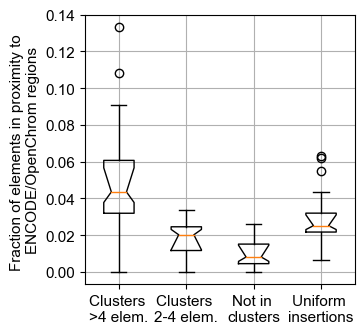

In [82]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_rd_1_mean],labels=["Clusters \n>4 elem.","Clusters \n2-4 elem.","Not in \nclusters", "Uniform \ninsertions"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

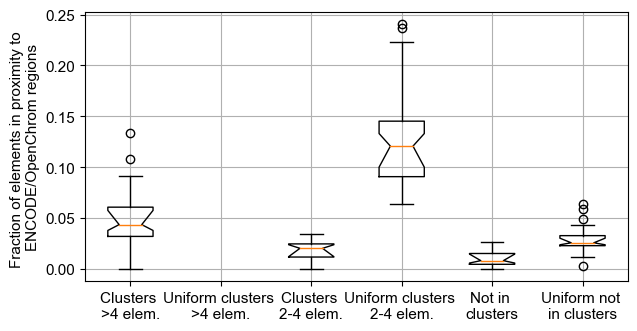

In [83]:
fig=plt.figure(figsize=(7,3.5))
ax1 = fig.add_subplot(111)



ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Uniform clusters \n>4 elem.","Clusters \n2-4 elem.","Uniform clusters \n2-4 elem.","Not in \nclusters","Uniform not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)




plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#ax1.set_aspect(1./ax1.get_data_ratio())

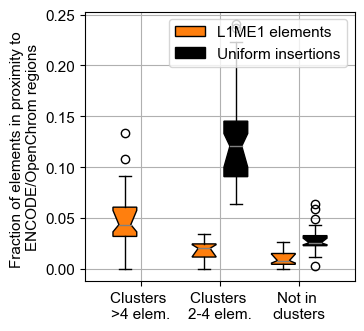

In [84]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([1,2,3])
bp_transposon=[mean_overlap_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean]
bp_hom_pos=[mean_overlap_rd_clusters_range_2_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_rd_1_mean]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(bp_transposon,positions=x_pos-0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp2=ax1.boxplot(bp_hom_pos,positions=x_pos+0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["Clusters \n>4 elem.","Clusters \n2-4 elem.","Not in \nclusters"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ['L1ME1 elements', 'Uniform insertions'],prop={'family': 'Arial','size': 11},loc="upper right")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/h_L1ME1_in_prox_ENCODE_3.pdf",format="pdf",bbox_inches="tight")


In [85]:
#stat sign. for clusters >4 elem.
#t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_clusters_range_2_mean,y=mean_overlap_rd_clusters_range_2_mean,alternative="two-sided")
#print(">4 elements:",p_value_1)
####################
#stat sign. for clusters 2-4 elem.
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_clusters_range_1_mean,y=mean_overlap_rd_clusters_range_1_mean,alternative="two-sided")
print("2-4 elements:",p_value_1)
####################
#stat sign. not in clusters
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_no_cluster_tr_1_mean,y=mean_overlap_no_cluster_rd_1_mean,alternative="two-sided")
print("not in clusters:",p_value_1)

2-4 elements: 6.6368856429973785e-09
not in clusters: 1.8615586035632737e-06


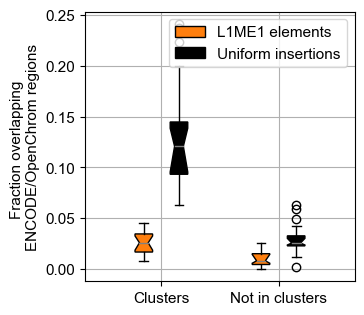

In [88]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
bp_transposon=[mean_overlap_cluster_range_all_mean,mean_overlap_no_cluster_tr_1_mean]
bp_hom_pos=[mean_overlap_rd_cluster_range_all_mean,mean_overlap_no_cluster_rd_1_mean]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(bp_transposon,positions=x_pos-0.15,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp2=ax1.boxplot(bp_hom_pos,positions=x_pos+0.15,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["Clusters","Not in clusters"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ['L1ME1 elements', 'Uniform insertions'],prop={'family': 'Arial','size': 11},loc="upper right")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/g_AluSq2_in_prox_ENCODE_4b.pdf",format="pdf",bbox_inches="tight")


In [89]:
#stat sign. for clusters 2-4 elem.
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_cluster_range_all_mean,y=mean_overlap_rd_cluster_range_all_mean,alternative="two-sided")
print("in clusters:",p_value_1)
####################
#stat sign. not in clusters
t_s, p_value_1=scipy.stats.mannwhitneyu(x=mean_overlap_no_cluster_tr_1_mean,y=mean_overlap_no_cluster_rd_1_mean,alternative="two-sided")
print("not in clusters:",p_value_1)

in clusters: 6.6368856429973785e-09
not in clusters: 1.8615586035632737e-06


In [91]:
#lengths of transposon clusters (from beginning of first transposon of cluster to end of last transposon -> same result as other method before)
length_cluster_1=[]
for i in range(len(df_cluster_pos_3)):
    for index,row in df_cluster_pos_3[i][0].iterrows():
        length_e=row["STOP"]-row["START"]
        length_cluster_1.append(length_e)
    

 
print("mean length clusters 2-4:",np.mean(length_cluster_1))

length_cluster_2=[]
for i in range(len(df_cluster_pos_3)):
    for index,row in df_cluster_pos_3[i][1].iterrows():
        length_e=row["STOP"]-row["START"]
        length_cluster_2.append(length_e)
 
print("mean length clusters >4:",np.mean(length_cluster_2))

length_cluster_all=np.concatenate((length_cluster_1,length_cluster_2))
print("mean+std length all clusters:",np.mean(length_cluster_all),",",np.std(length_cluster_all))
print("max, min length all clusters:",np.max(length_cluster_all),",",np.min(length_cluster_all))

mean length clusters 2-4: 2492.9958029197082
mean length clusters >4: 7102.226035502958
mean+std length all clusters: 3579.41129707113 , 3461.7441694688323
max, min length all clusters: 31645 , 117


# Visualizing distribution on chromosomes

In [ ]:
#save elements and clusters for later use:

#with open ("Transposon_analysis_1/save_elements/AluSp_clusters_eps_e4_min_samples_2_V1.pkl","wb") as f:
    #pickle.dump(df_cluster_pos_3,f)
    
#with open ("Transposon_analysis_1/save_elements/AluSp_elements_V1.pkl","wb") as f:
    #pickle.dump(rmd_list_3,f)    

In [21]:
# load elements for use:

with open('Transposon_analysis_1/save_elements/AluSp_clusters_eps_e4_min_samples_2_V1.pkl', 'rb') as f:
    df_cluster_pos_load = pickle.load(f)
    

with open('Transposon_analysis_1/save_elements/AluSp_elements_V1.pkl', 'rb') as f:
    rmd_list_load = pickle.load(f)
    
        

In [85]:
#get acc peaks spilt into chrs
Chr_acc_peaks_sel1_split_by_chr=[Chr_acc_peaks_sel1[Chr_acc_peaks_sel1['chrom'] == chr_sel] for chr_sel in chr_list_3]

Chr_acc_peaks_sel1_split_by_chr

[      chrom  chromStart   chromEnd            name  score strand          6  \
 7      chr1      713850     714460         Valid_1   1000      .     713850   
 13     chr1      761903     763244         Valid_2   1000      .     761903   
 30     chr1      841391     842575         Valid_3   1000      .     841391   
 32     chr1      845956     847166         Valid_4   1000      .     845956   
 37     chr1      853094     853481         Valid_5   1000      .     853094   
 ...     ...         ...        ...             ...    ...    ...        ...   
 25189  chr1   247553370  247553810  OpenChrom_1125   1000      .  247553370   
 25193  chr1   247611316  247611741  OpenChrom_1126   1000      .  247611316   
 25237  chr1   248406521  248406810  OpenChrom_1127   1000      .  248406521   
 25290  chr1   249106366  249106815  OpenChrom_1128   1000      .  249106366   
 25307  chr1   249218884  249219215  OpenChrom_1129   1000      .  249218884   
 
                7        8      9  ...

Genomic range:  7300000.0 - 7500000.0 BP


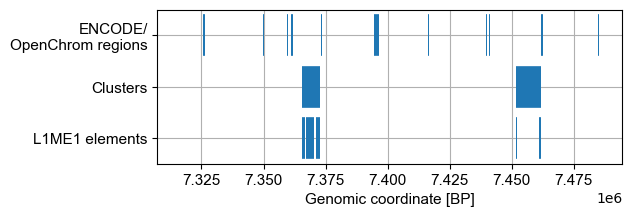

In [86]:
fig=plt.figure(figsize=(6,2))
#fig=plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(111)

plot_chr=0
plot_element_list=[rmd_list_3[plot_chr],    pd.concat([df_cluster_pos_3[plot_chr][0],df_cluster_pos_3[plot_chr][1]],axis=0),         Chr_acc_peaks_sel1_split_by_chr[plot_chr]]
plot_element_start_stop_list=[["genoStart","genoEnd"],["START","STOP"],["chromStart","chromEnd"]]
plot_pos=[1,2,3]
plot_names=["L1ME1 elements","Clusters","ENCODE/\nOpenChrom regions"]
plot_range=[0.73*10**7,0.75*10**7]
plot_range_span=plot_range[1]-plot_range[0]
print("Genomic range: ",plot_range[0],"-",plot_range[1], "BP")
for i in range(len(plot_element_list)):
    plot_sel=plot_element_list[i]
    plot_sel_start=plot_element_start_stop_list[i][0]
    plot_sel_stop=plot_element_start_stop_list[i][1]
    
    for index, row in plot_sel.iterrows():
        
        elem_start=row[plot_sel_start]
        elem_stop=row[plot_sel_stop]
        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            ax1.hlines(plot_pos[i],elem_start_b,elem_stop_b, linewidth=30)
            #ax1.vlines(elem_start,plot_pos[i],plot_pos[i]+1)
            #ax1.vlines(elem_stop,plot_pos[i],plot_pos[i]+1)
plt.ylim(0.5,3.5)
plt.yticks(plot_pos,plot_names,fontname = "Arial",fontsize=11)
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.xlabel("Genomic coordinate [BP]",fontname = "Arial",fontsize=11)
plt.grid()   

Genomic range:  50000000 - 90000000 BP


<Figure size 600x150 with 0 Axes>

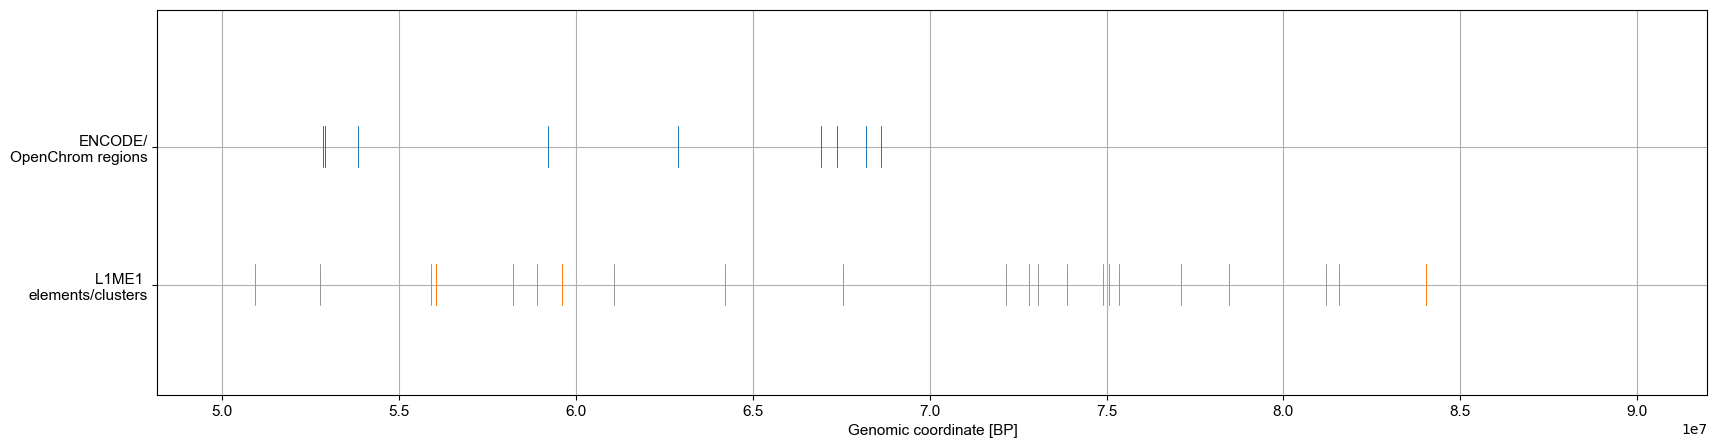

In [112]:
fig=plt.figure(figsize=(6,1.5))
fig=plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(111)

plot_chr=0
plot_element_list=[   pd.concat([df_cluster_pos_3[plot_chr][0],df_cluster_pos_3[plot_chr][1]],axis=0), rmd_list_3[plot_chr],         Chr_acc_peaks_sel1_split_by_chr[plot_chr]]
plot_element_start_stop_list=[["START","STOP"],["genoStart","genoEnd"],["chromStart","chromEnd"]]
plot_pos=[1,1,2]
plot_names=["L1ME1 \nelements/clusters","ENCODE/\nOpenChrom regions"]
plot_range=[5*10**7,9*10**7]  #[0.73*10**7,0.75*10**7]
plot_colors=["grey","tab:orange","tab:blue"]
plot_alpha=[0.8,1,1]
plot_range_span=plot_range[1]-plot_range[0]
print("Genomic range: ",plot_range[0],"-",plot_range[1], "BP")
for i in range(len(plot_element_list)):
    plot_sel=plot_element_list[i]
    plot_sel_start=plot_element_start_stop_list[i][0]
    plot_sel_stop=plot_element_start_stop_list[i][1]
    
    for index, row in plot_sel.iterrows():
        
        elem_start=row[plot_sel_start]
        elem_stop=row[plot_sel_stop]
        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            ax1.hlines(plot_pos[i],elem_start_b,elem_stop_b, linewidth=30,color=plot_colors[i],alpha=plot_alpha[i])
            #ax1.vlines(elem_start,plot_pos[i],plot_pos[i]+1)
            #ax1.vlines(elem_stop,plot_pos[i],plot_pos[i]+1)
plt.ylim(0.2,3)
plt.yticks(plot_pos[1:],plot_names,fontname = "Arial",fontsize=11)
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.xlabel("Genomic coordinate [BP]",fontname = "Arial",fontsize=11)
plt.grid()   

In [134]:
elements_1

genoName  genoStart    genoEnd repName repClass repFamily
0          chr1   16777160   16777470   AluSp     SINE       Alu
29         chr1   27262667   27262980   AluSp     SINE       Alu
96         chr1  205520641  205520931   AluSp     SINE       Alu
104        chr1  219152248  219152545   AluSp     SINE       Alu
125        chr1    3669874    3670198   AluSp     SINE       Alu
...         ...        ...        ...     ...      ...       ...
432705     chr1  249166772  249167080   AluSp     SINE       Alu
432716     chr1  249170195  249170506   AluSp     SINE       Alu
432723     chr1  249177306  249177620   AluSp     SINE       Alu
432741     chr1  249184113  249184424   AluSp     SINE       Alu
432793     chr1  249206999  249207300   AluSp     SINE       Alu

[4585 rows x 6 columns]

In [179]:
#if transposon very short, lines in plot might not be visible, therefore use a minimum width
def return_minimum_width(ymin, ymax, min_length):
    
    if ymax - ymin < min_length:
        center = (ymax + ymin) / 2
        ymin = center - min_length / 2
        ymax = center + min_length / 2
    return ymin, ymax   

Chr: chr5 Genomic range: 69000000 - 69300000 BP


<Figure size 600x200 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

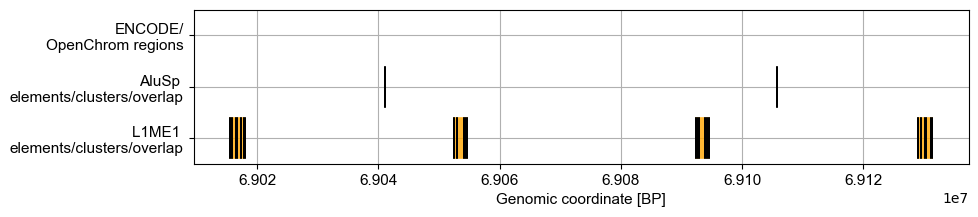

In [211]:
plot_chr=4
min_dist_plot=0

elements_1=rmd_list_3[plot_chr]
clusters_element_1=pd.concat([df_cluster_pos_3[plot_chr][0],df_cluster_pos_3[plot_chr][1]],axis=0)

elements_2=rmd_list_load[plot_chr]
clusters_element_2=pd.concat([df_cluster_pos_load[plot_chr][0],df_cluster_pos_load[plot_chr][1]],axis=0)

chr_acc=Chr_acc_peaks_sel1_split_by_chr[plot_chr]



plot_names=["L1ME1 \nelements/clusters/overlap","AluSp \nelements/clusters/overlap","ENCODE/\nOpenChrom regions"]




plot_range=[5.1*10**7,5.2*10**7]   #[5*10**7,5.5*10**7]

plot_range_start=np.asarray([1,2,3,4,5,6,7,8,9])*10**7
plot_range_stop=np.asarray([2,3,4,5,6,7,8,9,10])*10**7

plot_range_start=np.arange(1,10,0.1)*10**7
plot_range_stop=plot_range_start +0.03*10**7


plot_range_start=  [69000000] #[15920000] #
plot_range_stop= [69300000] #[16220000]   #
chr_acc_start=chr_acc["chromStart"].to_numpy()
chr_acc_stop=chr_acc["chromEnd"].to_numpy()
for k in range(len(plot_range_start)):
    
    fig=plt.figure(figsize=(6,2))
    fig=plt.figure(figsize=(20,5))
    fig=plt.figure(figsize=(10,2))
    
    ax1 = fig.add_subplot(111)

    plot_range=[plot_range_start[k],plot_range_stop[k]]
    
    plot_range_span=plot_range[1]-plot_range[0]
    
    
    min_width_line=plot_range_span/750
    
    
    print("Chr:",chr_list_3[plot_chr],"Genomic range:",plot_range[0],"-",plot_range[1], "BP")




    #plot clusters element 1
    for index, row in clusters_element_1.iterrows():

        elem_start=row["START"]
        elem_stop=row["STOP"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(1,draw_start,draw_stop, linewidth=30,color="orange",alpha=0.8)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(1,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")

    #plot elements 1
    for index, row in elements_1.iterrows():

        elem_start=row["genoStart"]
        elem_stop=row["genoEnd"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(1,draw_start,draw_stop, linewidth=30,color="black",alpha=1)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(1,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")

    ##########################
    ##########################
    ##########################




    #plot clusters element 2
    for index, row in clusters_element_2.iterrows():

        elem_start=row["START"]
        elem_stop=row["STOP"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(2,draw_start,draw_stop, linewidth=30,color="orange",alpha=0.8)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(2,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")

    #plot elements 2
    for index, row in elements_2.iterrows():

        elem_start=row["genoStart"]
        elem_stop=row["genoEnd"]


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span
            
            draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)

            #check if cluster overlaps open chr:
            #chr_acc_start=chr_acc["chromStart"].to_numpy()
            #chr_acc_stop=chr_acc["chromEnd"].to_numpy()
            overlap_array=calc_overlap_V3(min1=elem_start_b,max1=elem_stop_b,min2=chr_acc_start,max2=chr_acc_stop)

            ax1.hlines(2,draw_start,draw_stop, linewidth=30,color="black",alpha=1)

            if any(x > min_dist_plot for x in overlap_array):
                ax1.hlines(2,draw_start,draw_stop, linewidth=15,color="green",alpha=1)
                #print("!")


    #plot open chr regions
    for index, row in chr_acc.iterrows():

        elem_start=row["chromStart"]
        elem_stop=row["chromEnd"]
        
        draw_start,draw_stop=return_minimum_width(ymin=elem_start_b, ymax=elem_stop_b, min_length=min_width_line)


        if plot_range[0]<=elem_start and elem_stop<=plot_range[1]:
            elem_start_b=elem_start#-1/50 *plot_range_span
            elem_stop_b=elem_stop#+1/50 *plot_range_span


            ax1.hlines(3,draw_start,draw_stop, linewidth=30,color="black",alpha=1)







    plt.ylim(0.5,3.5)
    plt.yticks([1,2,3],plot_names,fontname = "Arial",fontsize=11)
    plt.xticks(fontname = "Arial",fontsize=11) 
    #plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
    plt.xlabel("Genomic coordinate [BP]",fontname = "Arial",fontsize=11)
    plt.grid()
    #plt.savefig("Transposon_analysis_1/figures/chr5_section_69000000_69300000_L1ME1_AluSp_V1.pdf",format="pdf",bbox_inches="tight")
    plt.show()



In [ ]:
# interesting regions AluSp:
#index chr:0, Genomic range:  16000000.000000006 - 16300000.000000006 BP



#iteresting regions l1ME1:
#index chr: 5 Genomic range:  61000000.00000005 - 61300000.00000005 BP

#index chr: 5 , Genomic range:  69000000.00000006 - 69300000.00000006 BP

In [191]:
61000000-61300000

-300000

In [192]:
16000000-16300000

-300000

In [143]:
chr_acc["chromStart"].to_numpy()

array([   713850,    761903,    841391, ..., 248406521, 249106366,
       249218884])

In [157]:
plot_range_start

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1,
 2,
 3,
 4,
 5,
 6,
 7,


# Tests

In [91]:
%%time
#overlap of clusters with open chromatin
mean_overlap_clusters_test=[]
for i in range(len(chr_list_3)):
    mean_overlap_clusters_e=[]
    for j in range(len(df_cluster_pos_3[i])):
        if j==0:
            k=1
        if j==1:
            k=0
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_3[i][j], df2=df_cluster_pos_3[i][k], chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=max_sep_regions)
        mean_overlap_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_clusters_test.append(mean_overlap_clusters_e)

0 / 417
1 / 417
2 / 417
3 / 417
4 / 417
5 / 417
6 / 417
7 / 417
8 / 417
9 / 417
10 / 417
11 / 417
12 / 417
13 / 417
14 / 417
15 / 417
16 / 417
17 / 417
18 / 417
19 / 417
20 / 417
21 / 417
22 / 417
23 / 417
24 / 417
25 / 417
26 / 417
27 / 417
28 / 417
29 / 417
30 / 417
31 / 417
32 / 417
33 / 417
34 / 417
35 / 417
36 / 417
37 / 417
38 / 417
39 / 417
40 / 417
41 / 417
42 / 417
43 / 417
44 / 417
45 / 417
46 / 417
47 / 417
48 / 417
49 / 417
50 / 417
51 / 417
52 / 417
53 / 417
54 / 417
55 / 417
56 / 417
57 / 417
58 / 417
59 / 417
60 / 417
61 / 417
62 / 417
63 / 417
64 / 417
65 / 417
66 / 417
67 / 417
68 / 417
69 / 417
70 / 417
71 / 417
72 / 417
73 / 417
74 / 417
75 / 417
76 / 417
77 / 417
78 / 417
79 / 417
80 / 417
81 / 417
82 / 417
83 / 417
84 / 417
85 / 417
86 / 417
87 / 417
88 / 417
89 / 417
90 / 417
91 / 417
92 / 417
93 / 417
94 / 417
95 / 417
96 / 417
97 / 417
98 / 417
99 / 417
100 / 417
101 / 417
102 / 417
103 / 417
104 / 417
105 / 417
106 / 417
107 / 417
108 / 417
109 / 417
110 / 417


223 / 389
224 / 389
225 / 389
226 / 389
227 / 389
228 / 389
229 / 389
230 / 389
231 / 389
232 / 389
233 / 389
234 / 389
235 / 389
236 / 389
237 / 389
238 / 389
239 / 389
240 / 389
241 / 389
242 / 389
243 / 389
244 / 389
245 / 389
246 / 389
247 / 389
248 / 389
249 / 389
250 / 389
251 / 389
252 / 389
253 / 389
254 / 389
255 / 389
256 / 389
257 / 389
258 / 389
259 / 389
260 / 389
261 / 389
262 / 389
263 / 389
264 / 389
265 / 389
266 / 389
267 / 389
268 / 389
269 / 389
270 / 389
271 / 389
272 / 389
273 / 389
274 / 389
275 / 389
276 / 389
277 / 389
278 / 389
279 / 389
280 / 389
281 / 389
282 / 389
283 / 389
284 / 389
285 / 389
286 / 389
287 / 389
288 / 389
289 / 389
290 / 389
291 / 389
292 / 389
293 / 389
294 / 389
295 / 389
296 / 389
297 / 389
298 / 389
299 / 389
300 / 389
301 / 389
302 / 389
303 / 389
304 / 389
305 / 389
306 / 389
307 / 389
308 / 389
309 / 389
310 / 389
311 / 389
312 / 389
313 / 389
314 / 389
315 / 389
316 / 389
317 / 389
318 / 389
319 / 389
320 / 389
321 / 389
322 / 389


344 / 351
345 / 351
346 / 351
347 / 351
348 / 351
349 / 351
350 / 351
351 / 351
0 / 93
1 / 93
2 / 93
3 / 93
4 / 93
5 / 93
6 / 93
7 / 93
8 / 93
9 / 93
10 / 93
11 / 93
12 / 93
13 / 93
14 / 93
15 / 93
16 / 93
17 / 93
18 / 93
19 / 93
20 / 93
21 / 93
22 / 93
23 / 93
24 / 93
25 / 93
26 / 93
27 / 93
28 / 93
29 / 93
30 / 93
31 / 93
32 / 93
33 / 93
34 / 93
35 / 93
36 / 93
37 / 93
38 / 93
39 / 93
40 / 93
41 / 93
42 / 93
43 / 93
44 / 93
45 / 93
46 / 93
47 / 93
48 / 93
49 / 93
50 / 93
51 / 93
52 / 93
53 / 93
54 / 93
55 / 93
56 / 93
57 / 93
58 / 93
59 / 93
60 / 93
61 / 93
62 / 93
63 / 93
64 / 93
65 / 93
66 / 93
67 / 93
68 / 93
69 / 93
70 / 93
71 / 93
72 / 93
73 / 93
74 / 93
75 / 93
76 / 93
77 / 93
78 / 93
79 / 93
80 / 93
81 / 93
82 / 93
83 / 93
84 / 93
85 / 93
86 / 93
87 / 93
88 / 93
89 / 93
90 / 93
91 / 93
92 / 93
93 / 93
0 / 316
1 / 316
2 / 316
3 / 316
4 / 316
5 / 316
6 / 316
7 / 316
8 / 316
9 / 316
10 / 316
11 / 316
12 / 316
13 / 316
14 / 316
15 / 316
16 / 316
17 / 316
18 / 316
19 / 316
20 / 316

22 / 67
23 / 67
24 / 67
25 / 67
26 / 67
27 / 67
28 / 67
29 / 67
30 / 67
31 / 67
32 / 67
33 / 67
34 / 67
35 / 67
36 / 67
37 / 67
38 / 67
39 / 67
40 / 67
41 / 67
42 / 67
43 / 67
44 / 67
45 / 67
46 / 67
47 / 67
48 / 67
49 / 67
50 / 67
51 / 67
52 / 67
53 / 67
54 / 67
55 / 67
56 / 67
57 / 67
58 / 67
59 / 67
60 / 67
61 / 67
62 / 67
63 / 67
64 / 67
65 / 67
66 / 67
67 / 67
0 / 294
1 / 294
2 / 294
3 / 294
4 / 294
5 / 294
6 / 294
7 / 294
8 / 294
9 / 294
10 / 294
11 / 294
12 / 294
13 / 294
14 / 294
15 / 294
16 / 294
17 / 294
18 / 294
19 / 294
20 / 294
21 / 294
22 / 294
23 / 294
24 / 294
25 / 294
26 / 294
27 / 294
28 / 294
29 / 294
30 / 294
31 / 294
32 / 294
33 / 294
34 / 294
35 / 294
36 / 294
37 / 294
38 / 294
39 / 294
40 / 294
41 / 294
42 / 294
43 / 294
44 / 294
45 / 294
46 / 294
47 / 294
48 / 294
49 / 294
50 / 294
51 / 294
52 / 294
53 / 294
54 / 294
55 / 294
56 / 294
57 / 294
58 / 294
59 / 294
60 / 294
61 / 294
62 / 294
63 / 294
64 / 294
65 / 294
66 / 294
67 / 294
68 / 294
69 / 294
70 / 294
71 

195 / 237
196 / 237
197 / 237
198 / 237
199 / 237
200 / 237
201 / 237
202 / 237
203 / 237
204 / 237
205 / 237
206 / 237
207 / 237
208 / 237
209 / 237
210 / 237
211 / 237
212 / 237
213 / 237
214 / 237
215 / 237
216 / 237
217 / 237
218 / 237
219 / 237
220 / 237
221 / 237
222 / 237
223 / 237
224 / 237
225 / 237
226 / 237
227 / 237
228 / 237
229 / 237
230 / 237
231 / 237
232 / 237
233 / 237
234 / 237
235 / 237
236 / 237
237 / 237
0 / 85
1 / 85
2 / 85
3 / 85
4 / 85
5 / 85
6 / 85
7 / 85
8 / 85
9 / 85
10 / 85
11 / 85
12 / 85
13 / 85
14 / 85
15 / 85
16 / 85
17 / 85
18 / 85
19 / 85
20 / 85
21 / 85
22 / 85
23 / 85
24 / 85
25 / 85
26 / 85
27 / 85
28 / 85
29 / 85
30 / 85
31 / 85
32 / 85
33 / 85
34 / 85
35 / 85
36 / 85
37 / 85
38 / 85
39 / 85
40 / 85
41 / 85
42 / 85
43 / 85
44 / 85
45 / 85
46 / 85
47 / 85
48 / 85
49 / 85
50 / 85
51 / 85
52 / 85
53 / 85
54 / 85
55 / 85
56 / 85
57 / 85
58 / 85
59 / 85
60 / 85
61 / 85
62 / 85
63 / 85
64 / 85
65 / 85
66 / 85
67 / 85
68 / 85
69 / 85
70 / 85
71 / 85
72 /

34 / 122
35 / 122
36 / 122
37 / 122
38 / 122
39 / 122
40 / 122
41 / 122
42 / 122
43 / 122
44 / 122
45 / 122
46 / 122
47 / 122
48 / 122
49 / 122
50 / 122
51 / 122
52 / 122
53 / 122
54 / 122
55 / 122
56 / 122
57 / 122
58 / 122
59 / 122
60 / 122
61 / 122
62 / 122
63 / 122
64 / 122
65 / 122
66 / 122
67 / 122
68 / 122
69 / 122
70 / 122
71 / 122
72 / 122
73 / 122
74 / 122
75 / 122
76 / 122
77 / 122
78 / 122
79 / 122
80 / 122
81 / 122
82 / 122
83 / 122
84 / 122
85 / 122
86 / 122
87 / 122
88 / 122
89 / 122
90 / 122
91 / 122
92 / 122
93 / 122
94 / 122
95 / 122
96 / 122
97 / 122
98 / 122
99 / 122
100 / 122
101 / 122
102 / 122
103 / 122
104 / 122
105 / 122
106 / 122
107 / 122
108 / 122
109 / 122
110 / 122
111 / 122
112 / 122
113 / 122
114 / 122
115 / 122
116 / 122
117 / 122
118 / 122
119 / 122
120 / 122
121 / 122
122 / 122
0 / 32
1 / 32
2 / 32
3 / 32
4 / 32
5 / 32
6 / 32
7 / 32
8 / 32
9 / 32
10 / 32
11 / 32
12 / 32
13 / 32
14 / 32
15 / 32
16 / 32
17 / 32
18 / 32
19 / 32
20 / 32
21 / 32
22 / 32
23

In [92]:
%%time
#overlap of random clusters with open chromatin
mean_overlap_rd_clusters_test=[]
for i in range(len(chr_list_3)):
    mean_overlap_rd_clusters_e=[]
    for j in range(len(df_cluster_pos_rd_3[i])):
        if j==0:
            k=1
        if j==1:
            k=0
        k=np.random.choice([0,1],p=[0.5,0.5])
        overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_rd_3[i][j], df2=df_cluster_pos_rd_3[i][k], chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=max_sep_regions)
        mean_overlap_rd_clusters_e.append(overlap_clusters_open_chr_e)
    mean_overlap_rd_clusters_test.append(mean_overlap_rd_clusters_e)

0 / 219
1 / 219
2 / 219
3 / 219
4 / 219
5 / 219
6 / 219
7 / 219
8 / 219
9 / 219
10 / 219
11 / 219
12 / 219
13 / 219
14 / 219
15 / 219
16 / 219
17 / 219
18 / 219
19 / 219
20 / 219
21 / 219
22 / 219
23 / 219
24 / 219
25 / 219
26 / 219
27 / 219
28 / 219
29 / 219
30 / 219
31 / 219
32 / 219
33 / 219
34 / 219
35 / 219
36 / 219
37 / 219
38 / 219
39 / 219
40 / 219
41 / 219
42 / 219
43 / 219
44 / 219
45 / 219
46 / 219
47 / 219
48 / 219
49 / 219
50 / 219
51 / 219
52 / 219
53 / 219
54 / 219
55 / 219
56 / 219
57 / 219
58 / 219
59 / 219
60 / 219
61 / 219
62 / 219
63 / 219
64 / 219
65 / 219
66 / 219
67 / 219
68 / 219
69 / 219
70 / 219
71 / 219
72 / 219
73 / 219
74 / 219
75 / 219
76 / 219
77 / 219
78 / 219
79 / 219
80 / 219
81 / 219
82 / 219
83 / 219
84 / 219
85 / 219
86 / 219
87 / 219
88 / 219
89 / 219
90 / 219
91 / 219
92 / 219
93 / 219
94 / 219
95 / 219
96 / 219
97 / 219
98 / 219
99 / 219
100 / 219
101 / 219
102 / 219
103 / 219
104 / 219
105 / 219
106 / 219
107 / 219
108 / 219
109 / 219
110 / 219


KeyError: 'CHROM'

In [93]:
#get mean overlap percentages in each chromosome for 2-4 points and >4 points in clusters

min_num_points_cond=0 #10
mean_overlap_clusters_range_1_mean_test=[]
for i in range(len(mean_overlap_clusters_test)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters_test[i][0])>min_num_points_cond:
        mean_overlap_clusters_range_1_mean_test.append(np.mean(mean_overlap_clusters_test[i][0]))
    
mean_overlap_clusters_range_2_mean_test=[]
for i in range(len(mean_overlap_clusters_test)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_clusters_test[i][1])>min_num_points_cond:
        mean_overlap_clusters_range_2_mean_test.append(np.mean(mean_overlap_clusters_test[i][1]))
    
 
mean_overlap_rd_clusters_range_1_mean_test=[]
for i in range(len(mean_overlap_rd_clusters_test)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters_test[i][0])>min_num_points_cond:
        mean_overlap_rd_clusters_range_1_mean_test.append(np.mean(mean_overlap_rd_clusters_test[i][0]))
    
mean_overlap_rd_clusters_range_2_mean_test=[]
for i in range(len(mean_overlap_rd_clusters_test)):
    #only append fraction in prox. to open chr. if any elements/clusters on chr detected:
    if len(mean_overlap_rd_clusters_test[i][1])>min_num_points_cond:
        mean_overlap_rd_clusters_range_2_mean_test.append(np.mean(mean_overlap_rd_clusters_test[i][1]))


In [94]:
%%time
#overlap all transposons not in clusters positions or random positions not in clusters with open chr
mean_overlap_no_cluster_tr_1_test=[]
mean_overlap_no_cluster_rd_1_test=[]
for i in range(len(chr_list_3)):
    overlap_tr_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_3[i], df2=df_no_cluster_pos_3[i], chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=max_sep_regions)
    overlap_rd_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_no_cluster_pos_rd_3[i], df2=df_no_cluster_pos_rd_3[i], chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=max_sep_regions)
    
    mean_overlap_no_cluster_tr_1_test.append(overlap_tr_open_chr_e)
    mean_overlap_no_cluster_rd_1_test.append(overlap_rd_open_chr_e)
    
mean_overlap_no_cluster_tr_1_mean_test=[]
mean_overlap_no_cluster_rd_1_mean_test=[]
for i in range(len(mean_overlap_tr_1)):
    mean_overlap_no_cluster_tr_1_mean_test.append(np.mean(mean_overlap_no_cluster_tr_1_test[i]))
    mean_overlap_no_cluster_rd_1_mean_test.append(np.mean(mean_overlap_no_cluster_rd_1_test[i]))

0 / 395
1 / 395
2 / 395
3 / 395
4 / 395
5 / 395
6 / 395
7 / 395
8 / 395
9 / 395
10 / 395
11 / 395
12 / 395
13 / 395
14 / 395
15 / 395
16 / 395
17 / 395
18 / 395
19 / 395
20 / 395
21 / 395
22 / 395
23 / 395
24 / 395
25 / 395
26 / 395
27 / 395
28 / 395
29 / 395
30 / 395
31 / 395
32 / 395
33 / 395
34 / 395
35 / 395
36 / 395
37 / 395
38 / 395
39 / 395
40 / 395
41 / 395
42 / 395
43 / 395
44 / 395
45 / 395
46 / 395
47 / 395
48 / 395
49 / 395
50 / 395
51 / 395
52 / 395
53 / 395
54 / 395
55 / 395
56 / 395
57 / 395
58 / 395
59 / 395
60 / 395
61 / 395
62 / 395
63 / 395
64 / 395
65 / 395
66 / 395
67 / 395
68 / 395
69 / 395
70 / 395
71 / 395
72 / 395
73 / 395
74 / 395
75 / 395
76 / 395
77 / 395
78 / 395
79 / 395
80 / 395
81 / 395
82 / 395
83 / 395
84 / 395
85 / 395
86 / 395
87 / 395
88 / 395
89 / 395
90 / 395
91 / 395
92 / 395
93 / 395
94 / 395
95 / 395
96 / 395
97 / 395
98 / 395
99 / 395
100 / 395
101 / 395
102 / 395
103 / 395
104 / 395
105 / 395
106 / 395
107 / 395
108 / 395
109 / 395
110 / 395


690 / 2061
691 / 2061
692 / 2061
693 / 2061
694 / 2061
695 / 2061
696 / 2061
697 / 2061
698 / 2061
699 / 2061
700 / 2061
701 / 2061
702 / 2061
703 / 2061
704 / 2061
705 / 2061
706 / 2061
707 / 2061
708 / 2061
709 / 2061
710 / 2061
711 / 2061
712 / 2061
713 / 2061
714 / 2061
715 / 2061
716 / 2061
717 / 2061
718 / 2061
719 / 2061
720 / 2061
721 / 2061
722 / 2061
723 / 2061
724 / 2061
725 / 2061
726 / 2061
727 / 2061
728 / 2061
729 / 2061
730 / 2061
731 / 2061
732 / 2061
733 / 2061
734 / 2061
735 / 2061
736 / 2061
737 / 2061
738 / 2061
739 / 2061
740 / 2061
741 / 2061
742 / 2061
743 / 2061
744 / 2061
745 / 2061
746 / 2061
747 / 2061
748 / 2061
749 / 2061
750 / 2061
751 / 2061
752 / 2061
753 / 2061
754 / 2061
755 / 2061
756 / 2061
757 / 2061
758 / 2061
759 / 2061
760 / 2061
761 / 2061
762 / 2061
763 / 2061
764 / 2061
765 / 2061
766 / 2061
767 / 2061
768 / 2061
769 / 2061
770 / 2061
771 / 2061
772 / 2061
773 / 2061
774 / 2061
775 / 2061
776 / 2061
777 / 2061
778 / 2061
779 / 2061
780 / 2061

1679 / 2061
1680 / 2061
1681 / 2061
1682 / 2061
1683 / 2061
1684 / 2061
1685 / 2061
1686 / 2061
1687 / 2061
1688 / 2061
1689 / 2061
1690 / 2061
1691 / 2061
1692 / 2061
1693 / 2061
1694 / 2061
1695 / 2061
1696 / 2061
1697 / 2061
1698 / 2061
1699 / 2061
1700 / 2061
1701 / 2061
1702 / 2061
1703 / 2061
1704 / 2061
1705 / 2061
1706 / 2061
1707 / 2061
1708 / 2061
1709 / 2061
1710 / 2061
1711 / 2061
1712 / 2061
1713 / 2061
1714 / 2061
1715 / 2061
1716 / 2061
1717 / 2061
1718 / 2061
1719 / 2061
1720 / 2061
1721 / 2061
1722 / 2061
1723 / 2061
1724 / 2061
1725 / 2061
1726 / 2061
1727 / 2061
1728 / 2061
1729 / 2061
1730 / 2061
1731 / 2061
1732 / 2061
1733 / 2061
1734 / 2061
1735 / 2061
1736 / 2061
1737 / 2061
1738 / 2061
1739 / 2061
1740 / 2061
1741 / 2061
1742 / 2061
1743 / 2061
1744 / 2061
1745 / 2061
1746 / 2061
1747 / 2061
1748 / 2061
1749 / 2061
1750 / 2061
1751 / 2061
1752 / 2061
1753 / 2061
1754 / 2061
1755 / 2061
1756 / 2061
1757 / 2061
1758 / 2061
1759 / 2061
1760 / 2061
1761 / 2061
1762

231 / 2218
232 / 2218
233 / 2218
234 / 2218
235 / 2218
236 / 2218
237 / 2218
238 / 2218
239 / 2218
240 / 2218
241 / 2218
242 / 2218
243 / 2218
244 / 2218
245 / 2218
246 / 2218
247 / 2218
248 / 2218
249 / 2218
250 / 2218
251 / 2218
252 / 2218
253 / 2218
254 / 2218
255 / 2218
256 / 2218
257 / 2218
258 / 2218
259 / 2218
260 / 2218
261 / 2218
262 / 2218
263 / 2218
264 / 2218
265 / 2218
266 / 2218
267 / 2218
268 / 2218
269 / 2218
270 / 2218
271 / 2218
272 / 2218
273 / 2218
274 / 2218
275 / 2218
276 / 2218
277 / 2218
278 / 2218
279 / 2218
280 / 2218
281 / 2218
282 / 2218
283 / 2218
284 / 2218
285 / 2218
286 / 2218
287 / 2218
288 / 2218
289 / 2218
290 / 2218
291 / 2218
292 / 2218
293 / 2218
294 / 2218
295 / 2218
296 / 2218
297 / 2218
298 / 2218
299 / 2218
300 / 2218
301 / 2218
302 / 2218
303 / 2218
304 / 2218
305 / 2218
306 / 2218
307 / 2218
308 / 2218
309 / 2218
310 / 2218
311 / 2218
312 / 2218
313 / 2218
314 / 2218
315 / 2218
316 / 2218
317 / 2218
318 / 2218
319 / 2218
320 / 2218
321 / 2218

1256 / 2218
1257 / 2218
1258 / 2218
1259 / 2218
1260 / 2218
1261 / 2218
1262 / 2218
1263 / 2218
1264 / 2218
1265 / 2218
1266 / 2218
1267 / 2218
1268 / 2218
1269 / 2218
1270 / 2218
1271 / 2218
1272 / 2218
1273 / 2218
1274 / 2218
1275 / 2218
1276 / 2218
1277 / 2218
1278 / 2218
1279 / 2218
1280 / 2218
1281 / 2218
1282 / 2218
1283 / 2218
1284 / 2218
1285 / 2218
1286 / 2218
1287 / 2218
1288 / 2218
1289 / 2218
1290 / 2218
1291 / 2218
1292 / 2218
1293 / 2218
1294 / 2218
1295 / 2218
1296 / 2218
1297 / 2218
1298 / 2218
1299 / 2218
1300 / 2218
1301 / 2218
1302 / 2218
1303 / 2218
1304 / 2218
1305 / 2218
1306 / 2218
1307 / 2218
1308 / 2218
1309 / 2218
1310 / 2218
1311 / 2218
1312 / 2218
1313 / 2218
1314 / 2218
1315 / 2218
1316 / 2218
1317 / 2218
1318 / 2218
1319 / 2218
1320 / 2218
1321 / 2218
1322 / 2218
1323 / 2218
1324 / 2218
1325 / 2218
1326 / 2218
1327 / 2218
1328 / 2218
1329 / 2218
1330 / 2218
1331 / 2218
1332 / 2218
1333 / 2218
1334 / 2218
1335 / 2218
1336 / 2218
1337 / 2218
1338 / 2218
1339

2187 / 2218
2188 / 2218
2189 / 2218
2190 / 2218
2191 / 2218
2192 / 2218
2193 / 2218
2194 / 2218
2195 / 2218
2196 / 2218
2197 / 2218
2198 / 2218
2199 / 2218
2200 / 2218
2201 / 2218
2202 / 2218
2203 / 2218
2204 / 2218
2205 / 2218
2206 / 2218
2207 / 2218
2208 / 2218
2209 / 2218
2210 / 2218
2211 / 2218
2212 / 2218
2213 / 2218
2214 / 2218
2215 / 2218
2216 / 2218
2217 / 2218
2218 / 2218
0 / 441
1 / 441
2 / 441
3 / 441
4 / 441
5 / 441
6 / 441
7 / 441
8 / 441
9 / 441
10 / 441
11 / 441
12 / 441
13 / 441
14 / 441
15 / 441
16 / 441
17 / 441
18 / 441
19 / 441
20 / 441
21 / 441
22 / 441
23 / 441
24 / 441
25 / 441
26 / 441
27 / 441
28 / 441
29 / 441
30 / 441
31 / 441
32 / 441
33 / 441
34 / 441
35 / 441
36 / 441
37 / 441
38 / 441
39 / 441
40 / 441
41 / 441
42 / 441
43 / 441
44 / 441
45 / 441
46 / 441
47 / 441
48 / 441
49 / 441
50 / 441
51 / 441
52 / 441
53 / 441
54 / 441
55 / 441
56 / 441
57 / 441
58 / 441
59 / 441
60 / 441
61 / 441
62 / 441
63 / 441
64 / 441
65 / 441
66 / 441
67 / 441
68 / 441
69 / 

667 / 1688
668 / 1688
669 / 1688
670 / 1688
671 / 1688
672 / 1688
673 / 1688
674 / 1688
675 / 1688
676 / 1688
677 / 1688
678 / 1688
679 / 1688
680 / 1688
681 / 1688
682 / 1688
683 / 1688
684 / 1688
685 / 1688
686 / 1688
687 / 1688
688 / 1688
689 / 1688
690 / 1688
691 / 1688
692 / 1688
693 / 1688
694 / 1688
695 / 1688
696 / 1688
697 / 1688
698 / 1688
699 / 1688
700 / 1688
701 / 1688
702 / 1688
703 / 1688
704 / 1688
705 / 1688
706 / 1688
707 / 1688
708 / 1688
709 / 1688
710 / 1688
711 / 1688
712 / 1688
713 / 1688
714 / 1688
715 / 1688
716 / 1688
717 / 1688
718 / 1688
719 / 1688
720 / 1688
721 / 1688
722 / 1688
723 / 1688
724 / 1688
725 / 1688
726 / 1688
727 / 1688
728 / 1688
729 / 1688
730 / 1688
731 / 1688
732 / 1688
733 / 1688
734 / 1688
735 / 1688
736 / 1688
737 / 1688
738 / 1688
739 / 1688
740 / 1688
741 / 1688
742 / 1688
743 / 1688
744 / 1688
745 / 1688
746 / 1688
747 / 1688
748 / 1688
749 / 1688
750 / 1688
751 / 1688
752 / 1688
753 / 1688
754 / 1688
755 / 1688
756 / 1688
757 / 1688

41 / 321
42 / 321
43 / 321
44 / 321
45 / 321
46 / 321
47 / 321
48 / 321
49 / 321
50 / 321
51 / 321
52 / 321
53 / 321
54 / 321
55 / 321
56 / 321
57 / 321
58 / 321
59 / 321
60 / 321
61 / 321
62 / 321
63 / 321
64 / 321
65 / 321
66 / 321
67 / 321
68 / 321
69 / 321
70 / 321
71 / 321
72 / 321
73 / 321
74 / 321
75 / 321
76 / 321
77 / 321
78 / 321
79 / 321
80 / 321
81 / 321
82 / 321
83 / 321
84 / 321
85 / 321
86 / 321
87 / 321
88 / 321
89 / 321
90 / 321
91 / 321
92 / 321
93 / 321
94 / 321
95 / 321
96 / 321
97 / 321
98 / 321
99 / 321
100 / 321
101 / 321
102 / 321
103 / 321
104 / 321
105 / 321
106 / 321
107 / 321
108 / 321
109 / 321
110 / 321
111 / 321
112 / 321
113 / 321
114 / 321
115 / 321
116 / 321
117 / 321
118 / 321
119 / 321
120 / 321
121 / 321
122 / 321
123 / 321
124 / 321
125 / 321
126 / 321
127 / 321
128 / 321
129 / 321
130 / 321
131 / 321
132 / 321
133 / 321
134 / 321
135 / 321
136 / 321
137 / 321
138 / 321
139 / 321
140 / 321
141 / 321
142 / 321
143 / 321
144 / 321
145 / 321
146 / 321

903 / 1440
904 / 1440
905 / 1440
906 / 1440
907 / 1440
908 / 1440
909 / 1440
910 / 1440
911 / 1440
912 / 1440
913 / 1440
914 / 1440
915 / 1440
916 / 1440
917 / 1440
918 / 1440
919 / 1440
920 / 1440
921 / 1440
922 / 1440
923 / 1440
924 / 1440
925 / 1440
926 / 1440
927 / 1440
928 / 1440
929 / 1440
930 / 1440
931 / 1440
932 / 1440
933 / 1440
934 / 1440
935 / 1440
936 / 1440
937 / 1440
938 / 1440
939 / 1440
940 / 1440
941 / 1440
942 / 1440
943 / 1440
944 / 1440
945 / 1440
946 / 1440
947 / 1440
948 / 1440
949 / 1440
950 / 1440
951 / 1440
952 / 1440
953 / 1440
954 / 1440
955 / 1440
956 / 1440
957 / 1440
958 / 1440
959 / 1440
960 / 1440
961 / 1440
962 / 1440
963 / 1440
964 / 1440
965 / 1440
966 / 1440
967 / 1440
968 / 1440
969 / 1440
970 / 1440
971 / 1440
972 / 1440
973 / 1440
974 / 1440
975 / 1440
976 / 1440
977 / 1440
978 / 1440
979 / 1440
980 / 1440
981 / 1440
982 / 1440
983 / 1440
984 / 1440
985 / 1440
986 / 1440
987 / 1440
988 / 1440
989 / 1440
990 / 1440
991 / 1440
992 / 1440
993 / 1440

220 / 1617
221 / 1617
222 / 1617
223 / 1617
224 / 1617
225 / 1617
226 / 1617
227 / 1617
228 / 1617
229 / 1617
230 / 1617
231 / 1617
232 / 1617
233 / 1617
234 / 1617
235 / 1617
236 / 1617
237 / 1617
238 / 1617
239 / 1617
240 / 1617
241 / 1617
242 / 1617
243 / 1617
244 / 1617
245 / 1617
246 / 1617
247 / 1617
248 / 1617
249 / 1617
250 / 1617
251 / 1617
252 / 1617
253 / 1617
254 / 1617
255 / 1617
256 / 1617
257 / 1617
258 / 1617
259 / 1617
260 / 1617
261 / 1617
262 / 1617
263 / 1617
264 / 1617
265 / 1617
266 / 1617
267 / 1617
268 / 1617
269 / 1617
270 / 1617
271 / 1617
272 / 1617
273 / 1617
274 / 1617
275 / 1617
276 / 1617
277 / 1617
278 / 1617
279 / 1617
280 / 1617
281 / 1617
282 / 1617
283 / 1617
284 / 1617
285 / 1617
286 / 1617
287 / 1617
288 / 1617
289 / 1617
290 / 1617
291 / 1617
292 / 1617
293 / 1617
294 / 1617
295 / 1617
296 / 1617
297 / 1617
298 / 1617
299 / 1617
300 / 1617
301 / 1617
302 / 1617
303 / 1617
304 / 1617
305 / 1617
306 / 1617
307 / 1617
308 / 1617
309 / 1617
310 / 1617

1303 / 1617
1304 / 1617
1305 / 1617
1306 / 1617
1307 / 1617
1308 / 1617
1309 / 1617
1310 / 1617
1311 / 1617
1312 / 1617
1313 / 1617
1314 / 1617
1315 / 1617
1316 / 1617
1317 / 1617
1318 / 1617
1319 / 1617
1320 / 1617
1321 / 1617
1322 / 1617
1323 / 1617
1324 / 1617
1325 / 1617
1326 / 1617
1327 / 1617
1328 / 1617
1329 / 1617
1330 / 1617
1331 / 1617
1332 / 1617
1333 / 1617
1334 / 1617
1335 / 1617
1336 / 1617
1337 / 1617
1338 / 1617
1339 / 1617
1340 / 1617
1341 / 1617
1342 / 1617
1343 / 1617
1344 / 1617
1345 / 1617
1346 / 1617
1347 / 1617
1348 / 1617
1349 / 1617
1350 / 1617
1351 / 1617
1352 / 1617
1353 / 1617
1354 / 1617
1355 / 1617
1356 / 1617
1357 / 1617
1358 / 1617
1359 / 1617
1360 / 1617
1361 / 1617
1362 / 1617
1363 / 1617
1364 / 1617
1365 / 1617
1366 / 1617
1367 / 1617
1368 / 1617
1369 / 1617
1370 / 1617
1371 / 1617
1372 / 1617
1373 / 1617
1374 / 1617
1375 / 1617
1376 / 1617
1377 / 1617
1378 / 1617
1379 / 1617
1380 / 1617
1381 / 1617
1382 / 1617
1383 / 1617
1384 / 1617
1385 / 1617
1386

524 / 1497
525 / 1497
526 / 1497
527 / 1497
528 / 1497
529 / 1497
530 / 1497
531 / 1497
532 / 1497
533 / 1497
534 / 1497
535 / 1497
536 / 1497
537 / 1497
538 / 1497
539 / 1497
540 / 1497
541 / 1497
542 / 1497
543 / 1497
544 / 1497
545 / 1497
546 / 1497
547 / 1497
548 / 1497
549 / 1497
550 / 1497
551 / 1497
552 / 1497
553 / 1497
554 / 1497
555 / 1497
556 / 1497
557 / 1497
558 / 1497
559 / 1497
560 / 1497
561 / 1497
562 / 1497
563 / 1497
564 / 1497
565 / 1497
566 / 1497
567 / 1497
568 / 1497
569 / 1497
570 / 1497
571 / 1497
572 / 1497
573 / 1497
574 / 1497
575 / 1497
576 / 1497
577 / 1497
578 / 1497
579 / 1497
580 / 1497
581 / 1497
582 / 1497
583 / 1497
584 / 1497
585 / 1497
586 / 1497
587 / 1497
588 / 1497
589 / 1497
590 / 1497
591 / 1497
592 / 1497
593 / 1497
594 / 1497
595 / 1497
596 / 1497
597 / 1497
598 / 1497
599 / 1497
600 / 1497
601 / 1497
602 / 1497
603 / 1497
604 / 1497
605 / 1497
606 / 1497
607 / 1497
608 / 1497
609 / 1497
610 / 1497
611 / 1497
612 / 1497
613 / 1497
614 / 1497

120 / 311
121 / 311
122 / 311
123 / 311
124 / 311
125 / 311
126 / 311
127 / 311
128 / 311
129 / 311
130 / 311
131 / 311
132 / 311
133 / 311
134 / 311
135 / 311
136 / 311
137 / 311
138 / 311
139 / 311
140 / 311
141 / 311
142 / 311
143 / 311
144 / 311
145 / 311
146 / 311
147 / 311
148 / 311
149 / 311
150 / 311
151 / 311
152 / 311
153 / 311
154 / 311
155 / 311
156 / 311
157 / 311
158 / 311
159 / 311
160 / 311
161 / 311
162 / 311
163 / 311
164 / 311
165 / 311
166 / 311
167 / 311
168 / 311
169 / 311
170 / 311
171 / 311
172 / 311
173 / 311
174 / 311
175 / 311
176 / 311
177 / 311
178 / 311
179 / 311
180 / 311
181 / 311
182 / 311
183 / 311
184 / 311
185 / 311
186 / 311
187 / 311
188 / 311
189 / 311
190 / 311
191 / 311
192 / 311
193 / 311
194 / 311
195 / 311
196 / 311
197 / 311
198 / 311
199 / 311
200 / 311
201 / 311
202 / 311
203 / 311
204 / 311
205 / 311
206 / 311
207 / 311
208 / 311
209 / 311
210 / 311
211 / 311
212 / 311
213 / 311
214 / 311
215 / 311
216 / 311
217 / 311
218 / 311
219 / 311


961 / 1405
962 / 1405
963 / 1405
964 / 1405
965 / 1405
966 / 1405
967 / 1405
968 / 1405
969 / 1405
970 / 1405
971 / 1405
972 / 1405
973 / 1405
974 / 1405
975 / 1405
976 / 1405
977 / 1405
978 / 1405
979 / 1405
980 / 1405
981 / 1405
982 / 1405
983 / 1405
984 / 1405
985 / 1405
986 / 1405
987 / 1405
988 / 1405
989 / 1405
990 / 1405
991 / 1405
992 / 1405
993 / 1405
994 / 1405
995 / 1405
996 / 1405
997 / 1405
998 / 1405
999 / 1405
1000 / 1405
1001 / 1405
1002 / 1405
1003 / 1405
1004 / 1405
1005 / 1405
1006 / 1405
1007 / 1405
1008 / 1405
1009 / 1405
1010 / 1405
1011 / 1405
1012 / 1405
1013 / 1405
1014 / 1405
1015 / 1405
1016 / 1405
1017 / 1405
1018 / 1405
1019 / 1405
1020 / 1405
1021 / 1405
1022 / 1405
1023 / 1405
1024 / 1405
1025 / 1405
1026 / 1405
1027 / 1405
1028 / 1405
1029 / 1405
1030 / 1405
1031 / 1405
1032 / 1405
1033 / 1405
1034 / 1405
1035 / 1405
1036 / 1405
1037 / 1405
1038 / 1405
1039 / 1405
1040 / 1405
1041 / 1405
1042 / 1405
1043 / 1405
1044 / 1405
1045 / 1405
1046 / 1405
1047 / 

599 / 1151
600 / 1151
601 / 1151
602 / 1151
603 / 1151
604 / 1151
605 / 1151
606 / 1151
607 / 1151
608 / 1151
609 / 1151
610 / 1151
611 / 1151
612 / 1151
613 / 1151
614 / 1151
615 / 1151
616 / 1151
617 / 1151
618 / 1151
619 / 1151
620 / 1151
621 / 1151
622 / 1151
623 / 1151
624 / 1151
625 / 1151
626 / 1151
627 / 1151
628 / 1151
629 / 1151
630 / 1151
631 / 1151
632 / 1151
633 / 1151
634 / 1151
635 / 1151
636 / 1151
637 / 1151
638 / 1151
639 / 1151
640 / 1151
641 / 1151
642 / 1151
643 / 1151
644 / 1151
645 / 1151
646 / 1151
647 / 1151
648 / 1151
649 / 1151
650 / 1151
651 / 1151
652 / 1151
653 / 1151
654 / 1151
655 / 1151
656 / 1151
657 / 1151
658 / 1151
659 / 1151
660 / 1151
661 / 1151
662 / 1151
663 / 1151
664 / 1151
665 / 1151
666 / 1151
667 / 1151
668 / 1151
669 / 1151
670 / 1151
671 / 1151
672 / 1151
673 / 1151
674 / 1151
675 / 1151
676 / 1151
677 / 1151
678 / 1151
679 / 1151
680 / 1151
681 / 1151
682 / 1151
683 / 1151
684 / 1151
685 / 1151
686 / 1151
687 / 1151
688 / 1151
689 / 1151

384 / 1102
385 / 1102
386 / 1102
387 / 1102
388 / 1102
389 / 1102
390 / 1102
391 / 1102
392 / 1102
393 / 1102
394 / 1102
395 / 1102
396 / 1102
397 / 1102
398 / 1102
399 / 1102
400 / 1102
401 / 1102
402 / 1102
403 / 1102
404 / 1102
405 / 1102
406 / 1102
407 / 1102
408 / 1102
409 / 1102
410 / 1102
411 / 1102
412 / 1102
413 / 1102
414 / 1102
415 / 1102
416 / 1102
417 / 1102
418 / 1102
419 / 1102
420 / 1102
421 / 1102
422 / 1102
423 / 1102
424 / 1102
425 / 1102
426 / 1102
427 / 1102
428 / 1102
429 / 1102
430 / 1102
431 / 1102
432 / 1102
433 / 1102
434 / 1102
435 / 1102
436 / 1102
437 / 1102
438 / 1102
439 / 1102
440 / 1102
441 / 1102
442 / 1102
443 / 1102
444 / 1102
445 / 1102
446 / 1102
447 / 1102
448 / 1102
449 / 1102
450 / 1102
451 / 1102
452 / 1102
453 / 1102
454 / 1102
455 / 1102
456 / 1102
457 / 1102
458 / 1102
459 / 1102
460 / 1102
461 / 1102
462 / 1102
463 / 1102
464 / 1102
465 / 1102
466 / 1102
467 / 1102
468 / 1102
469 / 1102
470 / 1102
471 / 1102
472 / 1102
473 / 1102
474 / 1102

205 / 1319
206 / 1319
207 / 1319
208 / 1319
209 / 1319
210 / 1319
211 / 1319
212 / 1319
213 / 1319
214 / 1319
215 / 1319
216 / 1319
217 / 1319
218 / 1319
219 / 1319
220 / 1319
221 / 1319
222 / 1319
223 / 1319
224 / 1319
225 / 1319
226 / 1319
227 / 1319
228 / 1319
229 / 1319
230 / 1319
231 / 1319
232 / 1319
233 / 1319
234 / 1319
235 / 1319
236 / 1319
237 / 1319
238 / 1319
239 / 1319
240 / 1319
241 / 1319
242 / 1319
243 / 1319
244 / 1319
245 / 1319
246 / 1319
247 / 1319
248 / 1319
249 / 1319
250 / 1319
251 / 1319
252 / 1319
253 / 1319
254 / 1319
255 / 1319
256 / 1319
257 / 1319
258 / 1319
259 / 1319
260 / 1319
261 / 1319
262 / 1319
263 / 1319
264 / 1319
265 / 1319
266 / 1319
267 / 1319
268 / 1319
269 / 1319
270 / 1319
271 / 1319
272 / 1319
273 / 1319
274 / 1319
275 / 1319
276 / 1319
277 / 1319
278 / 1319
279 / 1319
280 / 1319
281 / 1319
282 / 1319
283 / 1319
284 / 1319
285 / 1319
286 / 1319
287 / 1319
288 / 1319
289 / 1319
290 / 1319
291 / 1319
292 / 1319
293 / 1319
294 / 1319
295 / 1319

1308 / 1319
1309 / 1319
1310 / 1319
1311 / 1319
1312 / 1319
1313 / 1319
1314 / 1319
1315 / 1319
1316 / 1319
1317 / 1319
1318 / 1319
1319 / 1319
0 / 230
1 / 230
2 / 230
3 / 230
4 / 230
5 / 230
6 / 230
7 / 230
8 / 230
9 / 230
10 / 230
11 / 230
12 / 230
13 / 230
14 / 230
15 / 230
16 / 230
17 / 230
18 / 230
19 / 230
20 / 230
21 / 230
22 / 230
23 / 230
24 / 230
25 / 230
26 / 230
27 / 230
28 / 230
29 / 230
30 / 230
31 / 230
32 / 230
33 / 230
34 / 230
35 / 230
36 / 230
37 / 230
38 / 230
39 / 230
40 / 230
41 / 230
42 / 230
43 / 230
44 / 230
45 / 230
46 / 230
47 / 230
48 / 230
49 / 230
50 / 230
51 / 230
52 / 230
53 / 230
54 / 230
55 / 230
56 / 230
57 / 230
58 / 230
59 / 230
60 / 230
61 / 230
62 / 230
63 / 230
64 / 230
65 / 230
66 / 230
67 / 230
68 / 230
69 / 230
70 / 230
71 / 230
72 / 230
73 / 230
74 / 230
75 / 230
76 / 230
77 / 230
78 / 230
79 / 230
80 / 230
81 / 230
82 / 230
83 / 230
84 / 230
85 / 230
86 / 230
87 / 230
88 / 230
89 / 230
90 / 230
91 / 230
92 / 230
93 / 230
94 / 230
95 / 230
96

957 / 1115
958 / 1115
959 / 1115
960 / 1115
961 / 1115
962 / 1115
963 / 1115
964 / 1115
965 / 1115
966 / 1115
967 / 1115
968 / 1115
969 / 1115
970 / 1115
971 / 1115
972 / 1115
973 / 1115
974 / 1115
975 / 1115
976 / 1115
977 / 1115
978 / 1115
979 / 1115
980 / 1115
981 / 1115
982 / 1115
983 / 1115
984 / 1115
985 / 1115
986 / 1115
987 / 1115
988 / 1115
989 / 1115
990 / 1115
991 / 1115
992 / 1115
993 / 1115
994 / 1115
995 / 1115
996 / 1115
997 / 1115
998 / 1115
999 / 1115
1000 / 1115
1001 / 1115
1002 / 1115
1003 / 1115
1004 / 1115
1005 / 1115
1006 / 1115
1007 / 1115
1008 / 1115
1009 / 1115
1010 / 1115
1011 / 1115
1012 / 1115
1013 / 1115
1014 / 1115
1015 / 1115
1016 / 1115
1017 / 1115
1018 / 1115
1019 / 1115
1020 / 1115
1021 / 1115
1022 / 1115
1023 / 1115
1024 / 1115
1025 / 1115
1026 / 1115
1027 / 1115
1028 / 1115
1029 / 1115
1030 / 1115
1031 / 1115
1032 / 1115
1033 / 1115
1034 / 1115
1035 / 1115
1036 / 1115
1037 / 1115
1038 / 1115
1039 / 1115
1040 / 1115
1041 / 1115
1042 / 1115
1043 / 1115

772 / 1178
773 / 1178
774 / 1178
775 / 1178
776 / 1178
777 / 1178
778 / 1178
779 / 1178
780 / 1178
781 / 1178
782 / 1178
783 / 1178
784 / 1178
785 / 1178
786 / 1178
787 / 1178
788 / 1178
789 / 1178
790 / 1178
791 / 1178
792 / 1178
793 / 1178
794 / 1178
795 / 1178
796 / 1178
797 / 1178
798 / 1178
799 / 1178
800 / 1178
801 / 1178
802 / 1178
803 / 1178
804 / 1178
805 / 1178
806 / 1178
807 / 1178
808 / 1178
809 / 1178
810 / 1178
811 / 1178
812 / 1178
813 / 1178
814 / 1178
815 / 1178
816 / 1178
817 / 1178
818 / 1178
819 / 1178
820 / 1178
821 / 1178
822 / 1178
823 / 1178
824 / 1178
825 / 1178
826 / 1178
827 / 1178
828 / 1178
829 / 1178
830 / 1178
831 / 1178
832 / 1178
833 / 1178
834 / 1178
835 / 1178
836 / 1178
837 / 1178
838 / 1178
839 / 1178
840 / 1178
841 / 1178
842 / 1178
843 / 1178
844 / 1178
845 / 1178
846 / 1178
847 / 1178
848 / 1178
849 / 1178
850 / 1178
851 / 1178
852 / 1178
853 / 1178
854 / 1178
855 / 1178
856 / 1178
857 / 1178
858 / 1178
859 / 1178
860 / 1178
861 / 1178
862 / 1178

613 / 864
614 / 864
615 / 864
616 / 864
617 / 864
618 / 864
619 / 864
620 / 864
621 / 864
622 / 864
623 / 864
624 / 864
625 / 864
626 / 864
627 / 864
628 / 864
629 / 864
630 / 864
631 / 864
632 / 864
633 / 864
634 / 864
635 / 864
636 / 864
637 / 864
638 / 864
639 / 864
640 / 864
641 / 864
642 / 864
643 / 864
644 / 864
645 / 864
646 / 864
647 / 864
648 / 864
649 / 864
650 / 864
651 / 864
652 / 864
653 / 864
654 / 864
655 / 864
656 / 864
657 / 864
658 / 864
659 / 864
660 / 864
661 / 864
662 / 864
663 / 864
664 / 864
665 / 864
666 / 864
667 / 864
668 / 864
669 / 864
670 / 864
671 / 864
672 / 864
673 / 864
674 / 864
675 / 864
676 / 864
677 / 864
678 / 864
679 / 864
680 / 864
681 / 864
682 / 864
683 / 864
684 / 864
685 / 864
686 / 864
687 / 864
688 / 864
689 / 864
690 / 864
691 / 864
692 / 864
693 / 864
694 / 864
695 / 864
696 / 864
697 / 864
698 / 864
699 / 864
700 / 864
701 / 864
702 / 864
703 / 864
704 / 864
705 / 864
706 / 864
707 / 864
708 / 864
709 / 864
710 / 864
711 / 864
712 / 864


785 / 855
786 / 855
787 / 855
788 / 855
789 / 855
790 / 855
791 / 855
792 / 855
793 / 855
794 / 855
795 / 855
796 / 855
797 / 855
798 / 855
799 / 855
800 / 855
801 / 855
802 / 855
803 / 855
804 / 855
805 / 855
806 / 855
807 / 855
808 / 855
809 / 855
810 / 855
811 / 855
812 / 855
813 / 855
814 / 855
815 / 855
816 / 855
817 / 855
818 / 855
819 / 855
820 / 855
821 / 855
822 / 855
823 / 855
824 / 855
825 / 855
826 / 855
827 / 855
828 / 855
829 / 855
830 / 855
831 / 855
832 / 855
833 / 855
834 / 855
835 / 855
836 / 855
837 / 855
838 / 855
839 / 855
840 / 855
841 / 855
842 / 855
843 / 855
844 / 855
845 / 855
846 / 855
847 / 855
848 / 855
849 / 855
850 / 855
851 / 855
852 / 855
853 / 855
854 / 855
855 / 855
0 / 184
1 / 184
2 / 184
3 / 184
4 / 184
5 / 184
6 / 184
7 / 184
8 / 184
9 / 184
10 / 184
11 / 184
12 / 184
13 / 184
14 / 184
15 / 184
16 / 184
17 / 184
18 / 184
19 / 184
20 / 184
21 / 184
22 / 184
23 / 184
24 / 184
25 / 184
26 / 184
27 / 184
28 / 184
29 / 184
30 / 184
31 / 184
32 / 184
33 

129 / 687
130 / 687
131 / 687
132 / 687
133 / 687
134 / 687
135 / 687
136 / 687
137 / 687
138 / 687
139 / 687
140 / 687
141 / 687
142 / 687
143 / 687
144 / 687
145 / 687
146 / 687
147 / 687
148 / 687
149 / 687
150 / 687
151 / 687
152 / 687
153 / 687
154 / 687
155 / 687
156 / 687
157 / 687
158 / 687
159 / 687
160 / 687
161 / 687
162 / 687
163 / 687
164 / 687
165 / 687
166 / 687
167 / 687
168 / 687
169 / 687
170 / 687
171 / 687
172 / 687
173 / 687
174 / 687
175 / 687
176 / 687
177 / 687
178 / 687
179 / 687
180 / 687
181 / 687
182 / 687
183 / 687
184 / 687
185 / 687
186 / 687
187 / 687
188 / 687
189 / 687
190 / 687
191 / 687
192 / 687
193 / 687
194 / 687
195 / 687
196 / 687
197 / 687
198 / 687
199 / 687
200 / 687
201 / 687
202 / 687
203 / 687
204 / 687
205 / 687
206 / 687
207 / 687
208 / 687
209 / 687
210 / 687
211 / 687
212 / 687
213 / 687
214 / 687
215 / 687
216 / 687
217 / 687
218 / 687
219 / 687
220 / 687
221 / 687
222 / 687
223 / 687
224 / 687
225 / 687
226 / 687
227 / 687
228 / 687


650 / 720
651 / 720
652 / 720
653 / 720
654 / 720
655 / 720
656 / 720
657 / 720
658 / 720
659 / 720
660 / 720
661 / 720
662 / 720
663 / 720
664 / 720
665 / 720
666 / 720
667 / 720
668 / 720
669 / 720
670 / 720
671 / 720
672 / 720
673 / 720
674 / 720
675 / 720
676 / 720
677 / 720
678 / 720
679 / 720
680 / 720
681 / 720
682 / 720
683 / 720
684 / 720
685 / 720
686 / 720
687 / 720
688 / 720
689 / 720
690 / 720
691 / 720
692 / 720
693 / 720
694 / 720
695 / 720
696 / 720
697 / 720
698 / 720
699 / 720
700 / 720
701 / 720
702 / 720
703 / 720
704 / 720
705 / 720
706 / 720
707 / 720
708 / 720
709 / 720
710 / 720
711 / 720
712 / 720
713 / 720
714 / 720
715 / 720
716 / 720
717 / 720
718 / 720
719 / 720
720 / 720
0 / 167
1 / 167
2 / 167
3 / 167
4 / 167
5 / 167
6 / 167
7 / 167
8 / 167
9 / 167
10 / 167
11 / 167
12 / 167
13 / 167
14 / 167
15 / 167
16 / 167
17 / 167
18 / 167
19 / 167
20 / 167
21 / 167
22 / 167
23 / 167
24 / 167
25 / 167
26 / 167
27 / 167
28 / 167
29 / 167
30 / 167
31 / 167
32 / 167
33 

239 / 406
240 / 406
241 / 406
242 / 406
243 / 406
244 / 406
245 / 406
246 / 406
247 / 406
248 / 406
249 / 406
250 / 406
251 / 406
252 / 406
253 / 406
254 / 406
255 / 406
256 / 406
257 / 406
258 / 406
259 / 406
260 / 406
261 / 406
262 / 406
263 / 406
264 / 406
265 / 406
266 / 406
267 / 406
268 / 406
269 / 406
270 / 406
271 / 406
272 / 406
273 / 406
274 / 406
275 / 406
276 / 406
277 / 406
278 / 406
279 / 406
280 / 406
281 / 406
282 / 406
283 / 406
284 / 406
285 / 406
286 / 406
287 / 406
288 / 406
289 / 406
290 / 406
291 / 406
292 / 406
293 / 406
294 / 406
295 / 406
296 / 406
297 / 406
298 / 406
299 / 406
300 / 406
301 / 406
302 / 406
303 / 406
304 / 406
305 / 406
306 / 406
307 / 406
308 / 406
309 / 406
310 / 406
311 / 406
312 / 406
313 / 406
314 / 406
315 / 406
316 / 406
317 / 406
318 / 406
319 / 406
320 / 406
321 / 406
322 / 406
323 / 406
324 / 406
325 / 406
326 / 406
327 / 406
328 / 406
329 / 406
330 / 406
331 / 406
332 / 406
333 / 406
334 / 406
335 / 406
336 / 406
337 / 406
338 / 406


21 / 283
22 / 283
23 / 283
24 / 283
25 / 283
26 / 283
27 / 283
28 / 283
29 / 283
30 / 283
31 / 283
32 / 283
33 / 283
34 / 283
35 / 283
36 / 283
37 / 283
38 / 283
39 / 283
40 / 283
41 / 283
42 / 283
43 / 283
44 / 283
45 / 283
46 / 283
47 / 283
48 / 283
49 / 283
50 / 283
51 / 283
52 / 283
53 / 283
54 / 283
55 / 283
56 / 283
57 / 283
58 / 283
59 / 283
60 / 283
61 / 283
62 / 283
63 / 283
64 / 283
65 / 283
66 / 283
67 / 283
68 / 283
69 / 283
70 / 283
71 / 283
72 / 283
73 / 283
74 / 283
75 / 283
76 / 283
77 / 283
78 / 283
79 / 283
80 / 283
81 / 283
82 / 283
83 / 283
84 / 283
85 / 283
86 / 283
87 / 283
88 / 283
89 / 283
90 / 283
91 / 283
92 / 283
93 / 283
94 / 283
95 / 283
96 / 283
97 / 283
98 / 283
99 / 283
100 / 283
101 / 283
102 / 283
103 / 283
104 / 283
105 / 283
106 / 283
107 / 283
108 / 283
109 / 283
110 / 283
111 / 283
112 / 283
113 / 283
114 / 283
115 / 283
116 / 283
117 / 283
118 / 283
119 / 283
120 / 283
121 / 283
122 / 283
123 / 283
124 / 283
125 / 283
126 / 283
127 / 283
128 / 283

284 / 1335
285 / 1335
286 / 1335
287 / 1335
288 / 1335
289 / 1335
290 / 1335
291 / 1335
292 / 1335
293 / 1335
294 / 1335
295 / 1335
296 / 1335
297 / 1335
298 / 1335
299 / 1335
300 / 1335
301 / 1335
302 / 1335
303 / 1335
304 / 1335
305 / 1335
306 / 1335
307 / 1335
308 / 1335
309 / 1335
310 / 1335
311 / 1335
312 / 1335
313 / 1335
314 / 1335
315 / 1335
316 / 1335
317 / 1335
318 / 1335
319 / 1335
320 / 1335
321 / 1335
322 / 1335
323 / 1335
324 / 1335
325 / 1335
326 / 1335
327 / 1335
328 / 1335
329 / 1335
330 / 1335
331 / 1335
332 / 1335
333 / 1335
334 / 1335
335 / 1335
336 / 1335
337 / 1335
338 / 1335
339 / 1335
340 / 1335
341 / 1335
342 / 1335
343 / 1335
344 / 1335
345 / 1335
346 / 1335
347 / 1335
348 / 1335
349 / 1335
350 / 1335
351 / 1335
352 / 1335
353 / 1335
354 / 1335
355 / 1335
356 / 1335
357 / 1335
358 / 1335
359 / 1335
360 / 1335
361 / 1335
362 / 1335
363 / 1335
364 / 1335
365 / 1335
366 / 1335
367 / 1335
368 / 1335
369 / 1335
370 / 1335
371 / 1335
372 / 1335
373 / 1335
374 / 1335

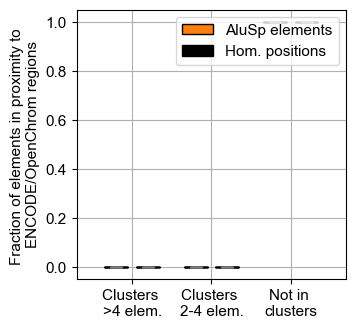

In [95]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([1,2,3])
bp_transposon=[mean_overlap_clusters_range_2_mean_test,mean_overlap_clusters_range_1_mean_test,mean_overlap_no_cluster_tr_1_mean_test]
bp_hom_pos=[mean_overlap_rd_clusters_range_2_mean_test,mean_overlap_rd_clusters_range_1_mean_test,mean_overlap_no_cluster_rd_1_mean_test]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(bp_transposon,positions=x_pos-0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp2=ax1.boxplot(bp_hom_pos,positions=x_pos+0.2,showfliers=True,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["Clusters \n>4 elem.","Clusters \n2-4 elem.","Not in \nclusters"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.legend([bp1['boxes'][0], bp2['boxes'][0]], ['AluSp elements', 'Hom. positions'],prop={'family': 'Arial','size': 11},loc="upper right")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/h_AluSp_in_prox_ENCODE_3.pdf",format="pdf",bbox_inches="tight")


In [96]:
mean_overlap_rd_clusters_range_1_mean_test

[0.0]

# Size distribution of Transposons

In [97]:
def t_size_distr_1(rmd_list_input):
    #get all sizes of transposons on each chromosome
    size_rmd_list_v1=[]
    for i in range(len(rmd_list_input)):
        size_rmd_list_v1.append( rmd_list_input[i][:]["genoEnd"].to_numpy()-rmd_list_input[i][:]["genoStart"].to_numpy()   )

    #append all sizes from each chromosome into one list
    size_rmd_list_v1_fl=[]
    for i in range(len(size_rmd_list_v1)):
        for j in range(len(size_rmd_list_v1[i])):
            size_rmd_list_v1_fl.append(size_rmd_list_v1[i][j])
            
    return size_rmd_list_v1,size_rmd_list_v1_fl

In [250]:
examples_rmd_3=rmd_3[rmd_3["repFamily"]=="L1"]

In [251]:
examples_rmd_3

genoName  genoStart    genoEnd     repName repClass  \
3                         chr1   50330063   50332153      L1PA10     LINE   
4                         chr1   58720067   58720973       L1PA2     LINE   
5                         chr1   75496180   75498100       L1MB7     LINE   
8                         chr1  117440426  117440514       L1ME1     LINE   
9                         chr1  117440494  117441457       L1ME1     LINE   
...                        ...        ...        ...         ...      ...   
5481309  chr21_gl000210_random       6396       6656       L1MB7     LINE   
5481314  chr21_gl000210_random       9359       9500       L1ME1     LINE   
5481316  chr21_gl000210_random      10059      10200       L1ME1     LINE   
5481339  chr21_gl000210_random      27296      27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468      27682  HAL1-2a_MD     LINE   

        repFamily  
3              L1  
4              L1  
5              L1  
8              L1  
9              L1  
...           ...  
5481309        L1  
5481314        L1  
5481316        L1  
5481339        L1  
5481340        L1  

[987052 rows x 6 columns]

In [260]:
unique_examples_rmd_3 = [examples_rmd_3[col_name].unique() for col_name in examples_rmd_3.columns]

for i in unique_examples_rmd_3[3]:
    print(i)

L1PA10
L1PA2
L1MB7
L1ME1
L1PA7
L1PA3
L1ME2
L1MEc
L1MA9
L1MB3
L1PA8A
L1PA6
L1M2
HAL1
L1PA14
L1MA10
L1M1
L1ME3
L1PBa
L1PA15-16
L1M4
L1MDa
L1MC4
L1ME4a
L1MB8
L1MC
L1M3
L1MC1
L1PA5
L1PA4
L1MC3
L1M5
L1PA15
L1MA1
L1PA17
L1PB4
L1M4b
L1PB1
L1PA13
L1MB1
L1MA7
L1MB2
L1PA8
L1P1
L1MA3
HAL1b
L1MC2
L1MA2
L1MC4a
L1MC5
L1ME3A
L1MCc
L1PA16
L1MCa
L1ME5
L1MEe
L1MEf
L1ME3C
L1MD3
L1P4
L1MEd
L1P5
L1MA5
L1ME3D
L1MD
L1HS
L1MA8
L1PBa1
L1PA11
L1M4c
L1MA4A
L1MA4
L1ME3F
L1PREC2
L1MD1
L1MA6
L1MD2
L1PB3
L1MEg
L1MEg2
L1MB4
L1ME3B
L1M3e
L1M3a
L1MB5
L1PB
L1ME3E
L1M2c
L1M7
HAL1-3A_ME
L1ME2z
L1MEb
HAL1-2a_MD
L1PA12
L1MA5A
L1P2
L1PB2
L1P3
L1M6
L1M
L1MCb
L1P4a
L1M3f
L1M2a
L1P4e
L1M2b
L1MDb
L1M3c
L1MEg1
L1M3de
L1M3d
L1PBb
L1P3b
L1P4d
L1MEa
L1M2a1
L1M3b
L1P4b
L1P
L1P4c
HAL1N1_MD
L1MC5a
L1ME4b
X9_LINE
L1ME3G
L1ME4c
L1ME3Cz
L1MEj
L1M8
L1MEh
L1MEi
HAL1ME
L1M4a1
L1M4a2
HAL1M8
L1M6B


In [261]:
##########
#rmd_3:
#no chrY to compare to HeLa cells
chr_list_size_1=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22","chrX"
         ]

element_sel_size_1="L1ME1" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"

element_sel_size_2="HAL1-3A_ME" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"   #"FRAM"

In [262]:
rmd_list_size_1= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_size_1,elements_name=element_sel_size_1,chr_col_name="genoName",element_col_name="repName")

In [263]:
rmd_list_size_2= sel_rep_element_on_chr_2(rmd_1=rmd_3,chr_list=chr_list_size_1,elements_name=element_sel_size_2,chr_col_name="genoName",element_col_name="repName")

In [264]:
tr_len_size_1,tr_len_size_1_fl=t_size_distr_1(rmd_list_size_1)

In [265]:
tr_len_size_2,tr_len_size_2_fl=t_size_distr_1(rmd_list_size_2)

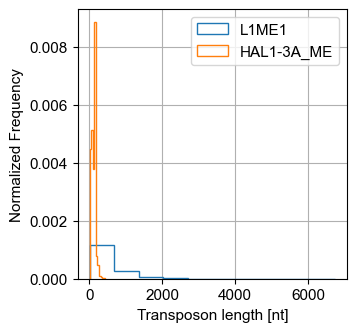

In [299]:


fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

size_hist_v1=plt.hist(tr_len_size_1_fl,density=True,label="L1ME1",histtype="step")
size_hist_v2=plt.hist(tr_len_size_2_fl,density=True,label="HAL1-3A_ME",histtype="step")

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
plt.ylabel("Normalized Frequency",fontname = "Arial",fontsize=11)
plt.xlabel("Transposon length [nt]",fontname = "Arial",fontsize=11)

#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

In [267]:
print("Mean, std. transposon length type 1:", np.mean(tr_len_size_1_fl),",",np.std(tr_len_size_1_fl),)
print("Mean, std. transposon length type 2:", np.mean(tr_len_size_2_fl),",",np.std(tr_len_size_2_fl))

Mean, std. transposon length type 1: 480.5730630716767 , 471.1156556669817
Mean, std. transposon length type 2: 112.93939393939394 , 54.07052679631445
